# Financial Sentiment Analysis on Twitter: Advanced augmentation techniques, Large Language models and Knowledge Distillation

#### By Angelo Di Gianvito

# Twitter Financial News

The Twitter Financial News dataset is a collection of English-language tweets focused on finance. It includes 11,932 tweets annotated for sentiment analysis, categorizing each tweet as 'Bearish' (LABEL_0), 'Bullish' (LABEL_1), or 'Neutral' (LABEL_2). Compiled using the Twitter API, this dataset is designed for multi-class classification tasks. It is divided into two splits: a training set with 9,938 tweets (80%) and a validation set containing 2,486 tweets (20%).

# Table of contents

1. [Part 1](#part-1)
    - [Bibliography and SOA](#bibliography-and-state-of-the-art)
    - [Dataset Description](#dataset-description)
    - [Random Classifier](#random-classifier-performance)
    - [Baseline TF-IDF](#baseline-implementation)
2. [Part 2](#part-ii)
    - [BERT Model with Limited Data](#bert-model-with-limited-data)
    - [RNN](#adding-an-rnn-layer-on-top-of-bert)
    - [Dataset Augmentation](#data-augmentation)
    - [Zero Shot Learning](#zero-shot-learning-with-llm)
    - [LLM Text Generation, FIne Tuning and Prompt Engineering](#data-generation-with-llm)
    - [Optimal Technique](#optimal-technique-application)
3. [Part 3](#part-3-state-of-the-art-comparison)
    - [Full Dataset Training](#full-dataset-training)
    - [Technique Comparison](#c-technique-comparison-05-points-incorporate-the-techniques-tested-in-part-2-into-your-training-schema-for-comparison)
    - [Methodology Analysis](#d-methodology-analysis)

4. [Part 4](#part-4-model-distillation)
    - [Model Distillation](#part-4-model-distillation)
    - [Performance and Speed Comparison](#performance-and-speed-comparison)
    - [Analysis and Improvements](#analysis-and-improvements)
    
5. [Appendix](#appendix)

### Importing Libraries

In [94]:
# Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random

# NLP Libraries
import datasets
from datasets import load_dataset
from wordcloud import WordCloud
from collections import defaultdict, Counter
import nltk
from nltk.corpus import stopwords
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
import spacy
from spacy.matcher import Matcher
import gensim.downloader as api
from nltk.tokenize import word_tokenize

# ML libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle, resample
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif


# DL Libraries
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from gensim.models.phrases import Phraser, Phrases
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from transformers import pipeline
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

random.seed(95)


In [31]:
# OpenAI API
# from openai import OpenAI

# Part 1: 

## Setting Up the Problem
- Objective: Understand and establish the baseline for your chosen dataset.

### Bibliography and State-Of-the-Art:

**Main objective**: "How can a sentiment analysis model of finance-related tweets be developed to monitor public perception of stocks"

State of the Art Model Benchmark: Fine-tuned FinancialBERT (FinBERT). Our model will be compared against FinBERT (F1 & accuarcy 0.843). Used by Christian Palomo to do sentiment analysis the same dataset to predict stock market. 

Business Applications of our study: 
1) Companies can use the model to understand how their industry is evolving, which can be crucial for corporate strategy, marketing, and public relations. 
2) Investment strategy development, analysts can use insights from the model to shape their investment strategies, identifying potential stock opportunities based on public sentiment 
3) the model can help identify sudden changes in sentiment, which might indicate potential risks or market volatility, allowing for proactive risk management. 
4) Algorithmic trading, sentiment data can be integrated into algorithmic trading systems, which can execute trades based on predefined rules tied to sentiment changes

Source: Palomo, C. Tweet Sentiment Analysis to Predict Stock Market. Stanford University.
 

### Dataset Description

The "Twitter-financial-news-sentiment" dataset has been structured into train, validation, and test sets to facilitate comprehensive model analysis. The training set comprises 7,157 instances, the validation set 2,386 instances (derived from the original train set), and the test set 2,388 instances. This setup ensures a robust evaluation framework. In terms of sentiment distribution, the majority of instances in both the train and validation sets are Neutral (64.89% and 64.29%, respectively), followed by Bullish and Bearish sentiments. The test set reflects a similar distribution, with a slightly higher Neutral percentage (65.58%).

Histograms of text length demonstrate consistency across datasets, with overlaps indicating a variety of text lengths. This consistency benefits machine learning models, suggesting adaptability to different text inputs.

Word clouds reveal prevalent financial terminology across datasets but also highlight noise from URLs, affecting sentiment analysis efficacy. Pre-processing steps, utilizing the Ekphrasis package, were applied to refine data by removing extraneous elements like URLs, phone numbers, and duplicates, enhancing dataset quality.

Prevalent hashtags reflect a consistent thematic focus on financial markets and economics. This consistency aids sentiment analysis by providing stable contextual grounding.

Post-preprocessing word clouds show a focused representation of sentiment-indicative language, highlighting optimistic, neutral, and negative sentiments in respective categories. This cleaning process enhances data relevance for sentiment analysis, crucial for project advancement.

### Utils

In [32]:
class Metrics:
    def __init__(self):
        self.results = {}

    def run(self, y_true, y_pred, method_name, average='macro'):
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average=average)
        recall = recall_score(y_true, y_pred, average=average)
        f1 = f1_score(y_true, y_pred, average=average)

        # Store results
        self.results[method_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
        }

    def plot(self):
        # Create subplots
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))

        # Plot each metric
        for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1']):
            ax = axs[i//2, i%2]
            values = [res[metric] * 100 for res in self.results.values()]
            ax.bar(self.results.keys(), values)
            ax.set_title(metric)
            ax.set_ylim(0, 100)

            # Add values on the bars
            for j, v in enumerate(values):
                ax.text(j, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

Characteristics of the dataset
b. Dataset Description: Provide a brief overview of your dataset, including size, class distribution, and any peculiar characteristics. Include basic descriptive statistics. 

In [33]:
df = load_dataset("zeroshot/twitter-financial-news-sentiment")
display(df)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9543
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2388
    })
})

In [34]:
test_data = df['validation']['text']
test_labels = df['validation']['label']

# Creating DataFrame for the test set
df_test_new = pd.DataFrame({'text': test_data, 'label': test_labels})

Twitter-financial-news-sentiment only contains and train and validation set. A test set is required for model analysis and this is created from the train set.

In [35]:
# Use the original training data
train_data = df['train']['text']
train_labels = df['train']['label']

# Splitting the original training data to create a new training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.25, random_state=10)

# Creating DataFrames for the new training set and validation set
df_train_new = pd.DataFrame({'text': X_train, 'label': y_train})
df_val_new = pd.DataFrame({'text': X_val, 'label': y_val})

In [36]:
print(f"New Training Set Size: {len(df_train_new)}")
print(f"Validation Set Size: {len(df_val_new)}")
print(f"Test Set Size: {len(df_test_new)}")

New Training Set Size: 7157
Validation Set Size: 2386
Test Set Size: 2388


In [37]:
print("New Training Set Samples:")
print(df_train_new.sample(5), '\n')

print("Validation Set Samples:")
print(df_val_new.sample(5), '\n')

print("Test Set Samples:")
print(df_test_new.sample(5))


New Training Set Samples:
                                                   text  label
1935  More than 200,000 background checks for gun pu...      2
5188  The world's first commercial mobile phone cost...      2
2080  Dow Rallies on Signs Coronavirus Pandemic Is S...      1
1079  Johnson’s manifesto demands voters take a lot ...      2
4045  General Announcement::SIIC Environment to Buil...      2 

Validation Set Samples:
                                                   text  label
2279  Twitter : Statement of Changes in Beneficial O...      2
2171  Watchdog Questions $6.7 Billion in Medicare Pa...      2
919   U.S. Fed buys $427 million of mortgage bonds, ...      2
229   $STOK $TROV $BNTC - vTv Therapeutics leads hea...      2
655   Financial markets latched on to figures sugges...      1 

Test Set Samples:
                                                   text  label
1868  White House adviser Larry Kudlow says he wants...      2
1776  Ahead of the election, Johnson and Corby

### EDA on labels of the dataset and text length

In [38]:
# Assuming label_to_sentiment mapping is correct
label_to_sentiment = {0: 'Bearish', 1: 'Bullish', 2: 'Neutral'}

# Function to calculate class distribution from a DataFrame
def class_distribution(df):
    # Assuming the 'label' column in your DataFrame corresponds to the labels
    distribution = df['label'].map(label_to_sentiment).value_counts(normalize=True) * 100
    return distribution

# Calculate class distribution for each set using the updated DataFrames
train_distribution = class_distribution(df_train_new)
validation_distribution = class_distribution(df_val_new)
test_distribution = class_distribution(df_test_new)

# Create DataFrames for class distribution
train_dist_df = pd.DataFrame({'Class': train_distribution.index, 'Percentage': train_distribution.values})
validation_dist_df = pd.DataFrame({'Class': validation_distribution.index, 'Percentage': validation_distribution.values})
test_dist_df = pd.DataFrame({'Class': test_distribution.index, 'Percentage': test_distribution.values})

# Display class distributions
print('Class Distribution in TRAIN Set')
display(train_dist_df.round(2))
print('\nClass Distribution in VALIDATION Set')
display(validation_dist_df.round(2))
print('\nClass Distribution in TEST Set')
display(test_dist_df.round(2))



Class Distribution in TRAIN Set


,Class,Percentage
0,Neutral,64.89
1,Bullish,20.06
2,Bearish,15.05



Class Distribution in VALIDATION Set


,Class,Percentage
0,Neutral,64.29
1,Bullish,20.41
2,Bearish,15.30



Class Distribution in TEST Set


,Class,Percentage
0,Neutral,65.58
1,Bullish,19.89
2,Bearish,14.53


Label distribution in the Train set:



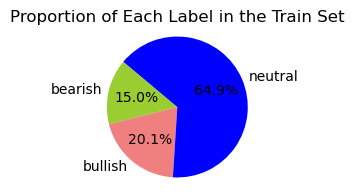

Label distribution in the Validation set:



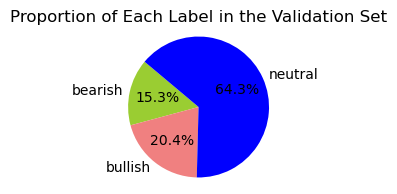

Label distribution in the Test set:



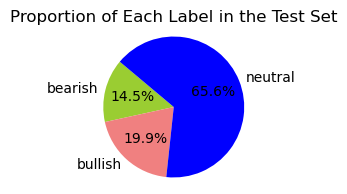

In [39]:
# Labels dictionary remains the same
labels = {0: 'bearish', 1: 'bullish', 2: 'neutral'}

# Color mapping for each sentiment label
color_mapping = {'bearish': 'yellowgreen', 'bullish': 'lightcoral', 'neutral': 'blue'}

# Updated function to plot label distribution with consistent color mapping
def plot_label_distribution(df, dataset_name):
    # Count the frequency of each label in the DataFrame
    label_counts = Counter(df['label'])
    
    # Sort labels to ensure consistent color application
    sorted_labels = sorted(label_counts.items(), key=lambda x: labels[x[0]])

    # Data to plot
    _labels = [labels[lab] for lab, _ in sorted_labels]
    sizes = [count for _, count in sorted_labels]
    colors = [color_mapping[lab] for lab in _labels]
    
    # Plot
    print(f'Label distribution in the {dataset_name} set:\n')
    plt.figure(figsize=(2, 2))  # Adjusts the size of the pie chart
    plt.pie(sizes, labels=_labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(f'Proportion of Each Label in the {dataset_name} Set')
    plt.show()

# Plotting for train, validation, and test datasets
plot_label_distribution(df_train_new, 'Train')
plot_label_distribution(df_val_new, 'Validation')
plot_label_distribution(df_test_new, 'Test')

Text lengths in train, test and validation sets indicate a similar distribution, with an average text length around 12 words and a standard deviation of about 4.7 words. The close resemblance is beneficial for model training and evaluation consistency.

In [40]:
def text_length_distribution(data):
    return [len(text.split()) for text in data]

In [41]:
# Since you're now using df_train_new, df_val_new, df_test_new, extract text data accordingly
train_data = df_train_new['text']
validation_data = df_val_new['text']
test_data = df_test_new['text']

# Calculate text lengths for each set using the existing function
train_lengths = text_length_distribution(train_data)
validation_lengths = text_length_distribution(validation_data)
test_lengths = text_length_distribution(test_data)

# Descriptive statistics
print('Descriptive Statistics of Text Lengths in TRAIN Set:')
print(pd.Series(train_lengths).describe(), '\n')

print('Descriptive Statistics of Text Lengths in VALIDATION Set:')
print(pd.Series(validation_lengths).describe(), '\n')

print('Descriptive Statistics of Text Lengths in TEST Set:')
print(pd.Series(test_lengths).describe(), '\n')



Descriptive Statistics of Text Lengths in TRAIN Set:
count    7157.000000
mean       12.174514
std         4.656943
min         1.000000
25%         9.000000
50%        11.000000
75%        15.000000
max        32.000000
dtype: float64 

Descriptive Statistics of Text Lengths in VALIDATION Set:
count    2386.000000
mean       12.189858
std         4.692426
min         1.000000
25%         9.000000
50%        11.000000
75%        15.000000
max        27.000000
dtype: float64 

Descriptive Statistics of Text Lengths in TEST Set:
count    2388.000000
mean       12.321608
std         4.722062
min         1.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        33.000000
dtype: float64 



Histograms for visual analysis

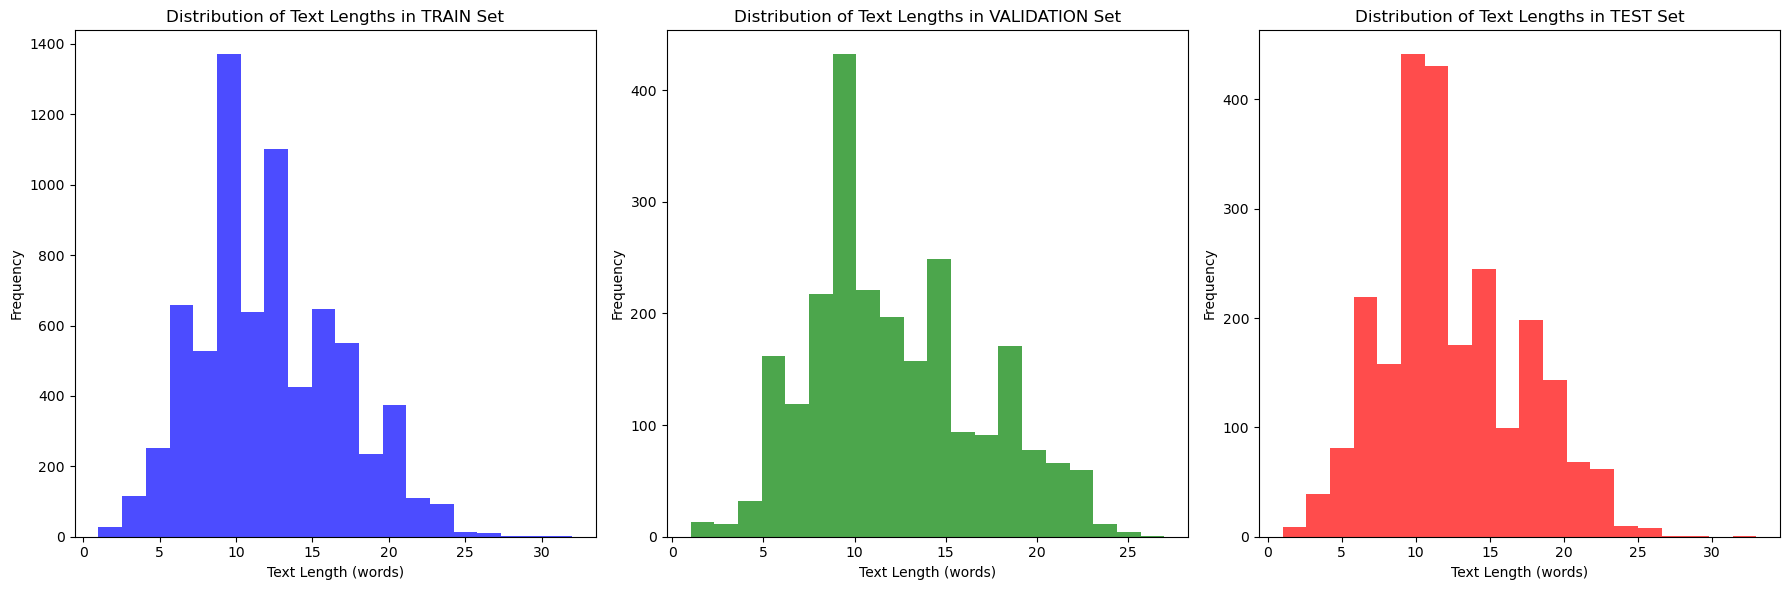

In [42]:
# Histograms for visual analysis
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.hist(train_lengths, bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Text Lengths in TRAIN Set')
plt.xlabel('Text Length (words)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(validation_lengths, bins=20, color='green', alpha=0.7)
plt.title('Distribution of Text Lengths in VALIDATION Set')
plt.xlabel('Text Length (words)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(test_lengths, bins=20, color='red', alpha=0.7)
plt.title('Distribution of Text Lengths in TEST Set')
plt.xlabel('Text Length (words)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Wordclouds

Word Cloud for train, test validation dataframes are not insightful, let's instead create a wordcloud by label type

Word Cloud for Train Set


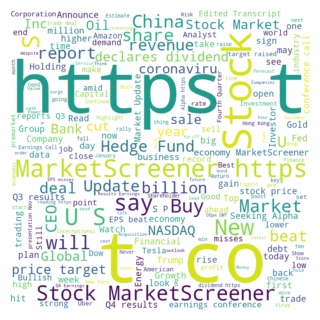

Word Cloud for Validation Set


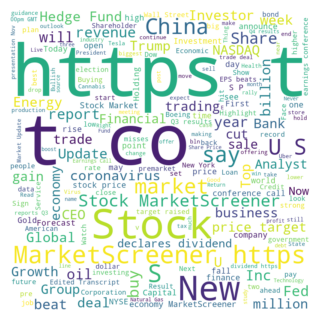

Word Cloud for Test Set


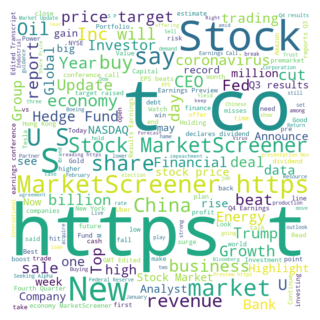

In [43]:
from wordcloud import WordCloud, STOPWORDS
# Extract text data as lists from the updated DataFrames
train_data_new = df_train_new['text'].tolist()
validation_data_new = df_val_new['text'].tolist()
test_data_new = df_test_new['text'].tolist()

# Function to create a word cloud from a list of texts, as you defined
def create_word_cloud(text_data):
    combined_text = ' '.join(text_data)
    wordcloud = WordCloud(width = 800, height = 800, 
                          background_color ='white', 
                          stopwords = set(STOPWORDS),  # Utilize STOPWORDS set for common stopwords
                          min_font_size = 10).generate(combined_text)
    
    plt.figure(figsize = (3, 3), facecolor = None)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

# Create and display word cloud for each dataset
print("Word Cloud for Train Set")
create_word_cloud(train_data_new)

print("Word Cloud for Validation Set")
create_word_cloud(validation_data_new)

print("Word Cloud for Test Set")
create_word_cloud(test_data_new)


Common financial terms and noise-inducing URLs are prominent across all three labels. This suggests that while specific financial jargon is well represented, there is a need to filter out less informative elements like web addresses. In the following pre-processing section, we will improve the focus on sentiment-indicative language. 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ruimaciel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


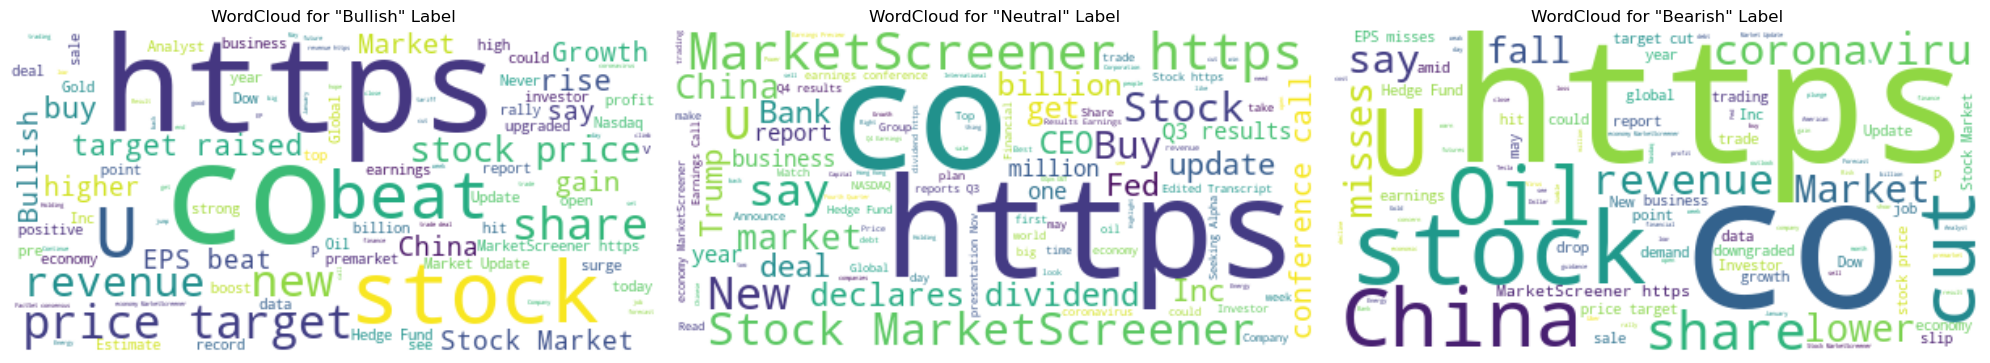

In [44]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

labels = {0: 'Bearish', 1: 'Bullish', 2: 'Neutral'}

# Assuming df_train_new, df_val_new, df_test_new are your updated datasets
# Prepare data for wordclouds, consolidating texts by label across all datasets
label_data = defaultdict(lambda: '')

# Update to accumulate texts from train, validation, and test datasets
for dataset in [df_train_new, df_val_new, df_test_new]:
    for text, label in zip(dataset['text'], dataset['label']):
        label_data[label] += text + ' '

# Generate and plot wordclouds for each label
fig, axs = plt.subplots(1, len(labels), figsize=(20, 10))  # Adjust the size as needed
axs = axs.flatten()  # Flatten the axis array if necessary

for ax, (label, texts) in zip(axs, label_data.items()):
    wordcloud = WordCloud(stopwords=stop_words, background_color='white', max_words=100).generate(texts)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title('WordCloud for "{}" Label'.format(labels.get(label)))
    ax.axis('off')

plt.tight_layout()
plt.show()


### Cleaning tweets

We wanted to use a package specifically designed for social media text and online communication for data preprocesing. The Ekphrasis package in Python (source: https://github.com/cbaziotis/ekphrasis) is a specialized tool for processing and interpreting textual data from social media and online communication platforms. It excels at handling the nuances and idiosyncrasies of language in informal contexts, such as Twitter, by effectively managing informal expressions, abbreviations, hashtags, and emoticons for deeper text analysis.

In [45]:
# Initialize the text preprocessing tool tailored for social media text, with a focus on 
# normalizing various entities and annotating specific patterns commonly found in such texts.
text_processor = TextPreProcessor(
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
               'time', 'url', 'date', 'number'],
    annotate={"hashtag", "allcaps", "elongated", "repeated",
              'emphasis', 'censored'},
    fix_html=True, # Fixes HTML encoding issues
    segmenter="twitter", # Tailors the segmenter for Twitter text.
    corrector="twitter",  #Uses a corrector tailored for Twitter language.
    unpack_hashtags=True, # Splits hashtags into words.
    unpack_contractions=True, # Expands contractions (e.g., "can't" to "cannot").
    spell_correct_elong=False, # Disables automatic correction of elongated words.
    tokenizer=SocialTokenizer(lowercase=True).tokenize, # Tokenizes text, converts to lowercase.
    dicts=[emoticons], # Incorporates a dictionary of emoticons.
    pre_processor=[lambda x: x.replace('＼(^o^)／', '')] # Removes specific unwanted characters.
)

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


In [46]:
# Extracts clean text from the preprocessed output by removing unwanted tokens and characters.
def extract_clean(text):
    cleaned_text = ' '.join([word.split('<')[0] for word in text])
    return cleaned_text

# Extracts emoticons from the preprocessed text.
def extract_emotions(text):
    emoji_expressions = [token for token in text if token in emoticons.values()]
    return emoji_expressions

# Cleans the text by removing extra whitespace and leading/trailing spaces.
def clean_string(text):
    cleaned_text = re.sub(r'\s+', ' ', text)
    cleaned_text = cleaned_text.strip()
    return cleaned_text

# Flattens the list of emotions into a string and removes duplicate emoticons.
def flatten_emotions(emotion_list):
    emotion_string = ', '.join(emotion_list)
    emotions = re.findall(r'<([^>]*)>', emotion_string)
    unique_emotions = list(set(emotions))
    combined_emotions = ', '.join(unique_emotions)
    return combined_emotions

# The main function that applies all the above cleaning procedures to a DataFrame.
# Function to preprocess and clean dataset
def clean_text(df):
    preprocessed_texts = []
    for text in df['text']:
        try:
            processed = text_processor.pre_process_doc(text)
        except Exception as e:
            print(f"Error processing text: {text}\nError: {e}")
            processed = ""
        preprocessed_texts.append(processed)

    # Create a copy of the DataFrame for modifications
    new_df = df.copy()

    # Use loc to modify the copied dataframe
    new_df.loc[:, 'preprocessed_text'] = preprocessed_texts
    new_df.loc[:, 'clean_text'] = new_df['preprocessed_text'].apply(extract_clean).apply(clean_string)
    new_df.loc[:, 'hashtag'] = new_df['text'].apply(lambda x: re.findall(r'#(\w+)', x))
    new_df.loc[:, 'hashtag'] = new_df['hashtag'].apply(lambda i: ' '.join(i))
    new_df.loc[:, 'emotions'] = new_df['preprocessed_text'].apply(extract_emotions)
    new_df.loc[:, 'clean_emotions'] = new_df['emotions'].apply(flatten_emotions)

    # Reorganize columns in the new DataFrame
    new_df = new_df[['text', 'label', 'clean_text', 'clean_emotions', 'hashtag']]
    
    return new_df


In [47]:
# Apply the cleaning function to the new training, validation, and test datasets.
df_train = clean_text(df_train_new)
df_val = clean_text(df_val_new)
df_test = clean_text(df_test_new)

In [48]:
df_train

,text,label,clean_text,clean_emotions,hashtag
0,Uber To Profit From Better Pricing Environment...,1,uber to profit from better pricing environment...,,
1,Wall Street firms release their 2020 S&P 500 t...,2,wall street firms release their s & p targets,,
2,"Stocks have given back most of their gains, an...",0,"stocks have given back most of their gains , a...",,
3,US Gasoline Crashes To 50c - Lowest Since 2001...,0,us gasoline crashes to 5 0 c - lowest since - ...,,
4,HPE +2% as Deutsche sees growth story,1,hpe + as deutsche sees growth story,,
...,...,...,...,...,...
7152,Medtronic +2% premarket on FQ2 beat,1,medtronic + premarket on fq2 beat,,
7153,Michael Bloomberg is joining a crowded 2020 De...,2,michael bloomberg is joining a crowded democra...,,
7154,Canadian National Railway on watch amid strike,2,canadian national railway on watch amid strike,,
7155,Michael Gove warns the logistics industry to p...,2,michael gove warns the logistics industry to p...,,


Given the lack of examples of clean_emotions and hashtag in the dataset, if these are being populated.

We can see that clean_emotions and hastags are being populated as per design but only in 0.31% and 9.23% of rows in the train set respectively.

In [49]:
# Initialize counters
emotion_count = 0
hashtag_count = 0

emotions = []
hashtags = []
# Loop for clean_emotions
for index, row in df_train.iterrows():
    if row['clean_emotions']:
        if row['clean_emotions'] not in emotions:
            emotions.append(row['clean_emotions'])
            # print("Emotion:", row['clean_emotions'])
        emotion_count += 1

# Loop for hashtags
for index, row in df_train.iterrows():
    if row['hashtag']:
        if row['hashtag'] not in hashtags:
            hashtags.append(row['hashtag'])
            # print("Hashtags:", row['hashtag'])
        hashtag_count += 1

print(emotions)
print(hashtags)


['sad', 'kiss', 'happy']
['investing markets business', 'economy MarketScreener', 'AudioCodes Stock', 'NYSESlice', 'CobaltBlue Stock MarketScreener', 'BrexitDay', 'NorthropGrumman Stock', 'NASDAQ Stock', 'WTI Stock MarketScreener', 'Skanska Stock MarketScreener', 'Samp economy MarketScreener', 'Novartis Stock MarketScreener', 'LondonStockExchange Stock MarketScreener', 'markets stockmarket economy', 'taux MarketScreener', 'markets stocks economy', 'GammaCommunications', 'business trading stocks', 'finance stocks business', 'stocks finance trading', 'NewEconForum', 'eBay Stock MarketScreener', 'analysis news data market PageOne', 'finance business stockmarket', 'SiebertFinancial Stock MarketScreener', 'SynlaitMilk Stock MarketScreener', 'investing business finance', 'Stock MarketScreenerÂ', 'Stock MarketScreener', 'AlignTechnology Stock MarketScreener', 'MMG Stock MarketScreener', 'CharlesSchwab Stock', 'neweconforum', 'AVWAP', 'ArmourEnergy Stock MarketScreener', 'Amazoncom Stock Marke

In [50]:
# Print counts
print("Total rows with non-empty clean_emotions:", emotion_count)
print("Total rows with non-empty hashtags:", hashtag_count)

# Total number of rows in df_train
total_rows = len(df_train)

# Calculate percentages
emotion_percentage = (emotion_count / total_rows) * 100
hashtag_percentage = (hashtag_count / total_rows) * 100

# Print counts and percentages
print("Total rows with non-empty clean_emotions:", emotion_count)
print("Percentage of non-empty clean_emotions:", emotion_percentage, "%")
print("Total rows with non-empty hashtags:", hashtag_count)
print("Percentage of non-empty hashtags:", hashtag_percentage, "%")

Total rows with non-empty clean_emotions: 22
Total rows with non-empty hashtags: 661
Total rows with non-empty clean_emotions: 22
Percentage of non-empty clean_emotions: 0.30739136509710774 %
Total rows with non-empty hashtags: 661
Percentage of non-empty hashtags: 9.235713287690373 %


The most common hashtags across the training, test, and validation sets are primarily related to financial markets and stock trading, with frequent references to specific market indices, economic terms, and financial platforms. 

In [51]:
from collections import Counter

def count_hashtags(df, column_name='hashtag', top_n=10):
    # Prepare hashtags - accommodate both string and list formats
    all_hashtags = []
    for hashtag_entry in df[column_name]:
        if isinstance(hashtag_entry, list):
            # Filter out empty strings and extend if it's a list
            all_hashtags.extend(filter(None, hashtag_entry))
        elif isinstance(hashtag_entry, str) and hashtag_entry.strip():
            # Add if it's a non-empty string
            all_hashtags.append(hashtag_entry)

    # Count occurrences of each hashtag
    hashtag_counts = Counter(all_hashtags)

    # Return the most common hashtags
    return hashtag_counts.most_common(top_n)

# Counting and displaying the top 10 hashtags for each dataset
print("Most common hashtags in the training set:")
print(count_hashtags(df_train))

print("\nMost common hashtags in the test set:")
print(count_hashtags(df_test))

print("\nMost common hashtags in the validation set:")
print(count_hashtags(df_val))


Most common hashtags in the training set:
[('economy MarketScreener', 94), ('Stock MarketScreener', 33), ('WTI Stock MarketScreener', 14), ('LondonStockExchange Stock MarketScreener', 7), ('Samp economy MarketScreener', 4), ('IBDPartner', 4), ('SP500 index MarketScreener', 4), ('BrexitDay', 3), ('taux MarketScreener', 3), ('stocks finance trading', 3)]

Most common hashtags in the test set:
[('economy MarketScreener', 23), ('Stock MarketScreener', 12), ('Silver Stock MarketScreener', 3), ('SP500 index MarketScreener', 3), ('LondonStockExchange Stock MarketScreener', 3), ('Stock', 2), ('Allergan Stock MarketScreener', 2), ('Naspers Stock MarketScreener', 2), ('investing economy finance', 2), ('markets business economy', 2)]

Most common hashtags in the validation set:
[('economy MarketScreener', 29), ('Stock MarketScreener', 12), ('Stock', 6), ('SP500 index MarketScreener', 4), ('economy', 4), ('WTI Stock MarketScreener', 3), ('BankofIreland Stock MarketScreener', 3), ('UberTechnologies

In [52]:
labels = {0: 'Bearish', 1: 'Bullish', 2: 'Neutral'}
df_test['label_names'] = df_test['label'].map(labels)
df_train['label_names'] = df_train['label'].map(labels)
df_val['label_names'] = df_val['label'].map(labels)

Hashtag Extraction and Analysis:
In financial texts, especially on social media platforms like Twitter, hashtags often play a crucial role in categorizing content and highlighting key themes or topics. In the financial domain, these might include stock tickers, market trends, or economic events. Extraction > Analysis 

In [53]:
# Display specific rows of  cleaned text
display(df_train['clean_text'][1:2])
display(df_val['clean_text'][1:2])
display(df_test['clean_text'][1:2])

# Save the DataFrame to a CSV file
df_train.to_csv('processed_financial_data_train.csv', index=False)
df_val.to_csv('processed_financial_data_val.csv', index=False)
df_test.to_csv('processed_financial_data_test.csv', index=False)

# To confirm that the data has been saved, you can read it back
df_saved_train = pd.read_csv('processed_financial_data_train.csv')
df_saved_val = pd.read_csv('processed_financial_data_val.csv')
df_saved_test = pd.read_csv('processed_financial_data_test.csv')

display(df_saved_train['clean_text'][1:2])
display(df_saved_val['clean_text'][1:2])
display(df_saved_test['clean_text'][1:2])

1    wall street firms release their s & p targets
Name: clean_text, dtype: object

1    news highlights : top energy news of the day w...
Name: clean_text, dtype: object

1    $dell $hpe - dell , hpe targets trimmed on com...
Name: clean_text, dtype: object

1    wall street firms release their s & p targets
Name: clean_text, dtype: object

1    news highlights : top energy news of the day w...
Name: clean_text, dtype: object

1    $dell $hpe - dell , hpe targets trimmed on com...
Name: clean_text, dtype: object

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ruimaciel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


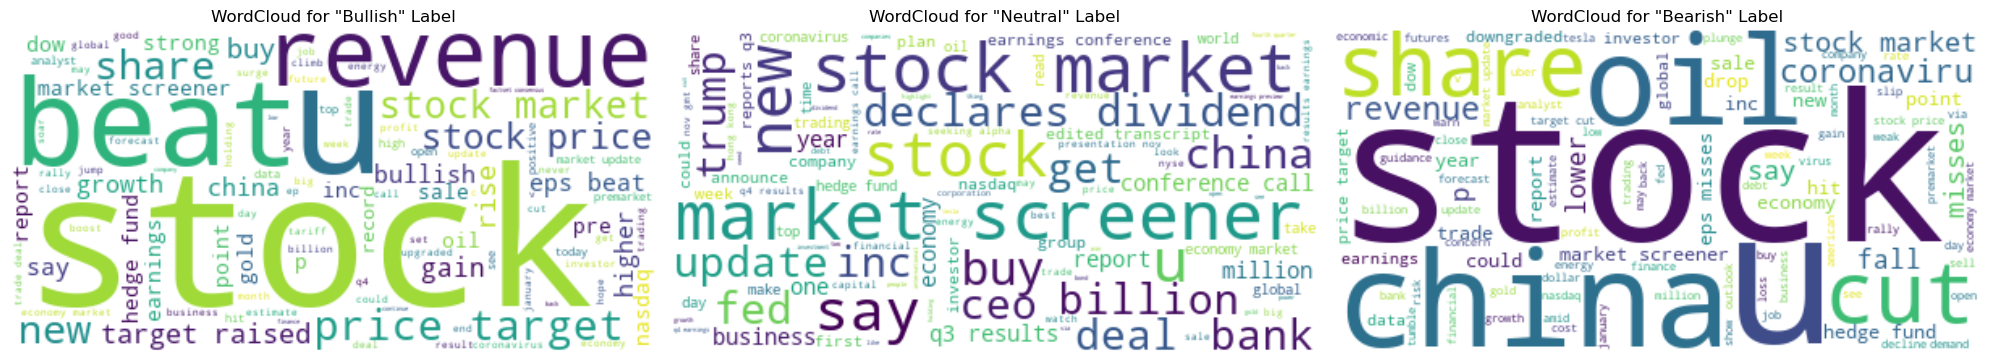

In [54]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

labels = {0: 'Bearish', 1: 'Bullish', 2: 'Neutral'}

# Assuming df_train_new, df_val_new, df_test_new are your updated datasets
# Prepare data for wordclouds, consolidating texts by label across all datasets
label_data = defaultdict(lambda: '')

# Update to accumulate texts from train, validation, and test datasets
for dataset in [df_train, df_val, df_test]:
    for text, label in zip(dataset['clean_text'], dataset['label']):
        label_data[label] += text + ' '

# Generate and plot wordclouds for each label
fig, axs = plt.subplots(1, len(labels), figsize=(20, 10))  # Adjust the size as needed
axs = axs.flatten()  # Flatten the axis array if necessary

for ax, (label, texts) in zip(axs, label_data.items()):
    wordcloud = WordCloud(stopwords=stop_words, background_color='white', max_words=100).generate(texts)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title('WordCloud for "{}" Label'.format(labels.get(label)))
    ax.axis('off')

plt.tight_layout()
plt.show()

## Random Classifier Performance

For the Random Classifier, the accuracy, precision, recall, and F1 score around 34.98% to 34.99%, indicating a predictable performance for a random classifier, given the task's three classes: Bearish, Bullish, and Neutral.

In a balanced dataset where each class is equally likely to occur, a random classifier would naturally have approximately a 33.33% chance of correctly predicting the class. This aligns closely with the observed performance, reinforcing the notion that the classifier is essentially making random guesses.

The confusion matrix reinforces this idea of balanced random guessing, with similar values distributed evenly throughout the matrix. There's no discernible bias towards any specific class, indicating that the classifier isn't learning from the data but is instead relying on chance.

The random classifier, as expected, performed poorly. It makes predictions without any knowledge of the data. Any sophisticated model should improve on this model metrics. The classification report shows precision and recall values are around 33-35% for each class, which is roughly what you would expect when there are three equally likely classes.

In [55]:
# Function definition: random_classifier
def random_classifier(X, n_categories):
    # Calculate the number of observations
    n_obs = len(X)
    # Generate random predictions for each observation
    predictions = np.random.choice(range(n_categories), size=n_obs)
    return predictions

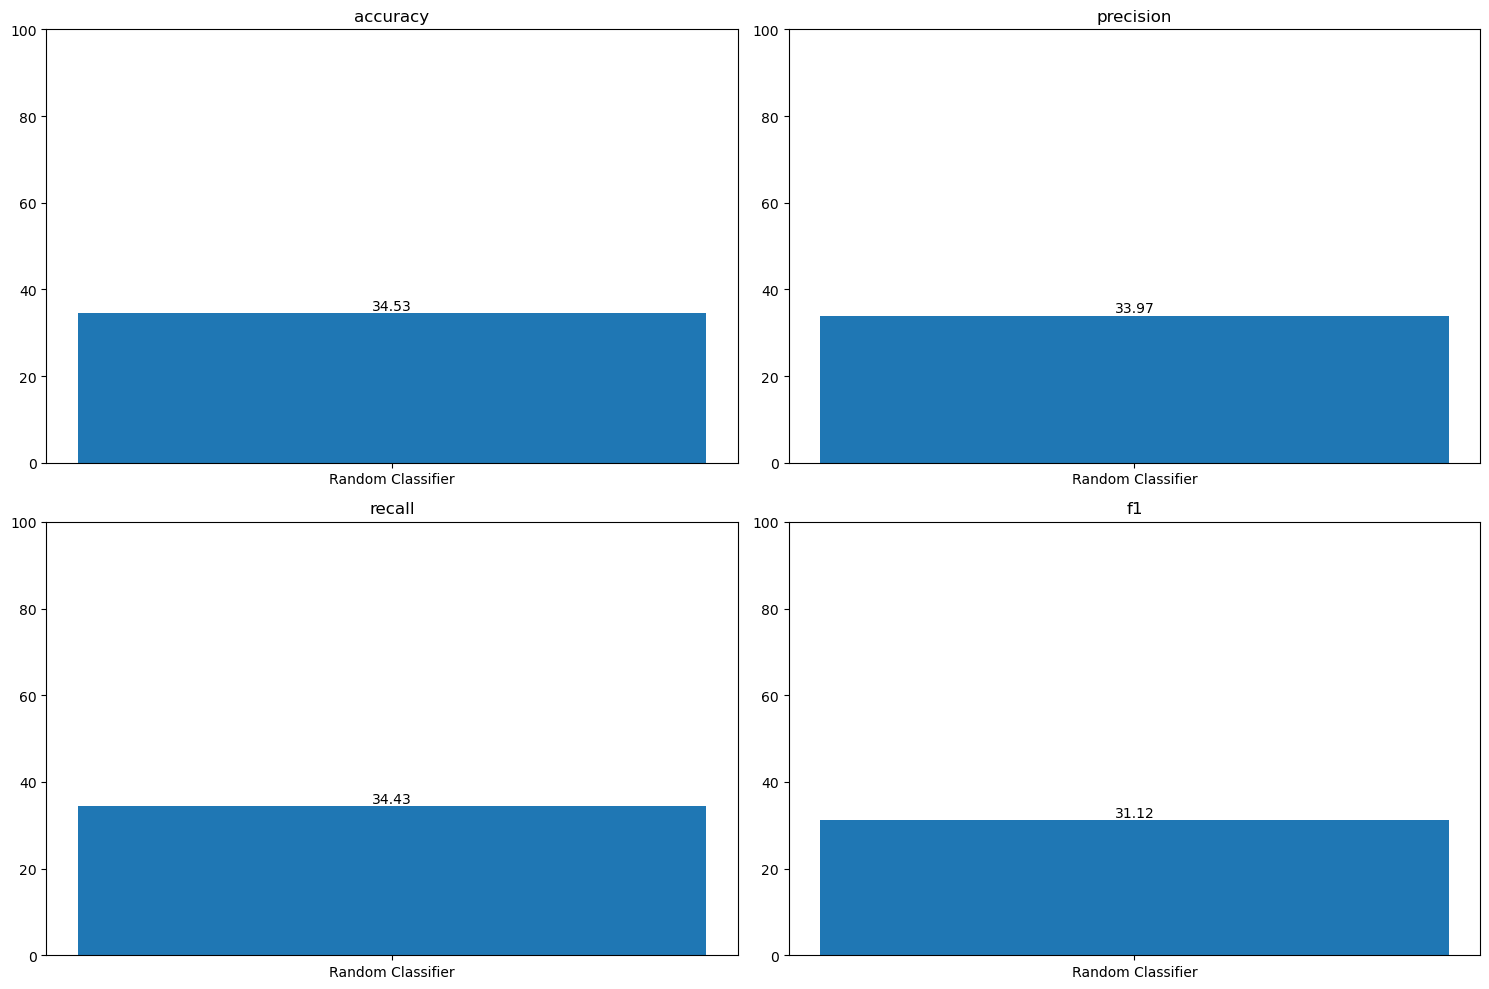

In [56]:
# Define class names for clarity in the reports
class_names = ['Bearish', 'Bullish', 'Neutral']

# Generate random predictions for the validation dataset
# The 'clean_text' column is used only to get the number of observations.
y_pred_random = random_classifier(df_val['clean_text'], len(class_names))

# Assuming Metrics is a pre-defined class for calculating and storing metrics.
metrics = Metrics()
# Calculate metrics using the random predictions and actual labels
metrics.run(df_val['label'], y_pred_random, "Random Classifier")

# Plotting the metrics for the random classifier, assuming metrics.plot() is implemented
metrics.plot()


Classification Report for Random Classifier:
              precision    recall  f1-score   support

     Bearish       0.16      0.32      0.21       365
     Bullish       0.22      0.37      0.27       487
     Neutral       0.64      0.34      0.45      1534

    accuracy                           0.35      2386
   macro avg       0.34      0.34      0.31      2386
weighted avg       0.48      0.35      0.38      2386



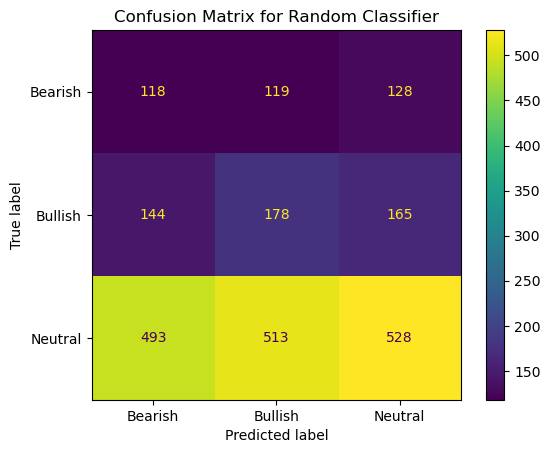

In [57]:
# Print the classification report for the random classifier
print("Classification Report for Random Classifier:")
print(classification_report(df_val['label'], y_pred_random, target_names=class_names))

# Generate and display a confusion matrix for the random classifier
cm_random = confusion_matrix(df_val['label'], y_pred_random)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_random, display_labels=class_names)
disp.plot(values_format='.4g')  # '.4g' ensures 4 significant digits in the plot
plt.title('Confusion Matrix for Random Classifier')
plt.show()

## Baseline Implementation:

A rule-based approach using spaCy's pattern matching demonstrated notable performance improvements over a random classifier, achieving an accuracy of 47.21%, precision of 66.84%, recall of 47.21%, and an F1 score of 42.60%. This approach significantly outperformed the random classifier, which averaged around 34.98% across all metrics. However, the rule-based classifier showed challenges in distinguishing between Bearish and Neutral sentiments despite its success in identifying the Neutral class.

The rule-based model incorporated specific patterns to capture expressions related to optimistic (e.g., "gain," "surge," "bullish trend"), negative (e.g., "loss," "decline," "bearish trend"), and neutral (e.g., "stable," "unchanged," "no significant movement") financial outlooks. While effective in leveraging linguistic cues for sentiment analysis, the approach is limited by its simplistic nature and inability to handle nuanced financial language, context, irony, or subtle sentiment expressions beyond basic pattern matching.

To achieve higher performance and approach human-level understanding, future sentiment analysis models should integrate advanced contextual comprehension and refined language features. Although the rule-based classifier sets a baseline demonstrating the potential of basic linguistic patterns in sentiment analysis, there remains a clear need for more sophisticated approaches to tackle the complexity of financial text data effectively.

We chose spaCy for our baseline model due to its speed and efficiency in handling large text volumes. SpaCy's Matcher effectively identifies token sequences based on attributes like "LEMMA."

The model achieved high precision for 'Bearish' and 'Bullish' sentiments, indicating accurate predictions in these categories. However, its low recall suggests it misses many actual instances of these sentiments. Conversely, the 'Neutral' category shows high recall but lower precision, often misclassifying other sentiments as 'Neutral.'

These results serve as a baseline, and future models will aim to improve upon them.

In [58]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm") # Load English language model for tokenization and linguistic annotations.

# Define positive, negative, and neutral sentiment patterns using spaCy's Matcher.
# Each pattern is a list of dictionaries, where each dictionary specifies one token and its attributes.
matcher = Matcher(nlp.vocab)

In [59]:
# Each sublist is a pattern; each dictionary within is one token in the pattern.
# E.g., [{"LEMMA": "bull"}] will match any token where the lemma (base form) is 'bull'.
pos_patts = [
    [{"LEMMA": "bull"}], [{"LEMMA": "up"}], [{"LEMMA": "gain"}], [{"LEMMA": "rally"}], 
    [{"LEMMA": "surge"}], [{"LEMMA": "rebound"}], [{"LOWER": "beating"}, {"LOWER": "the"}, {"LOWER": "market"}],
    [{"LOWER": "outperforming"}], [{"LOWER": "high"}, {"LOWER": "returns"}], [{"LOWER": "profitable"}, {"LOWER": "quarter"}],
    [{"LOWER": "economic"}, {"LOWER": "recovery"}], [{"LOWER": "rising"}, {"LOWER": "demand"}], 
    [{"LOWER": "increased"}, {"LOWER": "consumer"}, {"LOWER": "confidence"}], [{"LOWER": "positive"}, {"LOWER": "outlook"}],
    [{"LOWER": "optimistic"}, {"LOWER": "view"}], [{"LOWER": "market"}, {"LOWER": "leader"}], 
    [{"LOWER": "share"}, {"LOWER": "rise"}], [{"LOWER": "accelerated"}], [{"LOWER": "bullish"}, {"LOWER": "trend"}],
    [{"LOWER": "market"}, {"LOWER": "outperformer"}], [{"LOWER": "value"}, {"LOWER": "increase"}],
    [{"LOWER": "profit"}, {"LOWER": "surge"}]
]

# Negative patterns defined in a similar way to positive patterns.
# E.g., [{"LEMMA": "bear"}] matches tokens with the lemma 'bear'.
neg_patts = [
    [{"LEMMA": "bear"}], [{"LEMMA": "down"}], [{"LEMMA": "loss"}], [{"LEMMA": "decline"}], [{"LEMMA": "fall"}],
    [{"LEMMA": "crash"}], [{"LEMMA": "slump"}], [{"LOWER": "underperforming"}], [{"LOWER": "low"}, {"LOWER": "returns"}],
    [{"LOWER": "poor"}, {"LOWER": "quarter"}], [{"LOWER": "recession"}], [{"LOWER": "falling"}, {"LOWER": "demand"}], 
    [{"LOWER": "decreased"}, {"LOWER": "consumer"}, {"LOWER": "confidence"}], [{"LOWER": "negative"}, {"LOWER": "outlook"}],
    [{"LOWER": "pessimistic"}, {"LOWER": "view"}], [{"LOWER": "financial"}, {"LOWER": "loss"}], 
    [{"LOWER": "market"}, {"LOWER": "laggard"}], [{"LOWER": "share"}, {"LOWER": "fall"}], 
    [{"LOWER": "steep"}, {"LOWER": "loss"}], [{"LOWER": "bearish"}, {"LOWER": "trend"}],
    [{"LOWER": "market"}, {"LOWER": "underperformer"}], [{"LOWER": "value"}, {"LOWER": "decrease"}],
    [{"LOWER": "profit"}, {"LOWER": "drop"}], [{"LOWER": "economic"}, {"LOWER": "slowdown"}]
]

# Neutral patterns capture words or phrases typically indicating neutral sentiment.
neutral_patts = [
    [{"LEMMA": "stable"}], [{"LEMMA": "steady"}], [{"LOWER": "unchanged"}], 
    [{"LOWER": "consistent"}], [{"LOWER": "flat"}, {"LOWER": "market"}],
    [{"LOWER": "volatile"}, {"LOWER": "market"}], [{"LOWER": "uncertain"}, {"LOWER": "future"}],
    [{"LOWER": "could"}, {"LOWER": "go"}, {"LOWER": "either"}, {"LOWER": "way"}],
    [{"LOWER": "market"}, {"LOWER": "stability"}], [{"LOWER": "no"}, {"LOWER": "significant"}, {"LOWER": "change"}],
    [{"LOWER": "market"}, {"LOWER": "equilibrium"}], [{"LOWER": "business"}, {"LOWER": "as"}, {"LOWER": "usual"}],
    [{"LOWER": "no"}, {"LOWER": "major"}, {"LOWER": "movement"}], [{"LOWER": "steady"}, {"LOWER": "growth"}]
]


# Add the defined patterns to the Matcher with corresponding labels.
# This enables the Matcher to identify which category a matched pattern belongs to.
matcher.add("POSITIVE_CHARACTERISTICS", pos_patts)
matcher.add("NEGATIVE_CHARACTERISTICS", neg_patts)
matcher.add("NEUTRAL_CHARACTERISTICS", neutral_patts)


In [60]:
#verification step before executing pattern matching
print(df_train.columns)  # Should list 'clean_text' among others
print(df_train['clean_text'].head())  # Display first few entries of clean_text for verification

Index(['text', 'label', 'clean_text', 'clean_emotions', 'hashtag',
       'label_names'],
      dtype='object')
0    uber to profit from better pricing environment...
1        wall street firms release their s & p targets
2    stocks have given back most of their gains , a...
3    us gasoline crashes to 5 0 c - lowest since - ...
4                  hpe + as deutsche sees growth story
Name: clean_text, dtype: object


In [61]:
df_train

,text,label,clean_text,clean_emotions,hashtag,label_names
0,Uber To Profit From Better Pricing Environment...,1,uber to profit from better pricing environment...,,,Bullish
1,Wall Street firms release their 2020 S&P 500 t...,2,wall street firms release their s & p targets,,,Neutral
2,"Stocks have given back most of their gains, an...",0,"stocks have given back most of their gains , a...",,,Bearish
3,US Gasoline Crashes To 50c - Lowest Since 2001...,0,us gasoline crashes to 5 0 c - lowest since - ...,,,Bearish
4,HPE +2% as Deutsche sees growth story,1,hpe + as deutsche sees growth story,,,Bullish
...,...,...,...,...,...,...
7152,Medtronic +2% premarket on FQ2 beat,1,medtronic + premarket on fq2 beat,,,Bullish
7153,Michael Bloomberg is joining a crowded 2020 De...,2,michael bloomberg is joining a crowded democra...,,,Neutral
7154,Canadian National Railway on watch amid strike,2,canadian national railway on watch amid strike,,,Neutral
7155,Michael Gove warns the logistics industry to p...,2,michael gove warns the logistics industry to p...,,,Neutral


In [62]:
# Generating predictions for train and validation datasets
train_pred_labels = df_train['label'].tolist()
valid_pred_labels = df_val['label'].tolist()

In [63]:
# Function to generate predicted labels based on the pattern matching
def get_pred_labels(data):
    pred_labels = []
    for text in data['clean_text']:  # Iterating through the 'clean_text' column
        doc = nlp(text) # Processing text with spaCy
        matches = matcher(doc) # Applying the matcher to get pattern matches
        
        # Counting matches for each sentiment category
        positive_count = sum(1 for match_id, start, end in matches if nlp.vocab.strings[match_id] == "POSITIVE_CHARACTERISTICS")
        negative_count = sum(1 for match_id, start, end in matches if nlp.vocab.strings[match_id] == "NEGATIVE_CHARACTERISTICS")
        neutral_count = sum(1 for match_id, start, end in matches if nlp.vocab.strings[match_id] == "NEUTRAL_CHARACTERISTICS")
        
        # Assigning labels based on the highest count
        if positive_count > negative_count:
            pred_labels.append(1)
        elif negative_count > positive_count:
            pred_labels.append(0)
        else:
            pred_labels.append(2)
    
    return pred_labels

# Function to print evaluation metrics
def print_scores(y_true, y_pred):
    print('Precision:', precision_score(y_true, y_pred, average='macro', zero_division=0))
    print('Recall:', recall_score(y_true, y_pred, average='macro'))
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('F1 Score:', f1_score(y_true, y_pred, average='macro'))

# Function to display confusion matrix
def show_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], 
                yticklabels=['Class 0', 'Class 1', 'Class 2'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


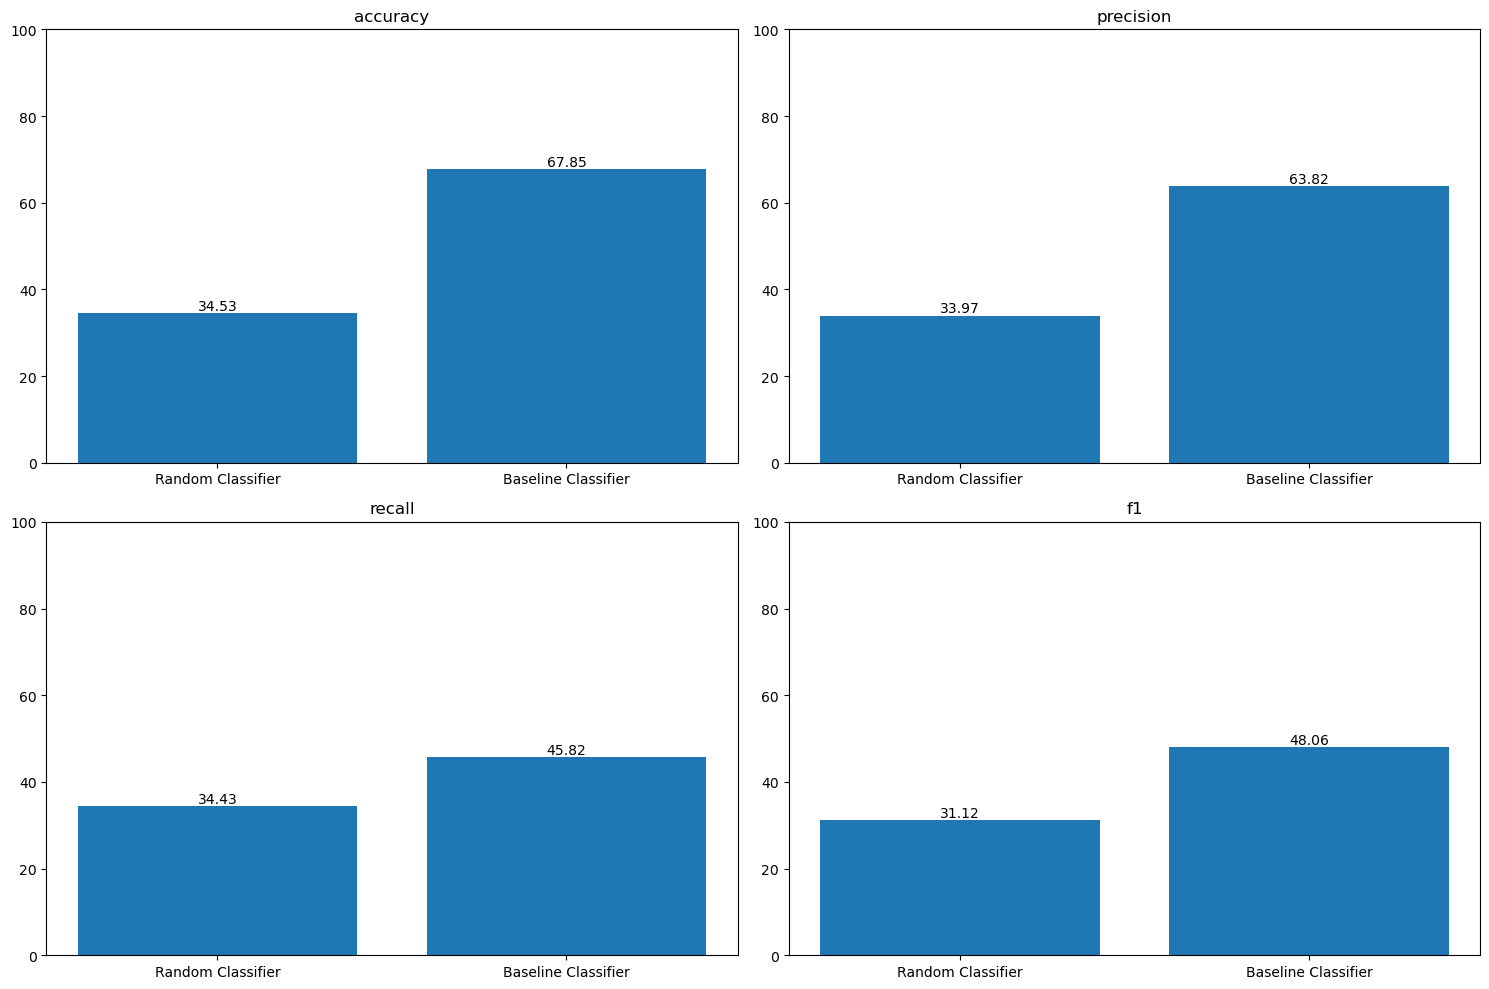

In [64]:
# # Generating predictions for train and validation datasets
train_pred_labels = get_pred_labels(df_train)
valid_pred_labels = get_pred_labels(df_val)

# Define class names for easier understanding in outputs
class_names = ['Bearish', 'Bullish', 'Neutral']

# Calculate metrics for the baseline classifier
metrics.run(df_val['label'], valid_pred_labels, "Baseline Classifier")
# Plotting the metrics
metrics.plot()

Classification Report for Baseline Classifier:
              precision    recall  f1-score   support

     Bearish       0.68      0.22      0.33       365
     Bullish       0.55      0.22      0.31       487
     Neutral       0.69      0.93      0.79      1534

    accuracy                           0.68      2386
   macro avg       0.64      0.46      0.48      2386
weighted avg       0.66      0.68      0.63      2386



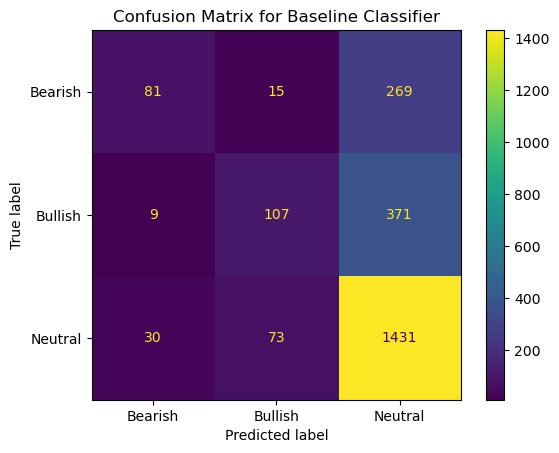

In [65]:
# Print classification report for your baseline classifier
print("Classification Report for Baseline Classifier:")
print(classification_report(df_val['label'], valid_pred_labels, target_names=class_names))

# Display confusion matrix for your baseline classifier
cm_baseline = confusion_matrix(df_val['label'], valid_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, display_labels=class_names)
disp.plot(values_format='.4g')
plt.title('Confusion Matrix for Baseline Classifier')
plt.show()


# Part 2

### BERT Model with Limited Data

We used various techniques to refine our dataset for sentiment analysis. Initially, we analyzed tweet lengths through histograms and applied Windsorizing to filter out outliers, aiming for more representative data. Despite attempts to leverage TF-IDF analysis to extract informative words for sentiment categories ('Bearish', 'Neutral', 'Bullish'), this approach did not significantly improve performance due to the limited dataset size (only 32 samples).

Comparing models, a basic TF-IDF model achieved the highest accuracy at 44.81%, indicating strong performance based on keyword frequencies. DistilBERT, with slightly lower accuracy at 43.17%, outperformed TF-IDF in recall and precision, suggesting better understanding of class examples beyond common keywords.

However, introducing an RNN layer to enhance BERT's sequence modeling did not improve performance, likely due to insufficient data for the model to learn complex patterns effectively.

In summary, while TF-IDF excelled with limited data, DistilBERT showed promise in understanding nuanced text, and RNNs highlighted the necessity of larger datasets for effective training. This underscores the importance of dataset richness in optimizing advanced models for sentiment analysis.

Selecting the 32 labelled examples.

In [66]:
df_train

,text,label,clean_text,clean_emotions,hashtag,label_names
0,Uber To Profit From Better Pricing Environment...,1,uber to profit from better pricing environment...,,,Bullish
1,Wall Street firms release their 2020 S&P 500 t...,2,wall street firms release their s & p targets,,,Neutral
2,"Stocks have given back most of their gains, an...",0,"stocks have given back most of their gains , a...",,,Bearish
3,US Gasoline Crashes To 50c - Lowest Since 2001...,0,us gasoline crashes to 5 0 c - lowest since - ...,,,Bearish
4,HPE +2% as Deutsche sees growth story,1,hpe + as deutsche sees growth story,,,Bullish
...,...,...,...,...,...,...
7152,Medtronic +2% premarket on FQ2 beat,1,medtronic + premarket on fq2 beat,,,Bullish
7153,Michael Bloomberg is joining a crowded 2020 De...,2,michael bloomberg is joining a crowded democra...,,,Neutral
7154,Canadian National Railway on watch amid strike,2,canadian national railway on watch amid strike,,,Neutral
7155,Michael Gove warns the logistics industry to p...,2,michael gove warns the logistics industry to p...,,,Neutral


In [67]:
df_bullish = df_train[df_train['label_names']=='Bearish'].reset_index()
df_neutral = df_train[df_train['label_names']=='Neutral'].reset_index()
df_bearish = df_train[df_train['label_names']=='Bullish'].reset_index()

dataframes = [df_bullish, df_neutral, df_bearish]

For this project we will simulate a situation of limited labelled data. Therefore, we will select a total of 32 labelled examples from the dataset in a balanced way. To make sure to select examples that are represeantative we will first make a small analysis of the data.

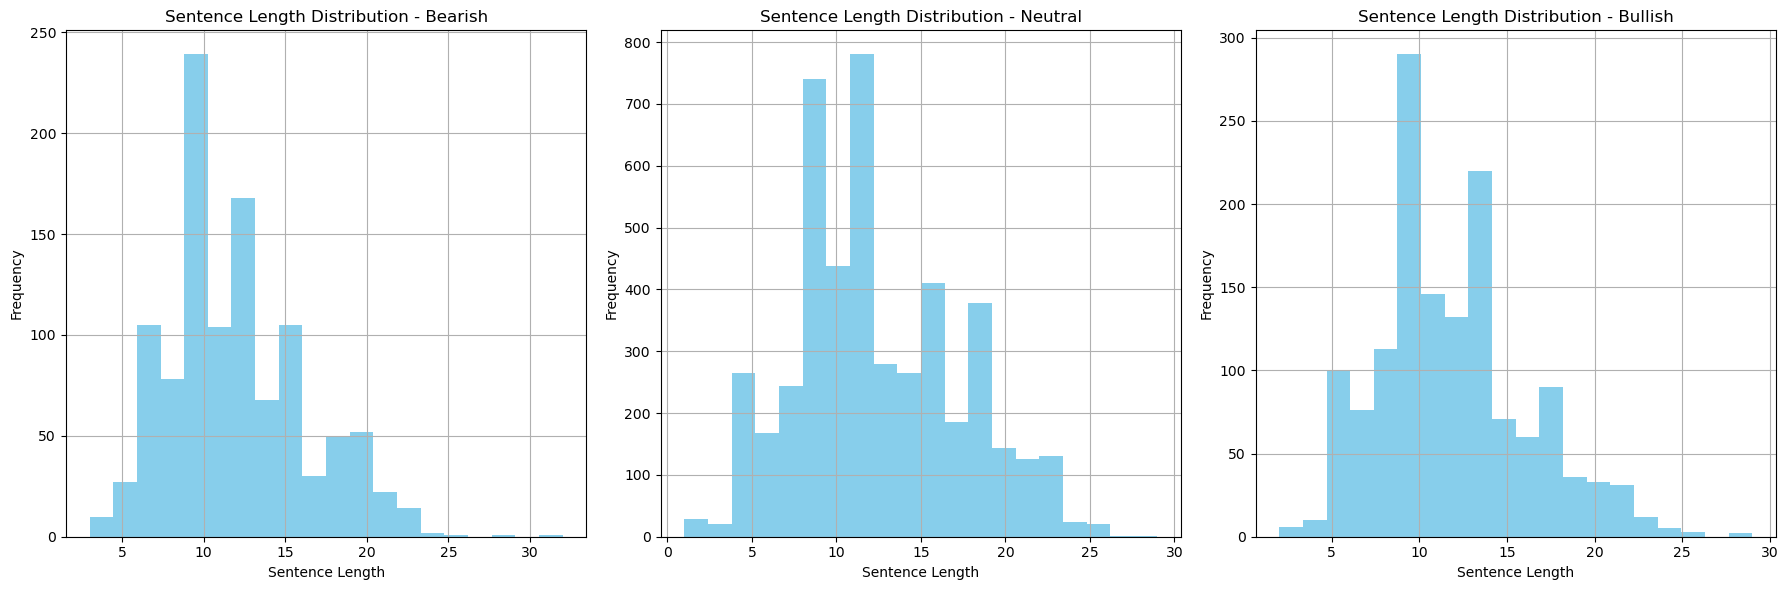

In [68]:
# Define a function to plot the distribution of sentence lengths
def plot_sentence_length_distribution(dataframe, label, ax):
    ax.hist(dataframe['text'].apply(lambda x: len(x.split())), bins=20, color='skyblue')
    ax.set_title(f'Sentence Length Distribution - {label}')
    ax.set_xlabel('Sentence Length')
    ax.set_ylabel('Frequency')
    ax.grid(True)

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot distributions for each dataframe
for df, label, ax in zip(dataframes, ['Bearish', 'Neutral', 'Bullish'], axs):
    plot_sentence_length_distribution(df, label, ax)

plt.tight_layout()
plt.show()


We can see that some examples can reach even values that are very close to 0. This will risk that we will pick examples that are not representative of the data. so we will make sure to sample from representative data using windsorizing. We created a lower bound that is close to the mean while the upper bound is higher as we assume that longer sentences can be considered informative.

In [69]:
# Define a function to filter examples close to the mean length
def filter_examples_close_to_mean(dataframe):
    mean_length = dataframe['text'].apply(lambda x: len(x.split())).mean()
    std_dev = dataframe['text'].apply(lambda x: len(x.split())).std()
    lower_bound = mean_length - 0.5 * std_dev
    upper_bound = mean_length + 2*std_dev
    filtered_df = dataframe[(dataframe['text'].apply(lambda x: len(x.split())) >= lower_bound) & 
                            (dataframe['text'].apply(lambda x: len(x.split())) <= upper_bound)].copy()
    return filtered_df

# Create copies of filtered data frames for each label
filtered_dataframes = []
for df, label in zip(dataframes, ['Bearish', 'Neutral', 'Bullish']):
    filtered_df = filter_examples_close_to_mean(df)
    filtered_dataframes.append(filtered_df)

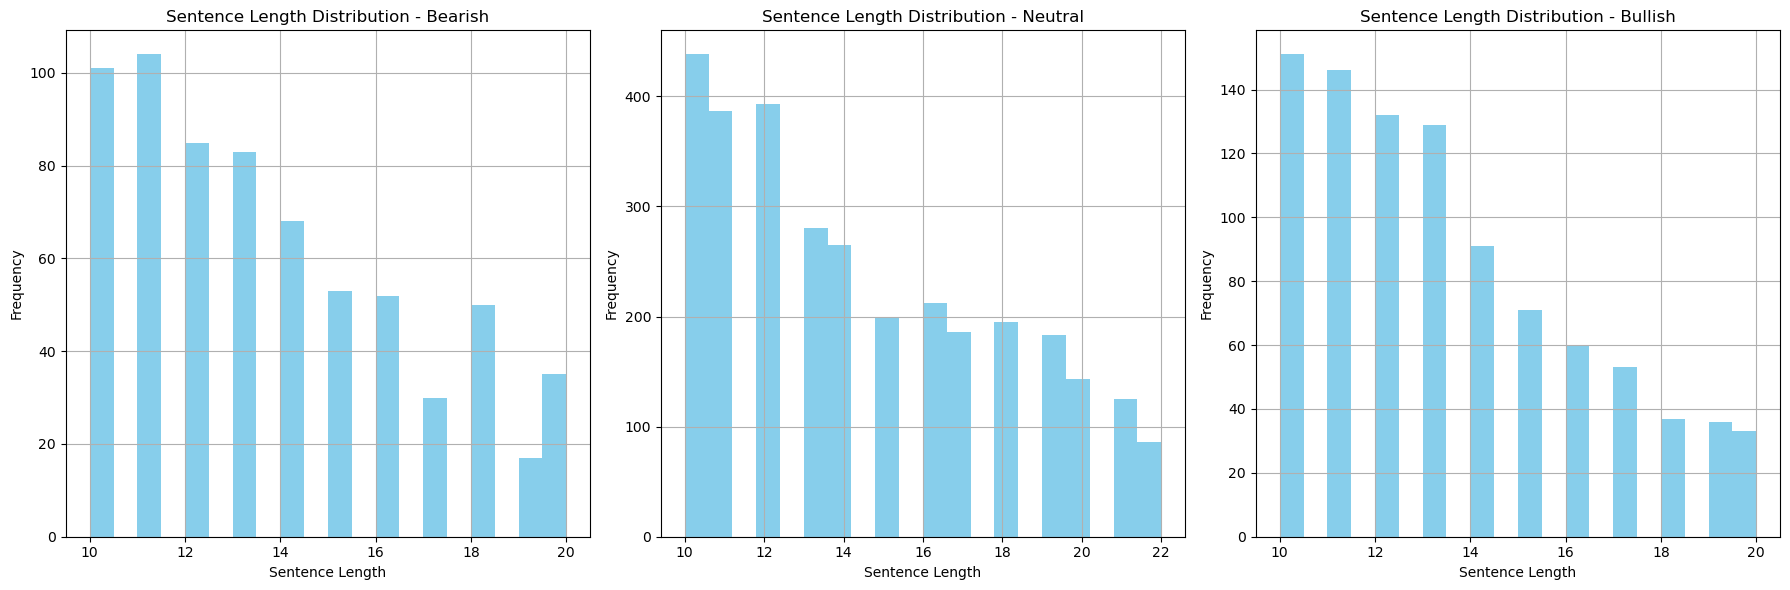

In [70]:
# Plot distributions for each filtered dataframe
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for df, label, ax in zip(filtered_dataframes, ['Bearish', 'Neutral', 'Bullish'], axs):
    plot_sentence_length_distribution(df, label, ax)

plt.tight_layout()
plt.show()

In [71]:
# Create a dictionary to store filtered data frames
filtered_dataframes_dict = {}

# Create copies of filtered data frames for each label and store them in the dictionary
for df, label in zip(filtered_dataframes, ['Bearish', 'Neutral', 'Bullish']):
    filtered_dataframes_dict[label] = df.copy()

### Picking the best examples with tf-idf feature importance

In [72]:
# # Set seed
# SEED = 42
# random.seed(SEED) 

# Create separate TF-IDF vectorizers for each category
tfidf_vectorizers = {
    'Bearish': TfidfVectorizer(ngram_range=(1, 2),
                              min_df=5,
                              stop_words='english'),
    'Bullish': TfidfVectorizer(ngram_range=(1, 2),
                              min_df=5,
                              stop_words='english'),
    'Neutral': TfidfVectorizer(ngram_range=(1, 2),
                              min_df=5,
                              stop_words='english')
}

In [73]:
# Fit and transform the data for each category
tfidf_matrices = {}
for label, df in filtered_dataframes_dict.items():
    tfidf_matrices[label] = tfidf_vectorizers[label].fit_transform(df['clean_text'])

# Get feature names and IDF scores for each category
feature_names = {}
idf_scores = {}
for label, tfidf_matrix in tfidf_matrices.items():
    feature_names[label] = tfidf_vectorizers[label].get_feature_names_out()
    idf_scores[label] = tfidf_vectorizers[label].idf_

    # Sort feature names based on IDF scores
    sorted_features = sorted(zip(feature_names[label], idf_scores[label]), key=lambda x: x[1], reverse=True)
    
    # Print top 20 features for each category
    print(f"\nTop 20 Features for {label}:")
    for feature, idf_score in sorted_features[:50]:
        print(f"{feature}: {idf_score}")        


Top 20 Features for Bearish:
according: 5.728861658330641
america: 5.728861658330641
announces: 5.728861658330641
canadian: 5.728861658330641
cannabis: 5.728861658330641
casper: 5.728861658330641
china coronavirus: 5.728861658330641
coming: 5.728861658330641
coronavirus outbreak: 5.728861658330641
daily: 5.728861658330641
december: 5.728861658330641
despite: 5.728861658330641
did: 5.728861658330641
disappointing: 5.728861658330641
dollar: 5.728861658330641
end: 5.728861658330641
equity: 5.728861658330641
exxon: 5.728861658330641
files: 5.728861658330641
flights: 5.728861658330641
hold: 5.728861658330641
hong: 5.728861658330641
hong kong: 5.728861658330641
international: 5.728861658330641
investment: 5.728861658330641
investor: 5.728861658330641
ipo: 5.728861658330641
kohl: 5.728861658330641
kong: 5.728861658330641
latest: 5.728861658330641
limited: 5.728861658330641
loan: 5.728861658330641
london: 5.728861658330641
lowe: 5.728861658330641
lows: 5.728861658330641
month low: 5.728861658

In [74]:
# Define a function to calculate the score for each example based on the number of top features it contains
def calculate_scores(tfidf_matrix, top_features_indices):
    # Calculate the score for each example based on the number of top features it contains
    scores = tfidf_matrix[:, top_features_indices].sum(axis=1)
    return scores

# Iterate over each category
for label, tfidf_matrix in tfidf_matrices.items():
    
    feature_names[label] = tfidf_vectorizers[label].get_feature_names_out()
    idf_scores[label] = tfidf_vectorizers[label].idf_

    # Sort feature names based on IDF scores
    sorted_features = sorted(zip(feature_names[label], idf_scores[label]), key=lambda x: x[1], reverse=True)
    
    # Get indices of the top 20 features for the current category
    top_features_indices = [tfidf_vectorizers[label].vocabulary_[feature] for feature, _ in sorted_features[:50]]
    
    # Calculate scores for each example in the current category
    scores = calculate_scores(tfidf_matrix, top_features_indices)
    
    # Add scores as a column to the dataframe
    filtered_dataframes_dict[label]['score'] = scores
    
    # Sort the dataframe based on scores
    filtered_dataframes_dict[label] = filtered_dataframes_dict[label].sort_values(by='score', ascending=False)
    
    # Remove duplicates from dataframes so the same sentences are not used twice
    filtered_dataframes_dict[label] = filtered_dataframes_dict[label].drop_duplicates()
    
    # Select 11 from Bearish, 11 from Bullish, and 10 from Neutral
    if label == 'Bearish':
        subset_bear_tfidf = filtered_dataframes_dict[label].head(11)
    elif label == 'Bullish':
        subset_bull_tfidf = filtered_dataframes_dict[label].head(11)
    elif label == 'Neutral':
        subset_neutral_tfidf = filtered_dataframes_dict[label].head(10)

Mention the fact that we didn't use this previous code block

In [75]:
# Create separate dataframes from the dictionary based on their keys
df_filtered_bearish = filtered_dataframes_dict['Bearish']
df_filtered_bullish = filtered_dataframes_dict['Bullish']
df_filtered_neutral = filtered_dataframes_dict['Neutral']


Accessing the single dataframes we can see that the length of the data has decreased

In [76]:
subset_bull = df_filtered_bullish.sample(n=11)
subset_bear = df_filtered_bearish.sample(n=11)
subset_neutral = df_filtered_neutral.sample(n=10)

train = pd.concat([subset_bull, subset_bear, subset_neutral])
train = train.sample(frac=1).reset_index(drop = True)

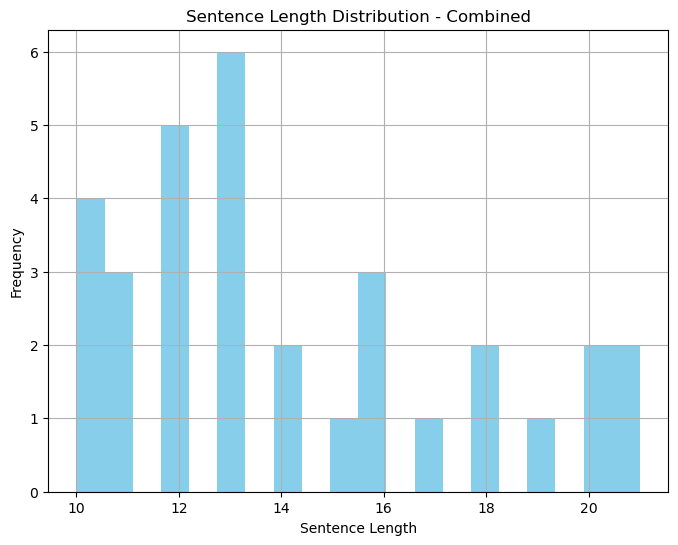

In [77]:
def plot_sentence_length_distribution(dataframe, label):
    plt.figure(figsize=(8, 6))
    plt.hist(dataframe['text'].apply(lambda x: len(x.split())), bins=20, color='skyblue')
    plt.title(f'Sentence Length Distribution - {label}')
    plt.xlabel('Sentence Length')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Plot the distribution of lengths in the new data frame 'train'
plot_sentence_length_distribution(train, "Combined")

We can see from the plot that all the selected values have reasonable lengths.

In [78]:
X_train = np.array(train['text'])
X_labels = train['label']

### Baseline Model

In [79]:
# Create a pipeline with TF-IDF and Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2),
                              min_df=5,
                              stop_words='english')),
    ('clf', LogisticRegression(solver='liblinear')),
])

# Fit the pipeline on the training text
pipeline.fit(X_train, X_labels)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=5, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf', LogisticRegression(solver='liblinear'))])

Predict on test data.

In [80]:
X_test = np.array(df_test['clean_text'])
X_test_labels = np.array(df_test['label'])


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


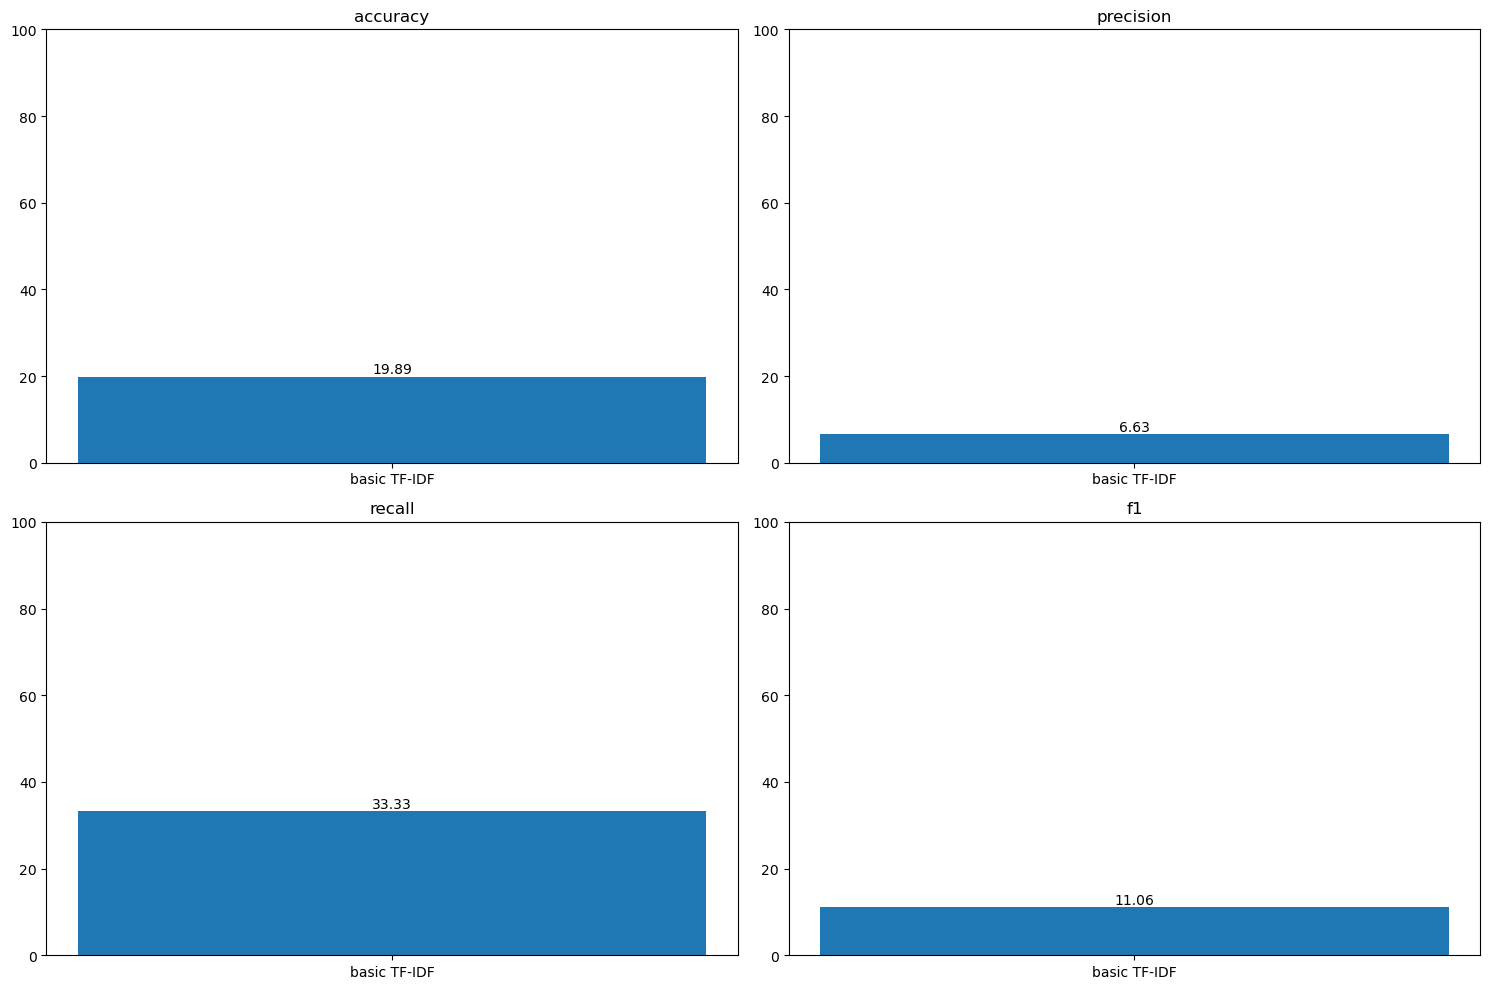

In [81]:
test_preds = pipeline.predict(X_test)

metrics_val= Metrics()
metrics_val.run(X_test_labels, test_preds, "basic TF-IDF")
metrics_val.plot()

In [82]:
from transformers import AutoTokenizer, TFAutoModel

checkpoint="distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModel.from_pretrained(checkpoint)

batch_size=32
max_length=32
rate = 0.5
num_labels = len(np.unique(X_labels))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


### Defining Bert Model

In [56]:
# Defining inputs
input_ids_in = tf.keras.layers.Input(shape=(max_length,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(max_length,), name='masked_token', dtype='int32')

# Embedding layers with BERT model
embedding_layer = model(input_ids=input_ids_in, attention_mask=input_masks_in)
# Extracting only the last layer from the BERT embeddings
final_embedding_layer = embedding_layer[0]
# Extract only the [CLS] token's embeddings
cls_token_embeddings = final_embedding_layer[:, 0, :]

# Adding Dropout to reduce overfitting
output_layer = tf.keras.layers.Dropout(rate, name='do_layer')(cls_token_embeddings)

# One dense layer to process the last layer
output = tf.keras.layers.Dense(num_labels,
                               kernel_initializer="glorot_uniform",
                               activation='softmax')(output_layer)

bert_model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 32)]                 0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 32)]                 0         []                            
                                                                                                  
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_hid   6636288   ['input_token[0][0]',         
 stilBertModel)              den_state=(None, 32, 768),   0          'masked_token[0][0]']        
                              hidden_states=None, atten                                           
                             tions=None)                                                      

In [57]:
def get_batches(X_train, y_train, tokenizer, batch_size, max_length):
    """
    Objective: Create a generator that yields batches of tokenized text and corresponding labels.
               The data is shuffled and looped through indefinitely.

    Inputs:
        - X_train (np.array): Array of text data (features).
        - y_train (np.array): Array of labels.
        - tokenizer (DistilBertTokenizer): Tokenizer for text data.
        - batch_size (int): Size of each batch.
        - max_length (int): Maximum length of tokenized sequences.
    Outputs:
        - Generator yielding batches of (inputs, targets).
    """
    
    # Pre-tokenize the entire dataset
    inputs = tokenizer.batch_encode_plus(list(X_train), add_special_tokens=True, max_length=max_length,
                                         padding='max_length', return_attention_mask=True,
                                         return_token_type_ids=True, truncation=True,
                                         return_tensors="np")

    input_ids = np.asarray(inputs['input_ids'], dtype='int32')
    attention_masks = np.asarray(inputs['attention_mask'], dtype='int32')

    # Shuffle and yield batches
    while True:
        X_train, y_train, input_ids, attention_masks = shuffle(X_train, y_train, input_ids, attention_masks, random_state=11)

        for i in range(0, len(X_train), batch_size):
            yield [input_ids[i:i + batch_size], attention_masks[i:i + batch_size]], y_train[i:i + batch_size]

Fitting the model.

In [304]:
# X_train = np.array(train['text'])
# X_labels = train['label']

# enc = OneHotEncoder(handle_unknown='ignore')
# y_train = enc.fit_transform(np.array(X_labels).reshape(-1, 1)).toarray()

# steps_per_epoch = int(len(X_train) / batch_size)

# batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

# bert_model.compile(optimizer=Adam(2e-5),
#                    metrics=[tf.keras.metrics.Recall(),
#                    tf.keras.metrics.Precision()],
#                    loss=tf.keras.losses.CategoricalCrossentropy())

# bert_model.fit(batches, epochs=10, steps_per_epoch=steps_per_epoch)

Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 1.1975 - recall_5: 0.2500 - precision_5: 0.3810
Epoch 2/10
1/1 [==============================] - 1s 874ms/step - loss: 1.1668 - recall_5: 0.2188 - precision_5: 0.3684
Epoch 3/10
1/1 [==============================] - 1s 787ms/step - loss: 1.0854 - recall_5: 0.1875 - precision_5: 0.4286
Epoch 4/10
1/1 [==============================] - 1s 921ms/step - loss: 1.1263 - recall_5: 0.0938 - precision_5: 0.2500
Epoch 5/10
1/1 [==============================] - 1s 788ms/step - loss: 1.1082 - recall_5: 0.1875 - precision_5: 0.4286
Epoch 6/10
1/1 [==============================] - 1s 785ms/step - loss: 1.0128 - recall_5: 0.2500 - precision_5: 0.5333
Epoch 7/10
1/1 [==============================] - 1s 771ms/step - loss: 1.0688 - recall_5: 0.2188 - precision_5: 0.5000
Epoch 8/10
1/1 [==============================] - 1s 924ms/step - loss: 0.7825 - recall_5: 0.5000 - precision_5: 0.8000
Epoch 9/10
1/1 [===========================

Saving the weights of the trained model.

In [58]:
# # Save the weights
# bert_model.save_weights('./bert_model_weights.h5')
bert_model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)
# Load the weights
bert_model.load_weights('./bert_model_weights.h5')

Making predicitons on the test data and comparing results with the baseline TF-IDF model.

75/75 [==============================] - 22s 290ms/step


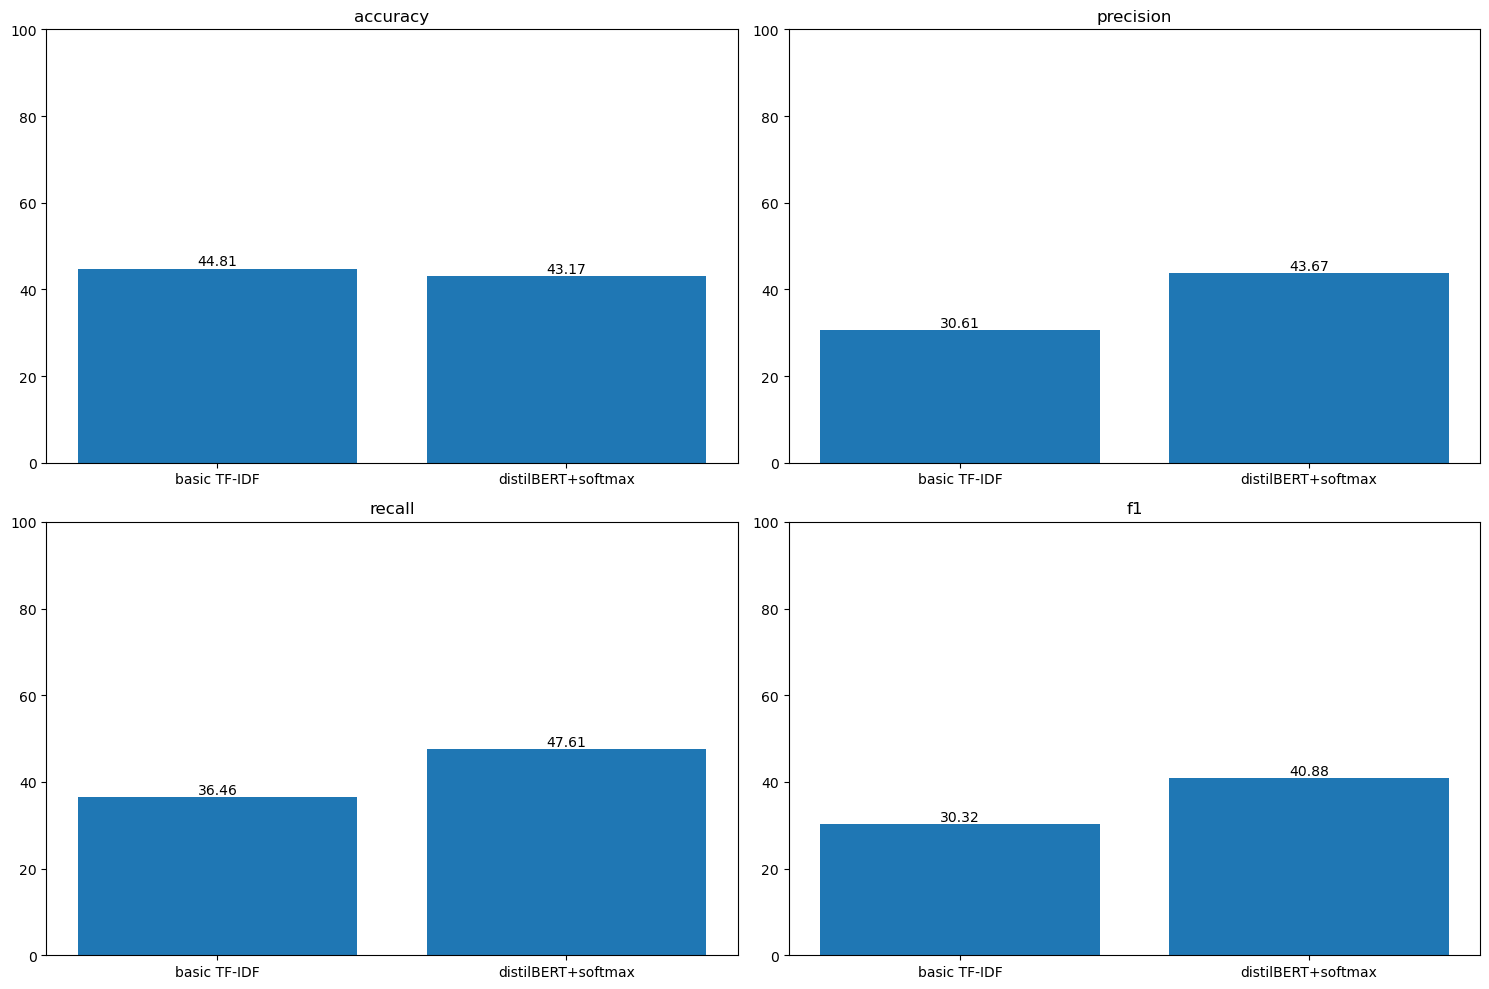

In [59]:
# Get the inputs tokenized from the test set
inputs = tokenizer.batch_encode_plus(list(X_test),
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_test = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]
test_preds = bert_model.predict(inputs_test)

test_preds = np.argmax(test_preds, axis=1)

# get the final metrics
metrics_val.run(X_test_labels, test_preds, "distilBERT+softmax")
metrics_val.plot()

Predictions of BERT are consistently higher than the baseline.

### Adding an RNN layer on top of BERT

In [60]:
# Defining the inputs for the model
input_ids_in = tf.keras.layers.Input(shape=(max_length,), name = 'Input token', dtype = 'int32')
input_masks_in = tf.keras.layers.Input(shape=(max_length,), name = 'Input masks', dtype = 'int32')

# Defining the BERT embedding layer
embedding_layer = model(input_ids=input_ids_in, attention_mask=input_masks_in)

# Taking the full sequence in the final layer as the input for the RNN
sequence_embeddings = embedding_layer[0]

# Regularizing using Dropout
dropout = tf.keras.layers.Dropout(rate=rate, name='Dropout')(sequence_embeddings)

# Adding the RNN model
rnn_layer = tf.keras.layers.LSTM(units = 128)(dropout)


#Adding the final Dense layer with a Softmax activaiton
output_layer = tf.keras.layers.Dense(num_labels,
                               kernel_initializer="glorot_uniform",
                               activation='softmax')(rnn_layer)

rnn_model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output_layer)

# Display the model summary
rnn_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input token (InputLayer)    [(None, 32)]                 0         []                            
                                                                                                  
 Input masks (InputLayer)    [(None, 32)]                 0         []                            
                                                                                                  
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_hid   6636288   ['Input token[0][0]',         
 stilBertModel)              den_state=(None, 32, 768),   0          'Input masks[0][0]']         
                              hidden_states=None, atten                                           
                             tions=None)                                                    

In [63]:
enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(np.array(X_labels).reshape(-1, 1)).toarray()

X_train = np.array(X_train)


steps_per_epoch = int(len(X_train) / batch_size)

batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

rnn_model.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                   tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

rnn_model.fit(batches, epochs=10, steps_per_epoch=steps_per_epoch)

Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 1.0891 - recall: 0.0312 - precision: 0.5000
Epoch 2/10
1/1 [==============================] - 1s 856ms/step - loss: 0.9816 - recall: 0.0938 - precision: 1.0000
Epoch 3/10
1/1 [==============================] - 1s 856ms/step - loss: 0.9135 - recall: 0.1562 - precision: 0.7143
Epoch 4/10
1/1 [==============================] - 1s 944ms/step - loss: 0.8581 - recall: 0.2188 - precision: 1.0000
Epoch 5/10
1/1 [==============================] - 1s 962ms/step - loss: 0.8283 - recall: 0.3125 - precision: 0.7692
Epoch 6/10
1/1 [==============================] - 1s 825ms/step - loss: 0.7493 - recall: 0.4375 - precision: 0.9333
Epoch 7/10
1/1 [==============================] - 1s 828ms/step - loss: 0.7096 - recall: 0.5625 - precision: 0.9000
Epoch 8/10
1/1 [==============================] - 1s 848ms/step - loss: 0.6150 - recall: 0.7812 - precision: 1.0000
Epoch 9/10
1/1 [==============================] - 1s 989ms/step - loss: 0.5

In [65]:
# # Save the weights
# rnn_model.save_weights('./rnn_model_weights.h5')
# rnn_model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)
# Load the weights
rnn_model.load_weights('./rnn_model_weights.h5')

75/75 [==============================] - 22s 286ms/step


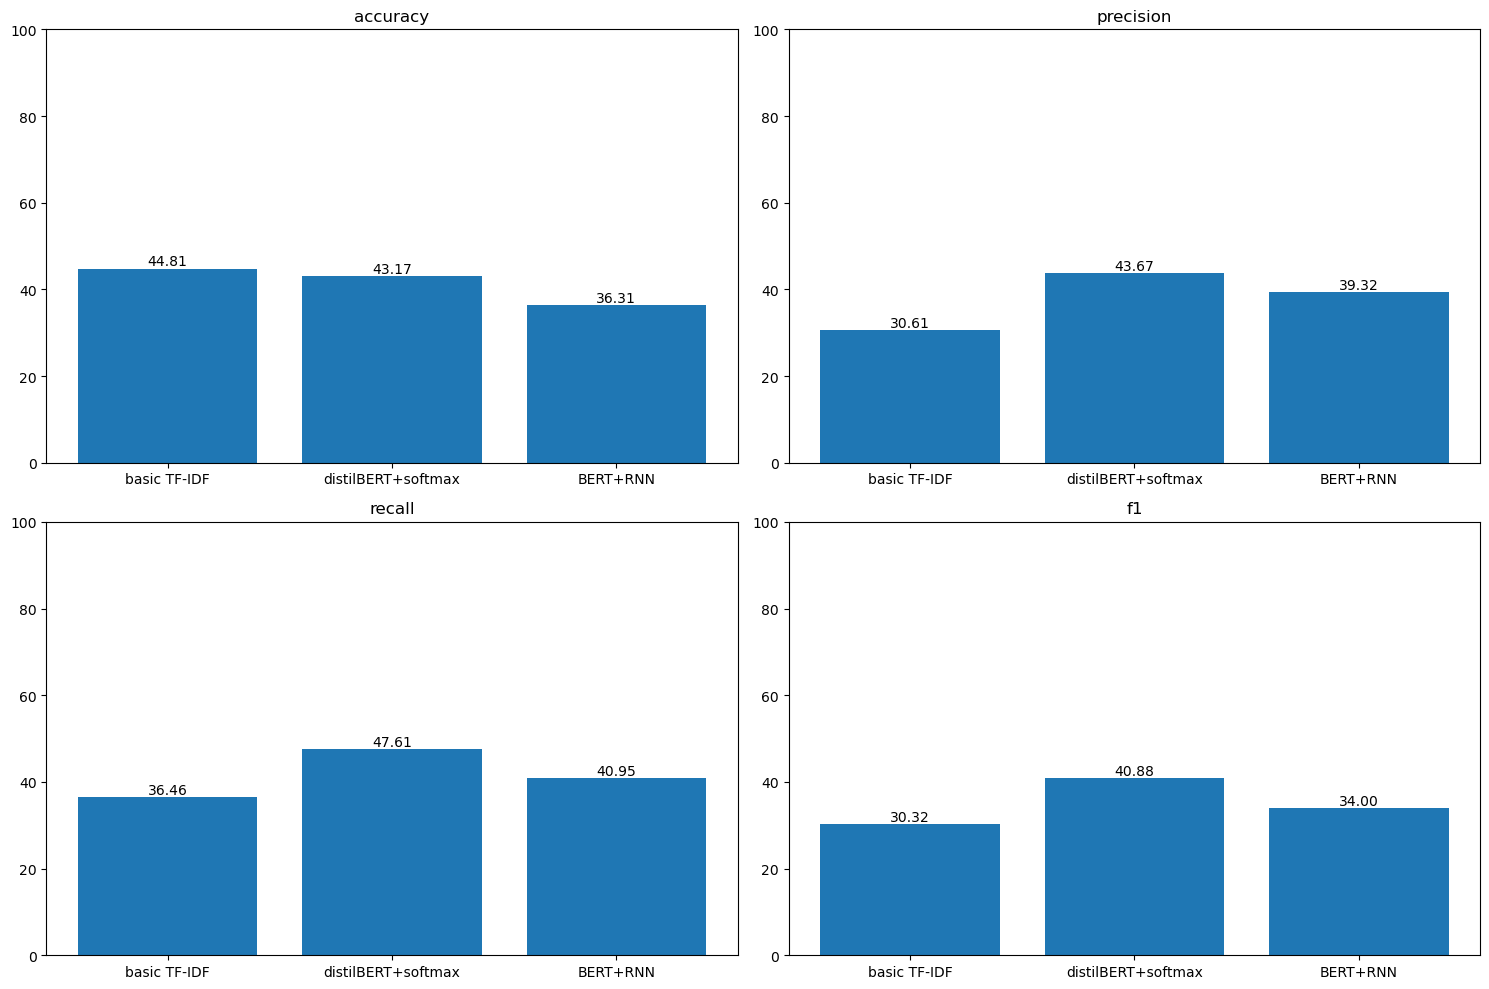

In [64]:
# Get the inputs tokenized from the test set
inputs = tokenizer.batch_encode_plus(list(X_test),
                                    add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_test = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]
test_preds = rnn_model.predict(inputs_test)
test_preds = np.argmax(test_preds, axis=1)

# get the final metrics
metrics_val.run(X_test_labels, test_preds, "BERT+RNN")
metrics_val.plot()

## Data Augmentation
We explored data augmentation techniques to expand our small dataset of 32 examples and enhance model performance.

One techniques involved:
- translation and backtranslation of English text using a translation library, introducing structural variations while preserving meaning.
- Word2Vec to replace words with synonyms, creating new sentences with varied vocabulary but consistent context.
- random word swapping
- synonym replacement with NLTK's wordnet set altered sentence structure while maintaining sentiment.

Implementing these techniques significantly improved our model's accuracy to 48.16% (from 43.17% with DistilBERT+softmax), with precision at 46.91% and recall at 50.35%. The F1 score rose to 43.59%, demonstrating balanced improvements in precision and recall.

These methods expanded our dataset and diversified training examples, crucial for training robust natural language processing models. Each technique introduced linguistic variance, aiding model generalization and preventing overfitting.

In [146]:
train = train.drop(columns=['index', 'clean_emotions', 'hashtag', 'score'])

### Translating and backtranslating using translate library

In [66]:
from translate import Translator

# Define the translation function
def translate_text(text, src_lang, target_lang):
    translator = Translator(to_lang=target_lang, from_lang=src_lang)
    translated = translator.translate(text)
    return translated

In [141]:
src_lang = 'en'  # Source language
target_lang = 'fr'  # Target language for translation

# Translate each text sample in the 'clean_text' column
translated_texts = [translate_text(text, 'en', 'fr') for text in train['clean_text']]

# Apply back translation to each translated text sample
back_translated_texts = [translate_text(text, 'fr', 'en') for text in translated_texts]

# Create a new DataFrame for the translated data
translated_train = pd.DataFrame({'text': back_translated_texts, 'clean_text': back_translated_texts,'label': train['label']})

label_map = {0: 'Bearish', 1: 'Bullish', 2: 'Neutral'}
translated_train['label_names'] = translated_train['label'].map(label_map)
display(translated_train)

,text,clean_text,label,label_names
0,MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE ...,MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE ...,0,Bearish
1,MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE ...,MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE ...,1,Bullish
2,MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE ...,MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE ...,2,Neutral
3,MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE ...,MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE ...,2,Neutral
4,MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE ...,MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE ...,2,Neutral
5,MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE ...,MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE ...,2,Neutral
6,MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE ...,MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE ...,0,Bearish
7,MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE ...,MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE ...,0,Bearish
8,MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE ...,MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE ...,1,Bullish
9,MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE ...,MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE ...,0,Bearish


### Word2Vec

In [67]:
# Download the model
word2vec_model = api.load("word2vec-google-news-300")

# Check that it's been downloaded
print(word2vec_model)

KeyedVectors<vector_size=300, 3000000 keys>


In [68]:
# Define a function to find similar words for each word in the text
def find_similar_words(text, model, topn=5):
    similar_words = []
    tokens = word_tokenize(text)  # Tokenize the text
    for token in tokens:
        if token.lower() in model.key_to_index:  # Check if the token is in the vocabulary
            similar = model.most_similar(token.lower(), topn=topn)  # Find similar words
            similar_words.append({token: [word for word, _ in similar]})  # Append similar words to the list
    return similar_words

In [69]:
word2vec_train_four = train.copy()
word2vec_train_four['recreated_text'] = train['clean_text'].apply(lambda x: find_similar_words(x, word2vec_model))

In [70]:
def modify_sentences(recreated_text, min_mods):
    modified_sentences = []
    for row in recreated_text:
        modified_sentence = []
        modified_indices = set()
        # Randomly select 3 unique indices
        while len(modified_indices) < min(min_mods, len(row)):
            modified_indices.add(random.randint(0, len(row)-1))
        
        for i, word_dict in enumerate(row):
            key = list(word_dict.keys())[0]
            similar_words = word_dict[key]
            if i in modified_indices and similar_words:
                # Select a random similar word
                modified_sentence.append(random.choice(similar_words))
            else:
                modified_sentence.append(key)  # Keep the original word if not selected for modification
        modified_sentences.append(modified_sentence)
    
    # Join the modified words into sentences
    modified_sentences = [' '.join(sentence) for sentence in modified_sentences]

    return modified_sentences

### 4 modifications

In [71]:
word2vec_train_four = train.copy()
word2vec_train_four['recreated_text'] = train['clean_text'].apply(lambda x: find_similar_words(x, word2vec_model))

modified_text_four = modify_sentences(word2vec_train_four['recreated_text'], 4)

In [72]:
word2vec_train_four['text'] = modified_text_four
word2vec_train_four['clean_text'] = modified_text_four
word2vec_train_four = word2vec_train_four.drop(columns=['recreated_text'])
display(word2vec_train_four)

,index,text,label,clean_text,clean_emotions,hashtag,label_names,score
0,3419,million pre holdings announces for reverse sto...,0,million pre holdings announces for reverse sto...,,,Bearish,0.000000
1,5372,microsoft just launched its newly Keroro lens ...,2,microsoft just launched its newly Keroro lens ...,,HoloLens2,Neutral,0.000000
2,3006,Lisa_Ashkenaz_Croke down off extending timelin...,0,Lisa_Ashkenaz_Croke down off extending timelin...,,,Bearish,0.000000
3,6823,chinaware broke cut tariffs On in import by,1,chinaware broke cut tariffs On in import by,,,Bullish,0.000000
4,6410,Stock price targeted slashed vs At,0,Stock price targeted slashed vs At,,,Bearish,0.000000
5,4919,what many tops oil stocks all tumbled More tha...,0,what many tops oil stocks all tumbled More tha...,,,Bearish,0.000000
6,2877,crude gas slides before pleasant_surprise buil...,0,crude gas slides before pleasant_surprise buil...,,,Bearish,0.000000
7,7036,goldman jessie energy renaissance funds procla...,2,goldman jessie energy renaissance funds procla...,,,Neutral,0.000000
8,5714,pharmaceutical Launching equity offered Americ...,0,pharmaceutical Launching equity offered Americ...,,,Bearish,0.399740
9,2251,says she plans oppose bungalow speaker jensen ...,2,says she plans oppose bungalow speaker jensen ...,,,Neutral,0.647564


### 3 modifications

In [73]:
word2vec_train_three = train.copy()
word2vec_train_three['recreated_text'] = train['clean_text'].apply(lambda x: find_similar_words(x, word2vec_model))

modified_text_three = modify_sentences(word2vec_train_three['recreated_text'], 3)

In [74]:
word2vec_train_three['text'] = modified_text_three
word2vec_train_three['clean_text'] = modified_text_three
word2vec_train_three = word2vec_train_three.drop(columns=['recreated_text'])
display(word2vec_train_three)

,index,text,label,clean_text,clean_emotions,hashtag,label_names,score
0,3419,$ pre holdings announces for reverse Stock spl...,0,$ pre holdings announces for reverse Stock spl...,,,Bearish,0.000000
1,5372,microsoft just launched its new holo camera_le...,2,microsoft just launched its new holo camera_le...,,HoloLens2,Neutral,0.000000
2,3006,bio down on Extended timeframe for SUV t candi...,0,bio down on Extended timeframe for SUV t candi...,,,Bearish,0.000000
3,6823,crockery set cut tariffs on In imports bythe,1,crockery set cut tariffs on In imports bythe,,,Bullish,0.000000
4,6410,stock price targetted Cut vs At,0,stock price targetted Cut vs At,,,Bearish,0.000000
5,4919,why These top oil stocks All slumped more than...,0,why These top oil stocks All slumped more than...,,,Bearish,0.000000
6,2877,crude_oil oil slides after shocker build in st...,0,crude_oil oil slides after shocker build in st...,,,Bearish,0.000000
7,7036,goldman sachs energy revival fund proclaimed d...,2,goldman sachs energy revival fund proclaimed d...,,,Neutral,0.000000
8,5714,pharma launches equity Offering shares down fo...,0,pharma launches equity Offering shares down fo...,,,Bearish,0.399740
9,2251,says she planned oppose bedroom soundscience_3...,2,says she planned oppose bedroom soundscience_3...,,,Neutral,0.647564


### Random swap

In [75]:
def random_swap(text, n=3):
    words = text.split()
    new_words = words.copy()
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(words)), 2)
        new_words[idx1], new_words[idx2] = new_words[idx2], new_words[idx1]
    return ' '.join(new_words)

##### 3 swaps

In [76]:
random_swapped = {}
for text, label in zip(train['clean_text'], train['label']):
    if text is not None:
        augmented_text = random_swap(text, 3)
        if augmented_text is not None:
            random_swapped[augmented_text] = label
            # print(label)
            # print("Original Text:", text)
            # print("Augmented Text:", augmented_text)

label_map = {0: 'Bearish', 1: 'Bullish', 2: 'Neutral'}
swapped_train_three = train.copy()
swapped_train_three['label'] = random_swapped.values()
swapped_train_three['clean_text'] = random_swapped.keys()
swapped_train_three['label_names'] = swapped_train_three['label'].map(label_map)


##### 5 swaps

In [77]:
random_swapped = {}
for text, label in zip(train['clean_text'], train['label']):
    if text is not None:
        augmented_text = random_swap(text, 5)
        if augmented_text is not None:
            random_swapped[augmented_text] = label
            # print(label)
            # print("Original Text:", text)
            # print("Augmented Text:", augmented_text)

label_map = {0: 'Bearish', 1: 'Bullish', 2: 'Neutral'}
swapped_train_five = train.copy()
swapped_train_five['label'] = random_swapped.values()
swapped_train_five['clean_text'] = random_swapped.keys()
swapped_train_five['label_names'] = swapped_train_five['label'].map(label_map)


#### Synonym replacement

In [78]:
import nltk
from nltk.corpus import wordnet
import random

nltk.download('wordnet')

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return list(synonyms)

def synonym_replacement(text, n=2):
    words = text.split()
    new_words = words.copy()
    for _ in range(n):
        for i, word in enumerate(words):
            synonyms = get_synonyms(word)
            if synonyms:
                synonym = random.choice(synonyms)
                new_words[i] = synonym
    return ' '.join(new_words)

[nltk_data] Downloading package wordnet to /Users/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


##### 2 replacements

In [79]:
synonymed_text = {}
for text, label in zip(train['clean_text'],train['label']) :
    if text is not None:
        augmented_text = synonym_replacement(text, 2)
        if augmented_text is not None:
            synonymed_text[augmented_text] = label
            # print(label)
            # print("Original Text:", text)
            # print("Augmented Text:", augmented_text)

label_map = {0: 'Bearish', 1: 'Bullish', 2: 'Neutral'}
synonym_train_two = train.copy()
synonym_train_two['label'] = synonymed_text.values()
synonym_train_two['clean_text'] = synonymed_text.keys()
synonym_train_two['label_names'] = synonym_train_two['label'].map(label_map)

##### 3 replacements

In [80]:
synonymed_text = {}
for text, label in zip(train['clean_text'],train['label']) :
    if text is not None:
        augmented_text = synonym_replacement(text, 3)
        if augmented_text is not None:
            synonymed_text[augmented_text] = label
            # print(label)
            # print("Original Text:", text)
            # print("Augmented Text:", augmented_text)

label_map = {0: 'Bearish', 1: 'Bullish', 2: 'Neutral'}
synonym_train_three = train.copy()
synonym_train_three['label'] = synonymed_text.values()
synonym_train_three['clean_text'] = synonymed_text.keys()
synonym_train_three['label_names'] = synonym_train_three['label'].map(label_map)

In [81]:
# Augmented train dataset (including translation)
augmented_train = pd.concat([train,synonym_train_two,synonym_train_three,swapped_train_five, swapped_train_three, word2vec_train_four, word2vec_train_three, translated_train], axis = 0)
# augmented_train = pd.concat([train,synonym_train_two,synonym_train_three,swapped_train_five, swapped_train_three, word2vec_train_four, word2vec_train_three], axis = 0)
augmented_train

,index,text,label,clean_text,clean_emotions,hashtag,label_names,score
0,3419,$AMRH (-8.7% pre) AMERI Holdings (AMRH) Announ...,0,$amrh ( - pre ) ameri holdings ( amrh ) announ...,,,Bearish,0.000000
1,5372,Microsoft just launched its new #HoloLens2 aug...,2,microsoft just launched its new holo lens 2 au...,,HoloLens2,Neutral,0.000000
2,3006,Anixa Bio down 16% on extended timeline for CA...,0,anixa bio down on extended timeline for car t ...,,,Bearish,0.000000
3,6823,China set to cut tariffs on $75B in U.S. impor...,1,china set to cut tariffs on in u.s. imports by,,,Bullish,0.000000
4,6410,Lovesac stock price target cut to $28 vs. $33 ...,0,lovesac stock price target cut to vs . at cana...,,,Bearish,0.000000
...,...,...,...,...,...,...,...,...
27,6634,old dominion freight line reports fourth quart...,2,old dominion freight line reports fourth quart...,,,Neutral,0.459357
28,58,did yourself know black friday starts today ce...,2,did yourself know black friday starts today ce...,,,Neutral,0.388103
29,3789,s stock soars afer billon sale federal PETER_P...,1,s stock soars afer billon sale federal PETER_P...,,,Bullish,0.000000
30,658,bumble bees foods filed for bankruptcy blaming...,0,bumble bees foods filed for bankruptcy blaming...,,,Bearish,0.000000


### Training a model with the augmented data

In [82]:
from transformers import AutoTokenizer, TFAutoModel

checkpoint="distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModel.from_pretrained(checkpoint)

batch_size=32
max_length=32
rate = 0.5
num_labels = len(np.unique(X_test_labels))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [83]:
# Defining inputs
input_ids_in = tf.keras.layers.Input(shape=(max_length,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(max_length,), name='masked_token', dtype='int32')

# Embedding layers with BERT model
embedding_layer = model(input_ids=input_ids_in, attention_mask=input_masks_in)
# Extracting only the last layer from the BERT embeddings
final_embedding_layer = embedding_layer[0]
# Extract only the [CLS] token's embeddings
cls_token_embeddings = final_embedding_layer[:, 0, :]

# Adding Dropout to reduce overfitting
output_layer = tf.keras.layers.Dropout(rate, name='do_layer')(cls_token_embeddings)

# One dense layer to process the last layer
output = tf.keras.layers.Dense(num_labels,
                               kernel_initializer="glorot_uniform",
                               activation='softmax')(output_layer)

bert_augmented = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)
bert_augmented.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 32)]                 0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 32)]                 0         []                            
                                                                                                  
 tf_distil_bert_model_1 (TF  TFBaseModelOutput(last_hid   6636288   ['input_token[0][0]',         
 DistilBertModel)            den_state=(None, 32, 768),   0          'masked_token[0][0]']        
                              hidden_states=None, atten                                           
                             tions=None)                                                    

In [186]:
# X_train = np.array(augmented_train['text'])
# X_labels = np.array(augmented_train['label'])

# enc = OneHotEncoder(handle_unknown='ignore')
# y_train = enc.fit_transform(np.array(X_labels).reshape(-1, 1)).toarray()

# steps_per_epoch = int(len(X_train) / batch_size)

# batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

# bert_augmented.compile(optimizer=Adam(2e-5),
#                    metrics=[tf.keras.metrics.Recall(),
#                    tf.keras.metrics.Precision()],
#                    loss=tf.keras.losses.CategoricalCrossentropy())

# bert_augmented.fit(batches, epochs=10, steps_per_epoch=steps_per_epoch)

Epoch 1/10
7/7 [==============================] - 12s 923ms/step - loss: 1.1296 - recall_3: 0.1875 - precision_3: 0.4078
Epoch 2/10
7/7 [==============================] - 7s 936ms/step - loss: 0.9284 - recall_3: 0.3705 - precision_3: 0.6975
Epoch 3/10
7/7 [==============================] - 7s 939ms/step - loss: 0.6048 - recall_3: 0.6518 - precision_3: 0.8295
Epoch 4/10
7/7 [==============================] - 7s 930ms/step - loss: 0.3115 - recall_3: 0.8750 - precision_3: 0.9608
Epoch 5/10
7/7 [==============================] - 6s 922ms/step - loss: 0.1104 - recall_3: 0.9732 - precision_3: 0.9864
Epoch 6/10
7/7 [==============================] - 7s 1000ms/step - loss: 0.0346 - recall_3: 0.9955 - precision_3: 0.9955
Epoch 7/10
7/7 [==============================] - 6s 918ms/step - loss: 0.0126 - recall_3: 1.0000 - precision_3: 1.0000
Epoch 8/10
7/7 [==============================] - 6s 879ms/step - loss: 0.0125 - recall_3: 0.9955 - precision_3: 0.9955
Epoch 9/10
7/7 [======================

Saving weights.

In [84]:
# # Save the weights
# bert_augmented.save_weights('./bert_augmented_weights.h5')
bert_augmented = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)
# Load the weights
bert_augmented.load_weights('./bert_augmented_weights.h5')

75/75 [==============================] - 19s 250ms/step


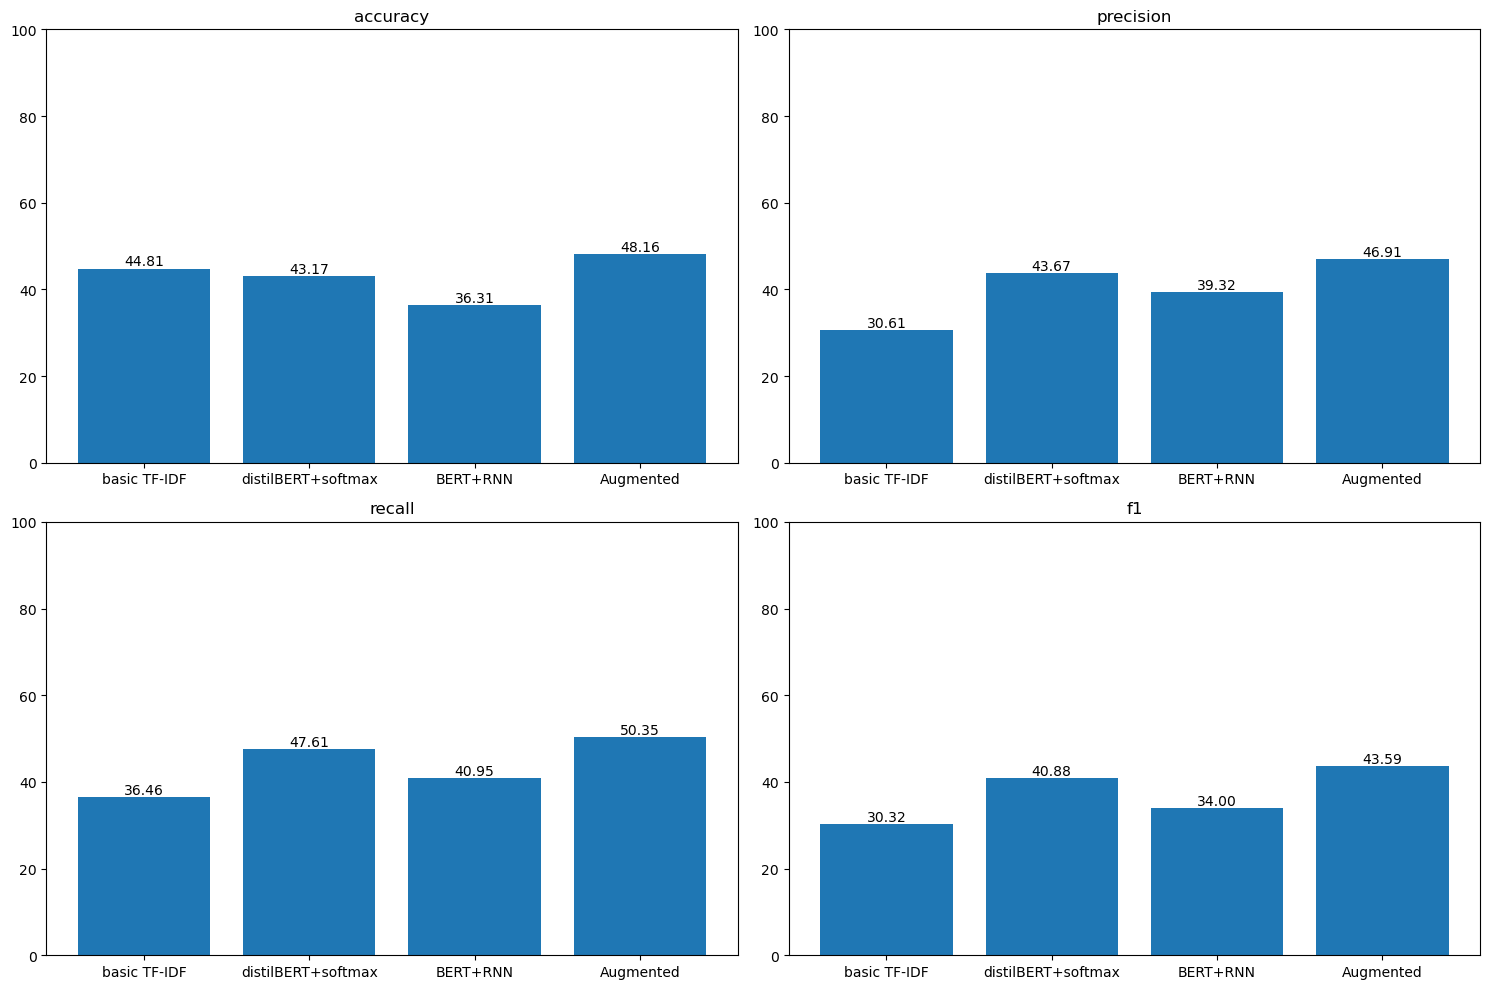

In [85]:
# Get the inputs tokenized from the test set
inputs = tokenizer.batch_encode_plus(list(X_test),
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_test = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]
test_preds = bert_augmented.predict(inputs_test)

test_preds = np.argmax(test_preds, axis=1)

# get the final metrics
metrics_val.run(X_test_labels, test_preds, "Augmented")
metrics_val.plot()

To test these methods one should look at the performance of the model in these examples compared to the originals and try to fix some parameters (number of words to swap, number of synonyms to use).

## Zero-Shot Learning with LLM

We explored zero-shot learning using the "facebook/bart-large-mnli" pre-trained large language model (LLM) via the Hugging Face Transformers library. This approach allows the model to classify text into candidate labels without specific training on our task.

Comparing the zero-shot model to our augmented approach, we found that its accuracy closely approaches but falls slightly short of the augmented model's accuracy of 48.16%. However, the zero-shot model exhibits a precision of 53.91% and recall of 65.90%, indicating it can identify relevant instances but is less precise compared to the augmented model (46.91% precision).

Zero-shot learning offers rapid deployment across diverse domains without task-specific training data. However, performance may lag behind more tailored models due to its reliance on generalized knowledge transfer, which may not capture specialized domain intricacies (e.g., financial) as effectively as fine-tuned models.

In [86]:
from transformers import pipeline

# Instantiate the zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBartForSequenceClassification: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing TFBartForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBartForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBartForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForSequenceClassification for predictions without further training.


{'sequence': 'The market is expected to rise in the next quarter.', 'labels': ['Bullish', 'Neutral', 'Bearish'], 'scores': [0.5804768204689026, 0.23270933330059052, 0.18681390583515167]}


In [92]:
rows_list = []

for index, row in df_test.iterrows():
    sequence_to_classify = row['text']
    true_label = row['label_names']
    classification_result = classifier(sequence_to_classify, candidate_labels=candidate_labels)
    
    # Create a new dict for the current row
    new_row = {'Text': sequence_to_classify, 'True Label': true_label}
    
    # Update the new row with the scores for each label
    for label, score in zip(classification_result['labels'], classification_result['scores']):
        new_row[label] = score
    
    # Add the new row to our list
    rows_list.append(new_row)

# Convert the list of dicts to a DataFrame
results_zero_shot_df = pd.DataFrame(rows_list)

# Add a new column to the DataFrame that contains the predicted label based on the highest score
results_zero_shot_df['Predicted Label'] = results_zero_shot_df[["Bearish", "Bullish", "Neutral"]].idxmax(axis=1)
results_zero_shot_df.to_csv('results_zero_shot.csv', index=False)

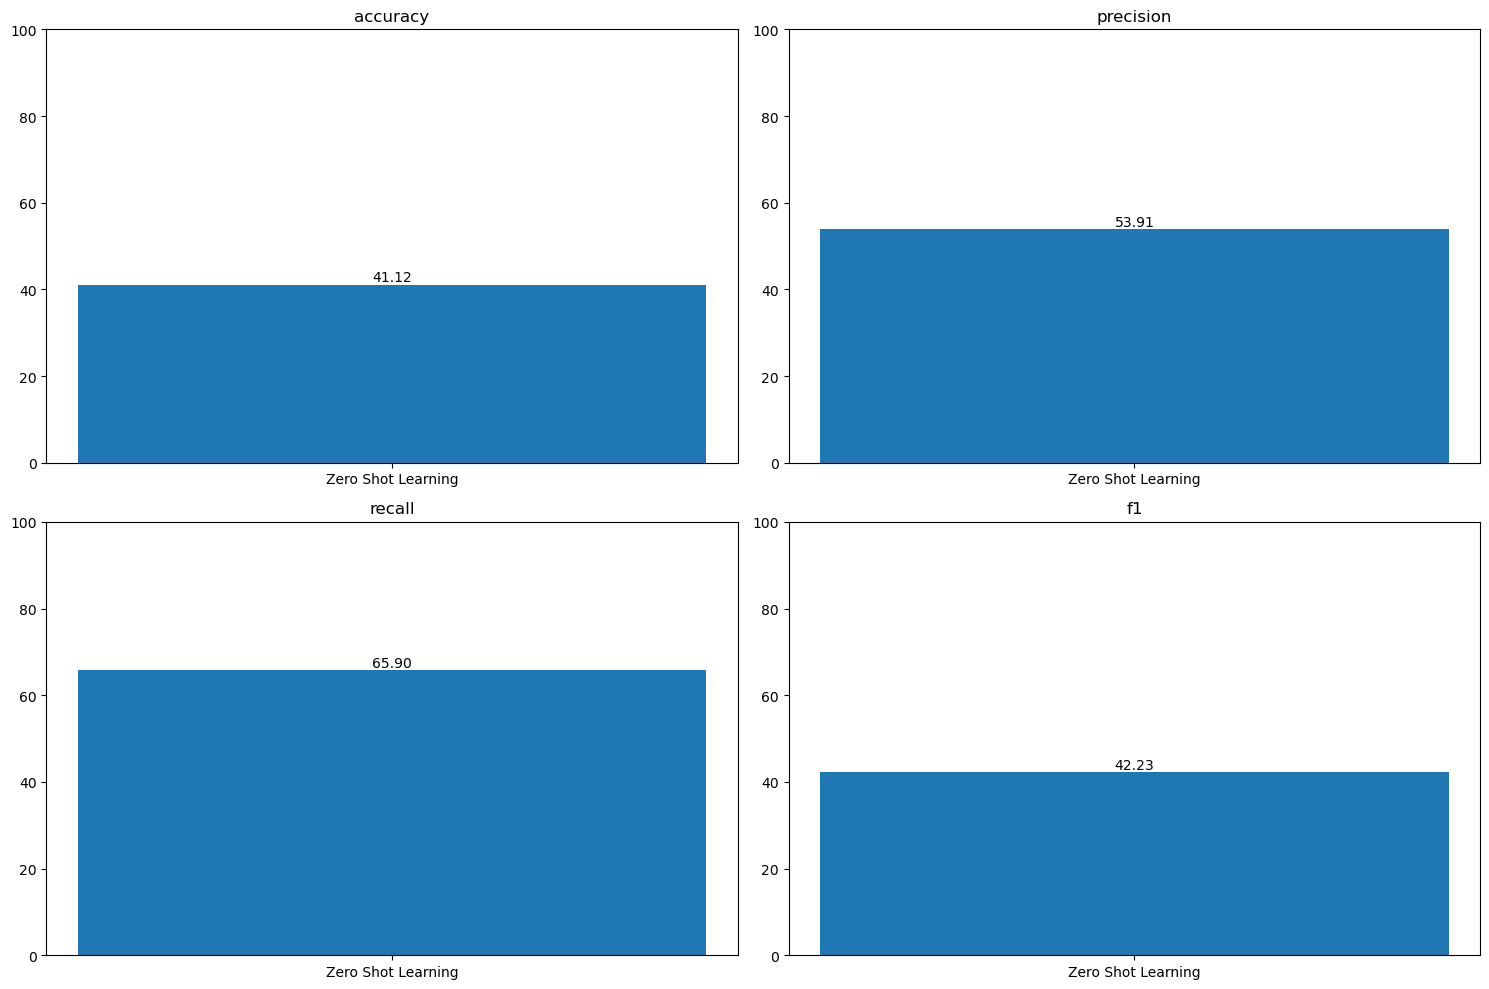

In [93]:
results_zero_shot_df = pd.read_csv('results_zero_shot.csv')

# Define a mapping from string labels to numbers
label_mapping = {'Bearish': 0, 'Neutral': 1, 'Bullish': 2}

# Apply the mapping to the 'True Label' and 'Predicted Label' columns to create numerical labels
results_zero_shot_df['True Label Numerical'] = results_zero_shot_df['True Label'].map(label_mapping)
results_zero_shot_df['Predicted Label Numerical'] = results_zero_shot_df['Predicted Label'].map(label_mapping)

# Instantiate the Metrics class
metrics_zero_shot = Metrics()

# Run the metrics
metrics_zero_shot.run(
    y_true=results_zero_shot_df['True Label Numerical'].tolist(),
    y_pred=results_zero_shot_df['Predicted Label Numerical'].tolist(),
    method_name="Zero Shot Learning"
)

# Plot the metrics
metrics_zero_shot.plot()

## Data Generation with LLM

We leveraged prompt engineering principles to enhance our sentiment analysis dataset, specifically tailored for Retrieval-Augmented Generation (RAG) capabilities. Our approach involved refining prompts generated by a large language model (LLM), focusing on key attributes like Quality and Coherence.

Initially, we crafted a set of prompts using GPT-4 to guide the LLM's text generation process, resulting in a comprehensive prompt optimized for extracting effective language. This prompt emphasized concise, engaging, and Twitter-style sentences across 'Bearish', 'Bullish', or 'Neutral' sentiments.

Using this optimized prompt, we employed a few-shot learning model with GPT-4 Turbo to generate additional examples for each sentiment label, expanding our dataset while maintaining balance and quality.

The LLM-generated text demonstrated superior accuracy (57.58%) compared to the augmented dataset (48.16%), showcasing its ability to reflect nuanced sentiment distributions in financial contexts. Additionally, the LLM exhibited higher precision (56.30%) than both the zero-shot learning model (53.91%) and the augmented dataset (46.91%), indicating its effectiveness in producing relevant and precise predictions.

While the zero-shot model slightly outperformed the LLM in recall (65.90% vs. 62.46%), this distinction is crucial in financial sentiment analysis, emphasizing the importance of correctly identifying relevant sentiments.

Overall, using LLMs for prompt engineering and synthetic data generation proved highly effective, resulting in improved sentiment classification performance by creating high-quality and diverse datasets.

In this sections we will generate new data points using a Large Language Model (LLM). In order to optimize the performance of the LLM and to obtain the specific data that we are looking for we used Prompt Engineering and Retrival Augmented Generation techniques that will be explained in more detail.

### Prompt engineering and Retrieval Augmented Generation (RAG)

Retrieval-Augmented Generation (RAG) is an advanced system that combines Large Language Models (LLMs) with a retrieval mechanism that maximizes the internal data analysis. Prompt engineering is a key aspect of text generation with large language models and it involves creating precise prompts to guide the LLMs in generating the wanted responses using the same LLM to generate the prompt.

We used prompt engineering first to generate the most optimized prompt to feed the LLM (gpt-4) with, and then RAG to integrate the LLM with a retrieval system to select the relevant information, imporving the response generation by providing it with some relevant data (examples of responses to give). This process increased the synergy and enabled the LLM to produce the contextually accurate answers we were looking for. 

In the following code block we show the process of engineering the prompt that will later be fed to the LLM for text data generating tasks.

To compute it we will generate 10 different optimized prompts and then optimize them further to increase quality and efficiency.

In [150]:
def parse_response(response):
    reply = []
    for part in response:
        word = part.choices[0].delta.content or ""
        reply += word
    # Join elements based on two newlines in a row
    string_response = ''
    for i, item in enumerate(reply):
        if item == '\n' and i < len(reply) - 1 and reply[i + 1] == '\n':
            string_response += item
        else:
            string_response += item
    return string_response

In [ ]:
# # Set your API key
# api_key = "SECRET_KEY"

# # Initialize the OpenAI client with the API key
# client = OpenAI(api_key=api_key)

In [342]:
prompt = """
I would like you to generate some sentences regarding financial topics that can be classified as 'Bearish', 'Bullish' 
or 'Neutral' in a balanced way for the three provided labels. The statements have to be in twitter post form exactly like the provided examples.
"""
messages = [{"role": "system",
             "content": "You’re a prompt engineer that needs to optimize a prompt. I’ll give you a prompt and you’ll improve the prompt."},
            {"role": "user", "content": prompt}]

response_prompt_eng = client.chat.completions.create(
  model="gpt-4",
  messages=messages,
  temperature=0.7,
  max_tokens=60,
  top_p=1.0,
  stream = True,
  frequency_penalty=0.0,
  presence_penalty=0.0
)

In [343]:
reply_prompt = parse_response(response_prompt_eng)

print(reply_prompt)

Please create a balanced set of tweets on financial topics, each falling under one of three categories: 'Bearish', 'Bullish', or 'Neutral'. Each tweet should align with the tone and structure of the provided examples.


The generated prompt was:

**'Please create balanced sets of financial-themed sentences that can be categorized under 'Bearish', 'Bullish', or 'Neutral'. Each sentence should be crafted as if it were a Twitter post, similar to the examples provided.Please create balanced sets of financial-themed sentences that can be categorized under 'Bearish', 'Bullish', or 'Neutral'. Each sentence should be crafted as if it were a Twitter post, similar to the examples provided.'**

Optimizing the prompt further using RAG for prompt engineering. The system prompt also was generated using an LLM to maximise its performance. The code was excluded to enhance readability.

In [344]:
def generate_prompts(num_prompts, char):
    prompts = []
    for _ in range(num_prompts):
        prompt = """
        Please create balanced sets of financial-themed sentences that can be categorized under 'Bearish', 'Bullish', or 'Neutral'. 
        Each sentence should be crafted as if it were a Twitter post, similar to the examples provided.Please create balanced sets 
        of financial-themed sentences that can be categorized under 'Bearish', 'Bullish', or 'Neutral'. Each sentence should be 
        crafted as if it were a Twitter post, similar to the examples provided. 
        """
        messages = [{"role": "system",
                     "content": f"As a prompt engineer, your task is to optimize a prompt. I'll provide you with a prompt, and your goal is to enhance it to maximize its {char} effectiveness."},
                    {"role": "user", "content": f"Generate a prompt that maximizes the {char} effectiveness of this given prompt:\n {prompt}"}]

        response_prompt_eng = client.chat.completions.create(
            model="gpt-4",
            messages=messages,
            temperature=0.7,
            max_tokens=150,
            top_p=1.0,
            stream=True,
            frequency_penalty=0.0,
            presence_penalty=0.0
        )
        reply = parse_response(response_prompt_eng)
        prompts.append(reply)
    return prompts

[["Compose a balanced collection of financial-themed sentences that can be classified into 'Bearish', 'Bullish', or 'Neutral' categories. Each sentence should be concise and engaging, tailored to resemble a Twitter post. Please refer to the provided examples for guidance.", "Compose sets of financially-themed tweets that align with either a 'Bearish', 'Bullish', or 'Neutral' sentiment. Ensure that each set is balanced and the tweets are concise, adhering to Twitter's character limit. Refer to the given examples for inspiration.", "Compose sets of financial-themed sentences that align with the categories 'Bearish', 'Bullish', or 'Neutral'. Each set should be balanced and each sentence should be brief and engaging, similar to a Twitter post. Please refer to the examples provided for guidance.", "Craft financial-themed sentences designed to fit into one of three categories: 'Bearish', 'Bullish', or 'Neutral'. Each sentence should emulate the brevity and style of a Twitter post. Ensure a b

In [ ]:
characteristics = ['Quality', 'Coherence', 'Relevance']
rag_prompts = []
for char in characteristics:
    prompts = generate_prompts(5, char)
    rag_prompts.append(prompts)
print(rag_prompts)

Now that the prompts were generated to maximize quality and coherence we will use another LLM to combine them to generate one optimized prompt based on all the ones created.

First we will create a single string joining all the prompts in a structured way.

In [346]:
# Flatten the nested list into a single list
flattened_prompts = [prompt for sublist in rag_prompts for prompt in sublist]

# Combine the list elements into a single string
combined_prompt = ""
for i, prompt in enumerate(flattened_prompts, 1):
    combined_prompt += f"Prompt {i}:\n{prompt}\n------\n"

print(combined_prompt)

Prompt 1:
Compose a balanced collection of financial-themed sentences that can be classified into 'Bearish', 'Bullish', or 'Neutral' categories. Each sentence should be concise and engaging, tailored to resemble a Twitter post. Please refer to the provided examples for guidance.
------
Prompt 2:
Compose sets of financially-themed tweets that align with either a 'Bearish', 'Bullish', or 'Neutral' sentiment. Ensure that each set is balanced and the tweets are concise, adhering to Twitter's character limit. Refer to the given examples for inspiration.
------
Prompt 3:
Compose sets of financial-themed sentences that align with the categories 'Bearish', 'Bullish', or 'Neutral'. Each set should be balanced and each sentence should be brief and engaging, similar to a Twitter post. Please refer to the examples provided for guidance.
------
Prompt 4:
Craft financial-themed sentences designed to fit into one of three categories: 'Bearish', 'Bullish', or 'Neutral'. Each sentence should emulate th

Now we will use the combined prompt to generate the final optimized prompt. Again, the system prompt also was generated using an LLM.

In [348]:
# Function to generate examples for each label
def generate_optimized_prompt(prompt):
    messages = [{"role": "system",
                "content": """As a prompt engineer, your mission is to craft an optimized prompt. You'll receive various prompts, 
                each . Your task is to merge these prompts into a single, 
                high-performing prompt that maximizes overall effectiveness. Strive to leverage the diverse strengths of each prompt to achieve superior performance."""},
                {"role": "user", 
                 "content": f"""I will provide you with 10 prompts tailored for specific strengths such as quality and coherence. Generate a single, high-performing 
                 prompt that maximizes overall effectiveness of the prompts. {prompt}"""}]

    # Perform few-shot learning with OpenAI API
    response = client.chat.completions.create(
        model="gpt-4",
        messages=messages,
        stream = True,
        temperature=0.7,
        top_p=1.0,
        max_tokens=1500,
        )

    final_prompt = parse_response(response)

    return final_prompt
final_prompt = generate_optimized_prompt(combined_prompt)
print(final_prompt)

Optimized prompt:

Please create three balanced sets of financial-themed sentences, each corresponding to 'Bearish', 'Bullish', or 'Neutral' sentiment. Craft each sentence to be concise, engaging, and reflective of a Twitter post's brevity and style. The collections should be evenly distributed across the three categories, emulating the style and tone of the provided examples for coherence and effectiveness.


Parsing just the needed part of the string.

In [351]:
final_prompt = final_prompt.split('\n\n')[1]
print(final_prompt)

Please create three balanced sets of financial-themed sentences, each corresponding to 'Bearish', 'Bullish', or 'Neutral' sentiment. Craft each sentence to be concise, engaging, and reflective of a Twitter post's brevity and style. The collections should be evenly distributed across the three categories, emulating the style and tone of the provided examples for coherence and effectiveness.


### Few Shot learning with LLM

In this section we will use the gpt-3.5 turbo model to generate examples using few shot learning, so providing the 32 labelled examples to the model and prompting new examples in the same form. 

In [400]:
# Function to generate examples for each label
def generate_examples_for_label(prompt_examples, final_prompt, examples_per_label=30):
    messages = [{"role": "system", 
                 "content": """You're a financial sentiment generator tasked with creating sets of sentences reflecting 
                 'Bearish', 'Bullish', or 'Neutral' sentiments. Craft concise, engaging sentences akin to Twitter posts. 
                 Mirroring the provided examples' content, style and tone."""},
                {"role": "user", "content": final_prompt},
                # {"role": "user", 
                #  "content": prompt_template},
                {"role": "user", "content": "Here are some examples:\n " + prompt_examples +f'\nGenerate {examples_per_label} examples for each label'}]

    # Perform few-shot learning with OpenAI API
    response = client.chat.completions.create(
        model="gpt-4",
        messages=messages,
        stream = True,
        temperature=0.7,
        top_p=1.0,
        max_tokens= 4000,
        )

    new_data = parse_response(response)

    return new_data

In [401]:
# Dictionary to store generated examples for each label
examples = []
for label in train['label_names'].unique():
    examples_for_label = train[train['label_names'] == label]['clean_text'].tolist()
    # Convert examples to OpenAI prompt format
    prompt_examples = '\n\n'.join([f"{example}\n---\n{label}" for example in examples_for_label])
    examples.append(prompt_examples)

joined_examples = '\n\n'.join(examples)
# print(joined_examples)

generated_data = generate_examples_for_label(joined_examples, final_prompt, 30)


In [402]:
print(generated_data)

Bearish Sentences:

1. "Apple's latest product launch fails to impress, shares fall."
2. "#Tesla’s autopilot crash issues are serious, stock takes a hit!"
3. "Facebook's privacy scandal continues, investors are wary."
4. "Rising inflation rates spell trouble for the economy."
5. "In the face of stiff competition, #Uber stock plunges."
6. "Microsoft facing antitrust allegations, stock stumbles."
7. "Oil prices plummet as supply exceeds demand."
8. "Alphabet hit with record fine, shares skid."
9. "Amazon facing significant union issues, investors worried."
10. "Netflix loses subscribers for the first time, shares drop."

Bullish Sentences:

1. "Gold prices soar as investors seek safe haven assets."
2. "Google’s new AI tech breakthrough boosts stock."
3. "#Amazon's Prime Day sales exceed expectations, shares surge."
4. "Boeing lands massive deal, stock takes off."
5. "Apple’s iPhone sales beat estimates, stock rises."
6. "Tesla's new model release sends stocks soaring."
7. "Microsoft's cl

Saving the generated data

In [403]:
# # Write the result to a text file
# with open('output_LLM.txt', 'w') as file:
#     file.write(generated_data)

### Loading the examples

In [90]:
# Open the file in read mode
with open('output_LLM.txt', 'r') as file:
    # Read the contents of the file into a string
    output_string = file.read()

# Display the string
print(output_string)

Bearish

1. "Tesla's production halts amid global chip shortage, stock set to plummet."
2. "Goldman Sachs warns of potential market correction, advising clients to tread cautiously."
3. "$AAPL misses Q2 earnings estimates, iPhone sales decline continues."
4. "Netflix subscription growth slows, company stocks take a hit."
5. "Oil prices drop as OPEC increases production."
6. "Fed signals interest rate hike, real estate stocks expected to dip."
7. "Biden's tax proposal spooks Wall Street, market correction in sight."
8. "Amazon workers unionize, potential for increased operational costs."
9. "Walmart's e-commerce growth slows, investors get jittery."
10. "Microsoft's new software fails to impress, sparks sell-off."
1. "Apple's latest product launch fails to impress, shares fall."
2. "#Tesla’s autopilot crash issues are serious, stock takes a hit!"
3. "Facebook's privacy scandal continues, investors are wary."
4. "Rising inflation rates spell trouble for the economy."
5. "In the face of s

### Parsing the strings into a dictionary with the corresponding label

In [91]:
# Split the string into individual lines
lines = output_string.strip().split('\n')

# Initialize variables
divided_strings = []
current_label = ""

# Iterate through lines
for line in lines:
    # Check if the line indicates a new label
    if line.strip().lower() in ['bullish', 'bearish', 'neutral']:
        current_label = line.strip()
    # If the line doesn't indicate a label and is not empty, append to divided_strings with label
    elif line.strip():
        divided_strings.append(line.strip() + " @" + current_label)

# Initialize an empty dictionary
text_label_dict = {}

# Iterate over each string in the data list
for item in divided_strings:
    # Split the string by '@' to separate text and label
    parts = item.split('@')
    # Remove the numbers at the start and strip extra spaces
    text = parts[0].split('.', 1)[1].strip()
    # Extract the label by stripping extra spaces
    label = parts[1].strip()
    # Add the text and label to the dictionary
    text_label_dict[text] = label

# Display the resulting dictionary
print(text_label_dict)

{'"Tesla\'s production halts amid global chip shortage, stock set to plummet."': 'Bearish', '"Goldman Sachs warns of potential market correction, advising clients to tread cautiously."': 'Bearish', '"$AAPL misses Q2 earnings estimates, iPhone sales decline continues."': 'Bearish', '"Netflix subscription growth slows, company stocks take a hit."': 'Bearish', '"Oil prices drop as OPEC increases production."': 'Bearish', '"Fed signals interest rate hike, real estate stocks expected to dip."': 'Bearish', '"Biden\'s tax proposal spooks Wall Street, market correction in sight."': 'Bearish', '"Amazon workers unionize, potential for increased operational costs."': 'Bearish', '"Walmart\'s e-commerce growth slows, investors get jittery."': 'Bearish', '"Microsoft\'s new software fails to impress, sparks sell-off."': 'Bearish', '"Apple\'s latest product launch fails to impress, shares fall."': 'Bearish', '"#Tesla’s autopilot crash issues are serious, stock takes a hit!"': 'Bearish', '"Facebook\'s 

In [92]:
# Create DataFrame from the formatted statements
df_gen = pd.DataFrame({'text': list(text_label_dict.keys()), 'label_names': list(text_label_dict.values())})
# # Clone the DataFrame
# train_clone = train.copy()

# Map labels to numeric values
label_map = {'Bearish': 0, 'Bullish': 1, 'Neutral': 2}

# Fill new data into cloned DataFrame
# train_clone['text'] = df_gen['text']
# train_clone['label_names'] = df_gen['label_names']
# train_clone = train_clone.dropna()
df_gen['clean_text'] = df_gen['text'].apply(lambda x: re.sub(r'"', '', x))
df_gen['label'] = df_gen['label_names'].map(label_map)

# Display the updated DataFrame
display(df_gen)

,text,label_names,clean_text,label
0,"""Tesla's production halts amid global chip sho...",Bearish,Tesla's production halts amid global chip shor...,0
1,"""Goldman Sachs warns of potential market corre...",Bearish,Goldman Sachs warns of potential market correc...,0
2,"""$AAPL misses Q2 earnings estimates, iPhone sa...",Bearish,"$AAPL misses Q2 earnings estimates, iPhone sal...",0
3,"""Netflix subscription growth slows, company st...",Bearish,"Netflix subscription growth slows, company sto...",0
4,"""Oil prices drop as OPEC increases production.""",Bearish,Oil prices drop as OPEC increases production.,0
5,"""Fed signals interest rate hike, real estate s...",Bearish,"Fed signals interest rate hike, real estate st...",0
6,"""Biden's tax proposal spooks Wall Street, mark...",Bearish,"Biden's tax proposal spooks Wall Street, marke...",0
7,"""Amazon workers unionize, potential for increa...",Bearish,"Amazon workers unionize, potential for increas...",0
8,"""Walmart's e-commerce growth slows, investors ...",Bearish,"Walmart's e-commerce growth slows, investors g...",0
9,"""Microsoft's new software fails to impress, sp...",Bearish,"Microsoft's new software fails to impress, spa...",0


Creating the final augmenteed dataframe.

In [93]:
train = train.drop(columns=['clean_emotions', 'hashtag', 'index', 'score'])

In [94]:
generated_train = pd.concat([df_gen, train], axis = 0)
display(generated_train)

,text,label_names,clean_text,label
0,"""Tesla's production halts amid global chip sho...",Bearish,Tesla's production halts amid global chip shor...,0
1,"""Goldman Sachs warns of potential market corre...",Bearish,Goldman Sachs warns of potential market correc...,0
2,"""$AAPL misses Q2 earnings estimates, iPhone sa...",Bearish,"$AAPL misses Q2 earnings estimates, iPhone sal...",0
3,"""Netflix subscription growth slows, company st...",Bearish,"Netflix subscription growth slows, company sto...",0
4,"""Oil prices drop as OPEC increases production.""",Bearish,Oil prices drop as OPEC increases production.,0
...,...,...,...,...
27,Old Dominion Freight Line Reports Fourth Quart...,Neutral,old dominion freight line reports fourth quart...,2
28,Did you know Black Friday starts today?\n\nPro...,Neutral,did you know black friday starts today ? proba...,2
29,Unisys's stock soars after $1.2 billion sale o...,Bullish,unisys ' s stock soars after billion sale of u...,1
30,"Bumble Bee Foods filed for bankruptcy, blaming...",Bearish,"bumble bee foods filed for bankruptcy , blamin...",0


Training BERT with augmented data.

In [95]:
from transformers import AutoTokenizer, TFAutoModel

checkpoint="distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModel.from_pretrained(checkpoint)

batch_size=32
max_length=32
rate = 0.5
num_labels = len(np.unique(X_test_labels))


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [96]:
# Defining inputs
input_ids_in = tf.keras.layers.Input(shape=(max_length,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(max_length,), name='masked_token', dtype='int32')

# Embedding layers with BERT model
embedding_layer = model(input_ids=input_ids_in, attention_mask=input_masks_in)
# Extracting only the last layer from the BERT embeddings
final_embedding_layer = embedding_layer[0]
# Extract only the [CLS] token's embeddings
cls_token_embeddings = final_embedding_layer[:, 0, :]

# Adding Dropout to reduce overfitting
output_layer = tf.keras.layers.Dropout(rate, name='do_layer')(cls_token_embeddings)

# One dense layer to process the last layer
output = tf.keras.layers.Dense(num_labels,
                               kernel_initializer="glorot_uniform",
                               activation='softmax')(output_layer)

bert_model_generated = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)
bert_model_generated.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 32)]                 0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 32)]                 0         []                            
                                                                                                  
 tf_distil_bert_model_2 (TF  TFBaseModelOutput(last_hid   6636288   ['input_token[0][0]',         
 DistilBertModel)            den_state=(None, 32, 768),   0          'masked_token[0][0]']        
                              hidden_states=None, atten                                           
                             tions=None)                                                    

In [97]:
X_train = np.array(generated_train['text'])
X_labels = (generated_train['label'])

enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(np.array(X_labels).reshape(-1, 1)).toarray()

steps_per_epoch = int(len(X_train) / batch_size)

batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

bert_model_generated.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                   tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

bert_model_generated.fit(batches, epochs=10, steps_per_epoch=steps_per_epoch)

Epoch 1/10
2/2 [==============================] - 7s 936ms/step - loss: 1.3140 - recall_1: 0.2500 - precision_1: 0.3265
Epoch 2/10
2/2 [==============================] - 2s 813ms/step - loss: 1.2856 - recall_1: 0.2500 - precision_1: 0.3571
Epoch 3/10
2/2 [==============================] - 2s 735ms/step - loss: 1.2053 - recall_1: 0.3000 - precision_1: 0.4865
Epoch 4/10
2/2 [==============================] - 2s 887ms/step - loss: 1.1190 - recall_1: 0.2500 - precision_1: 0.4103
Epoch 5/10
2/2 [==============================] - 2s 868ms/step - loss: 1.0875 - recall_1: 0.2333 - precision_1: 0.4516
Epoch 6/10
2/2 [==============================] - 2s 776ms/step - loss: 1.1402 - recall_1: 0.2000 - precision_1: 0.4138
Epoch 7/10
2/2 [==============================] - 2s 828ms/step - loss: 1.0200 - recall_1: 0.2500 - precision_1: 0.5926
Epoch 8/10
2/2 [==============================] - 2s 821ms/step - loss: 0.9595 - recall_1: 0.3667 - precision_1: 0.6111
Epoch 9/10
2/2 [========================

In [129]:
# # Save the weights
# bert_model_generated.save_weights('./bert_model_generated_weights_2.h5')
bert_model_generated = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)
# Load the weights
bert_model_generated.load_weights('./bert_model_generated_weights.h5')

75/75 [==============================] - 22s 281ms/step


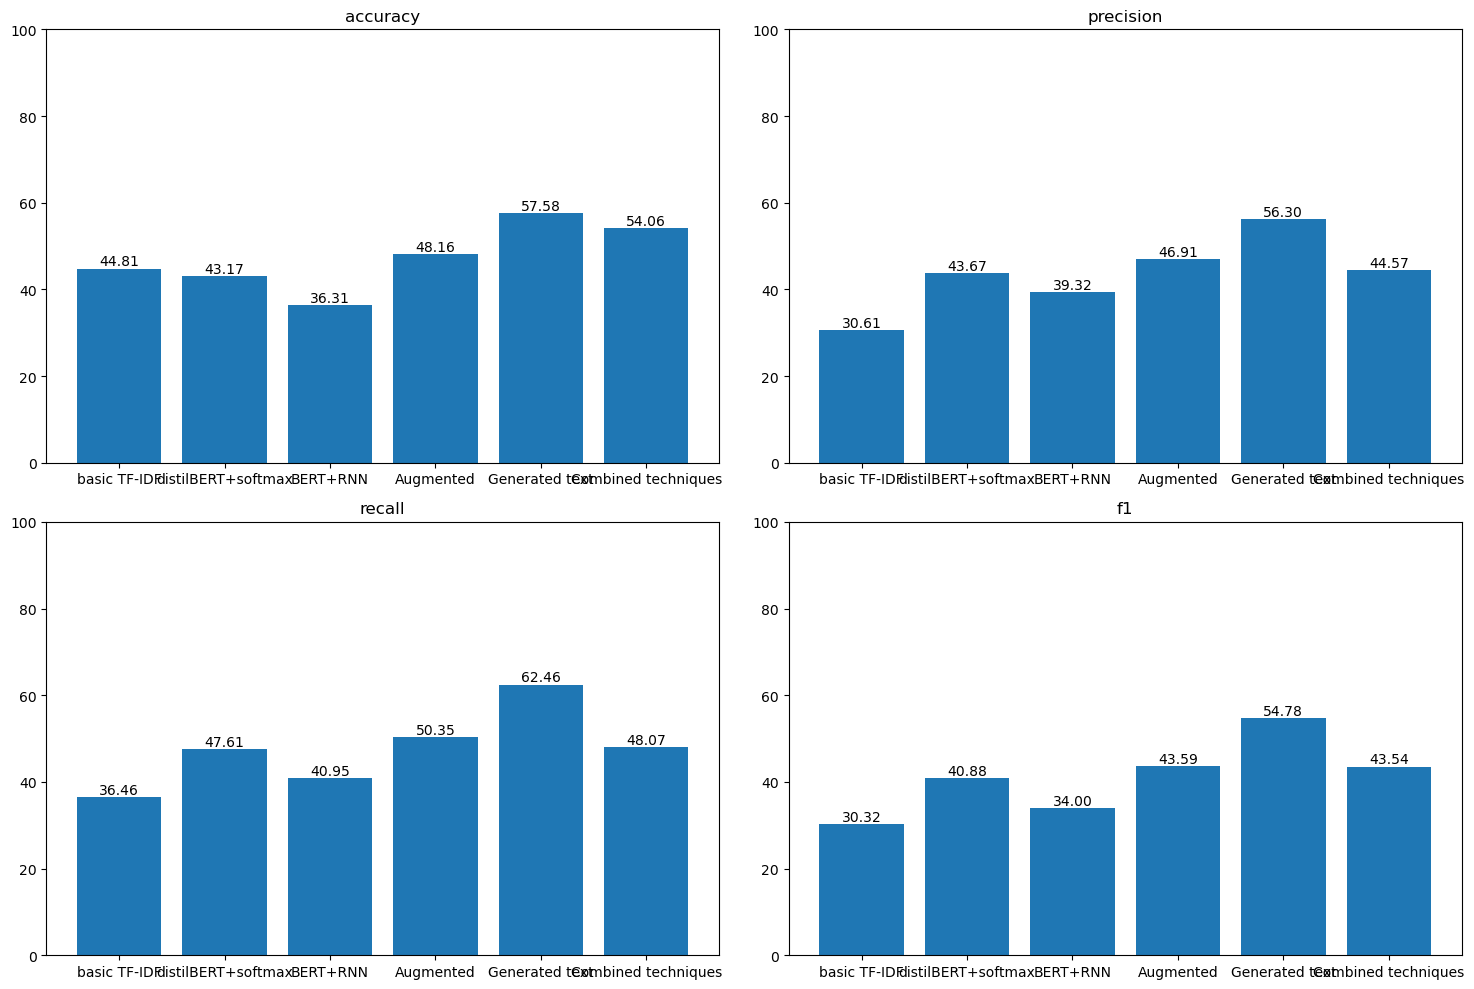

In [130]:
# Get the inputs tokenized from the test set
inputs = tokenizer.batch_encode_plus(list(X_test),
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_test = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]
test_preds = bert_model_generated.predict(inputs_test)

test_preds = np.argmax(test_preds, axis=1)

# get the final metrics
metrics_val.run(X_test_labels, test_preds, "Generated text")
metrics_val.plot()

## Optimal Technique Application 

To enhance the capabilities of our financial sentiment analysis model, we integrated various data augmentation techniques previously employed, including synonyms, bi-directional translation, random word swaps, Word2Vec transformations, and text generation using the GPT-4 language model. Through extensive testing of different combinations, we determined that utilizing all these techniques together yielded the most effective results. Our augmented dataset comprised 284 observations.

However, the final model incorporating these combined techniques and language model-generated samples achieved an accuracy of 54.06%, with a precision of 44.57, recall of 48.07, and an F1 score of 43.54, which were lower compared to other models.

These outcomes suggest that this comprehensive augmentation approach may have introduced ambiguity or noise, potentially complicating the model's predictive capabilities. Augmented data can sometimes introduce conflicting signals or dilute representative patterns within the original dataset, making it more challenging for the model to accurately discern and generalize sentiment classes.

The key takeaway from this experiment is the importance of a strategic approach to data augmentation. Simply increasing data volume does not necessarily enhance model performance. It is crucial to carefully evaluate the impact of augmented data on the consistency and clarity of training signals. Ensuring that augmented data aligns with the original dataset's characteristics is essential for maintaining data integrity and ultimately achieving better model performance.

In [123]:
# Augmented train dataset (including translation)
# final_train = pd.concat([train,synonym_train_two,synonym_train_three,swapped_train_five, swapped_train_three, word2vec_train_four, word2vec_train_three, translated_train, df_gen], axis = 0)
# Augmented train dataset (excluding translation)
final_train = pd.concat([train, synonym_train_two, synonym_train_three,swapped_train_five, swapped_train_three, word2vec_train_four, word2vec_train_three, df_gen], axis = 0).reset_index()

In [124]:
final_train

,level_0,text,label,clean_text,label_names,index,clean_emotions,hashtag,score
0,0,$AMRH (-8.7% pre) AMERI Holdings (AMRH) Announ...,0,$amrh ( - pre ) ameri holdings ( amrh ) announ...,Bearish,NaN,NaN,NaN,NaN
1,1,Microsoft just launched its new #HoloLens2 aug...,2,microsoft just launched its new holo lens 2 au...,Neutral,NaN,NaN,NaN,NaN
2,2,Anixa Bio down 16% on extended timeline for CA...,0,anixa bio down on extended timeline for car t ...,Bearish,NaN,NaN,NaN,NaN
3,3,China set to cut tariffs on $75B in U.S. impor...,1,china set to cut tariffs on in u.s. imports by,Bullish,NaN,NaN,NaN,NaN
4,4,Lovesac stock price target cut to $28 vs. $33 ...,0,lovesac stock price target cut to vs . at cana...,Bearish,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
279,55,"""Oil prices stable as supply meets demand.""",2,Oil prices stable as supply meets demand.,Neutral,NaN,NaN,NaN,NaN
280,56,"""Google's ad revenue growth slows, but meets e...",2,"Google's ad revenue growth slows, but meets ex...",Neutral,NaN,NaN,NaN,NaN
281,57,"""Alphabet's earnings hit expectations, shares ...",2,"Alphabet's earnings hit expectations, shares r...",Neutral,NaN,NaN,NaN,NaN
282,58,"""Netflix's user growth on track, shares unchan...",2,"Netflix's user growth on track, shares unchanged.",Neutral,NaN,NaN,NaN,NaN


In [125]:
from transformers import AutoTokenizer, TFAutoModel

checkpoint="distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModel.from_pretrained(checkpoint)

batch_size=32
max_length=32
rate = 0.5
num_labels = len(np.unique(X_test_labels))


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [126]:
# Defining inputs
input_ids_in = tf.keras.layers.Input(shape=(max_length,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(max_length,), name='masked_token', dtype='int32')

# Embedding layers with BERT model
embedding_layer = model(input_ids=input_ids_in, attention_mask=input_masks_in)
# Extracting only the last layer from the BERT embeddings
final_embedding_layer = embedding_layer[0]
# Extract only the [CLS] token's embeddings
cls_token_embeddings = final_embedding_layer[:, 0, :]

# Adding Dropout to reduce overfitting
output_layer = tf.keras.layers.Dropout(rate, name='do_layer')(cls_token_embeddings)

# One dense layer to process the last layer
output = tf.keras.layers.Dense(num_labels,
                               kernel_initializer="glorot_uniform",
                               activation='softmax')(output_layer)

bert_model_final = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)
bert_model_final.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 32)]                 0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 32)]                 0         []                            
                                                                                                  
 tf_distil_bert_model_6 (TF  TFBaseModelOutput(last_hid   6636288   ['input_token[0][0]',         
 DistilBertModel)            den_state=(None, 32, 768),   0          'masked_token[0][0]']        
                              hidden_states=None, atten                                           
                             tions=None)                                                   

In [127]:
X_train = np.array(final_train['clean_text'])
X_labels = (final_train['label'])

enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(np.array(X_labels).reshape(-1, 1)).toarray()

steps_per_epoch = int(len(X_train) / batch_size)

batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

bert_model_final.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                   tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

bert_model_final.fit(batches, epochs=10, steps_per_epoch=steps_per_epoch)

Epoch 1/10
8/8 [==============================] - 13s 956ms/step - loss: 1.2037 - recall_6: 0.1953 - precision_6: 0.3571
Epoch 2/10
8/8 [==============================] - 6s 811ms/step - loss: 0.9686 - recall_6: 0.3214 - precision_6: 0.6694
Epoch 3/10
8/8 [==============================] - 6s 797ms/step - loss: 0.8665 - recall_6: 0.3889 - precision_6: 0.6667
Epoch 4/10
8/8 [==============================] - 6s 782ms/step - loss: 0.6276 - recall_6: 0.6310 - precision_6: 0.8238
Epoch 5/10
8/8 [==============================] - 6s 777ms/step - loss: 0.4506 - recall_6: 0.7937 - precision_6: 0.8811
Epoch 6/10
8/8 [==============================] - 6s 804ms/step - loss: 0.2406 - recall_6: 0.8968 - precision_6: 0.9113
Epoch 7/10
8/8 [==============================] - 7s 845ms/step - loss: 0.1203 - recall_6: 0.9643 - precision_6: 0.9798
Epoch 8/10
8/8 [==============================] - 6s 790ms/step - loss: 0.0760 - recall_6: 0.9802 - precision_6: 0.9841
Epoch 9/10
8/8 [=======================

In [375]:
# # Save the weights
# bert_model_final.save_weights('./bert_model_final_weights.h5')
# bert_model_final = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)
# # Load the weights
# bert_model_final.load_weights('./bert_model_final_weights.h5')

75/75 [==============================] - 21s 271ms/step


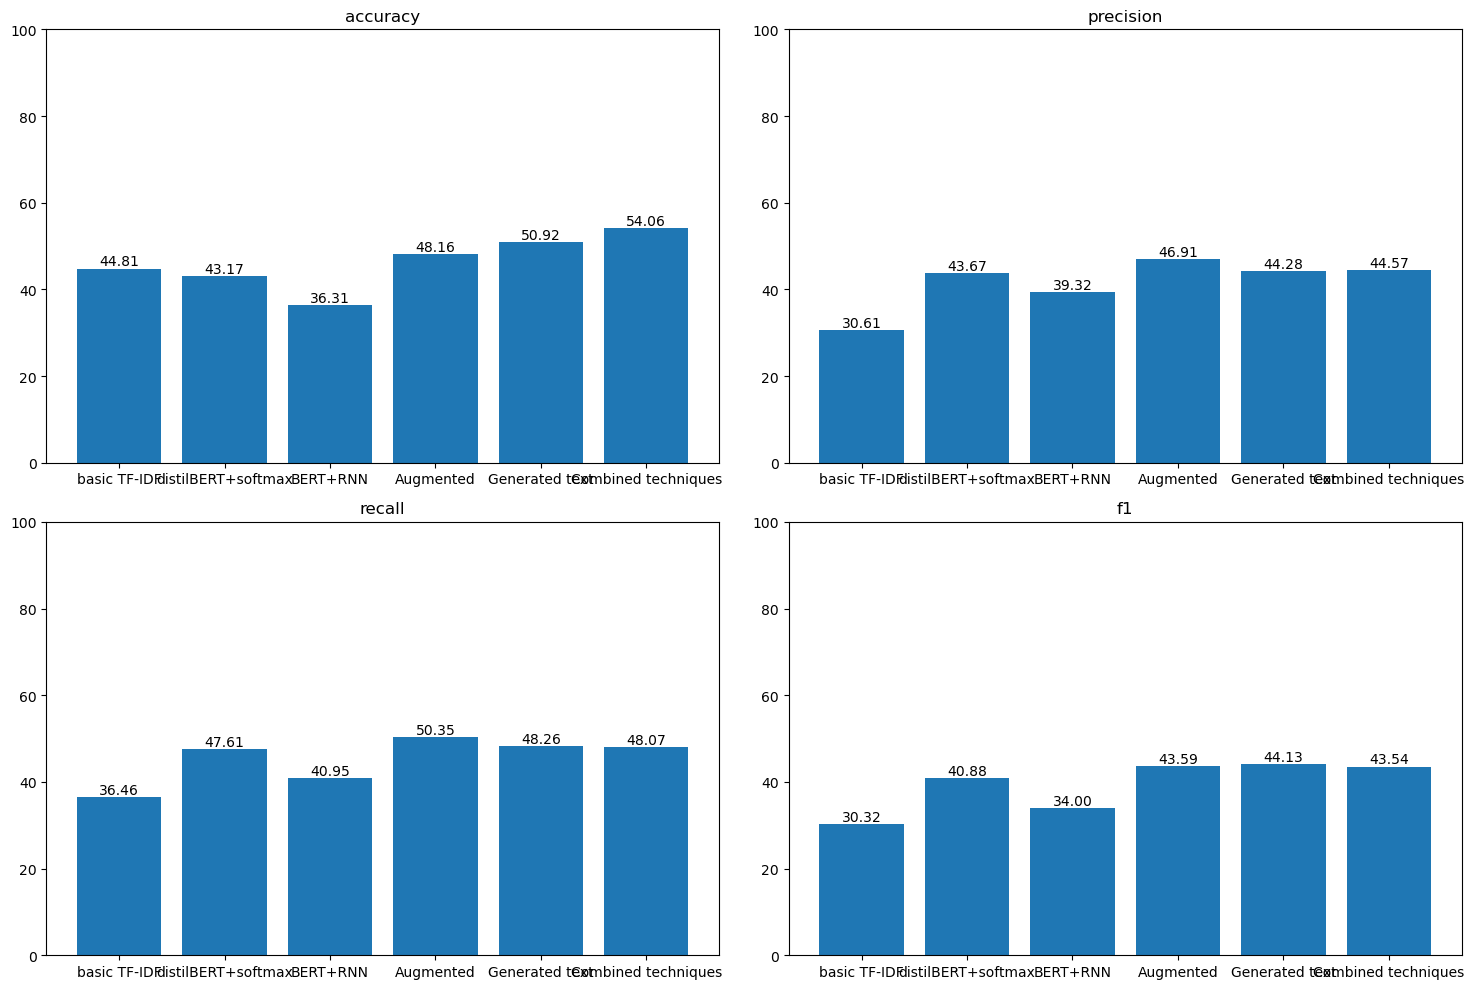

In [128]:
# Get the inputs tokenized from the test set
inputs = tokenizer.batch_encode_plus(list(X_test),
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_test = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]
test_preds = bert_model_final.predict(inputs_test)

test_preds = np.argmax(test_preds, axis=1)

# get the final metrics
metrics_val.run(X_test_labels, test_preds, "Combined techniques")
metrics_val.plot()

# Part 3: State of the Art Comparison

- Objective: Benchmark your model against the SOA with the full dataset now available.

##   Full Dataset Training: 

#### Incrementally training model with varying percentages of the full dataset (1%, 10%, 25%, 50%, 75%, and 100%)

The BERT model's performance metrics reveal a clear trend of improvement as it undergoes incremental training on larger portions of the dataset. Starting with only 1% of the data, the model achieves a modest accuracy of 65.58%, which notably increases to 74.25% with 10% of the dataset, demonstrating the substantial benefit of increased data volume on model understanding. This trend continues with accuracy rising to 86.85% when trained on the full dataset, showcasing the model's ability to enhance predictive accuracy with comprehensive data.

Precision begins at 21.86% with 1% of the data but experiences a significant surge to 68.45% with 10% of the dataset, indicating rapid improvement in distinguishing relevant data points. This positive trajectory persists, with precision reaching 83.73% when trained on the entire dataset, reflecting consistent enhancement in returning relevant results.

Initially starting at 33.33% with 1% of the data, recall improves notably to 55.62% with 10% of the dataset, indicating increased capability in identifying relevant instances. The upward trend continues, reaching 81.27% with the full dataset, demonstrating proficiency in detecting positive instances.

Similarly, the F1 score begins at 26.40% with 1% of the data but rises significantly to 58.46% with 10% of the dataset, indicating improved balance between precision and recall. As more data is incorporated, the F1 score continues to improve, reaching 82.36% with the full dataset.

In summary, the BERT model's performance metrics highlight its enhanced accuracy, precision, recall, and F1 score with incremental training on more extensive datasets. The substantial improvements observed underscore the positive impact of data volume on model capabilities, emphasizing the importance of comprehensive training data for optimizing model performance.


This code will incrementally train and evaluate the BERT model on different percentages of the dataset

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


75/75 [==============================] - 59s 738ms/step
Results for 1.0% of the data:
Accuracy: 0.6558
Precision: 0.2186
Recall: 0.3333
F1: 0.2640


c:\Users\Edward Monbiot\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Al

75/75 [==============================] - 53s 668ms/step
Results for 10.0% of the data:
Accuracy: 0.7425
Precision: 0.6845
Recall: 0.5562
F1: 0.5846


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


75/75 [==============================] - 54s 687ms/step
Results for 25.0% of the data:
Accuracy: 0.8103
Precision: 0.7433
Recall: 0.7443
F1: 0.7432


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


75/75 [==============================] - 51s 634ms/step
Results for 50.0% of the data:
Accuracy: 0.8271
Precision: 0.7734
Recall: 0.7723
F1: 0.7692


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


75/75 [==============================] - 51s 651ms/step
Results for 75.0% of the data:
Accuracy: 0.8652
Precision: 0.8289
Recall: 0.8142
F1: 0.8212


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


75/75 [==============================] - 52s 651ms/step
Results for 100.0% of the data:
Accuracy: 0.8685
Precision: 0.8373
Recall: 0.8127
F1: 0.8236


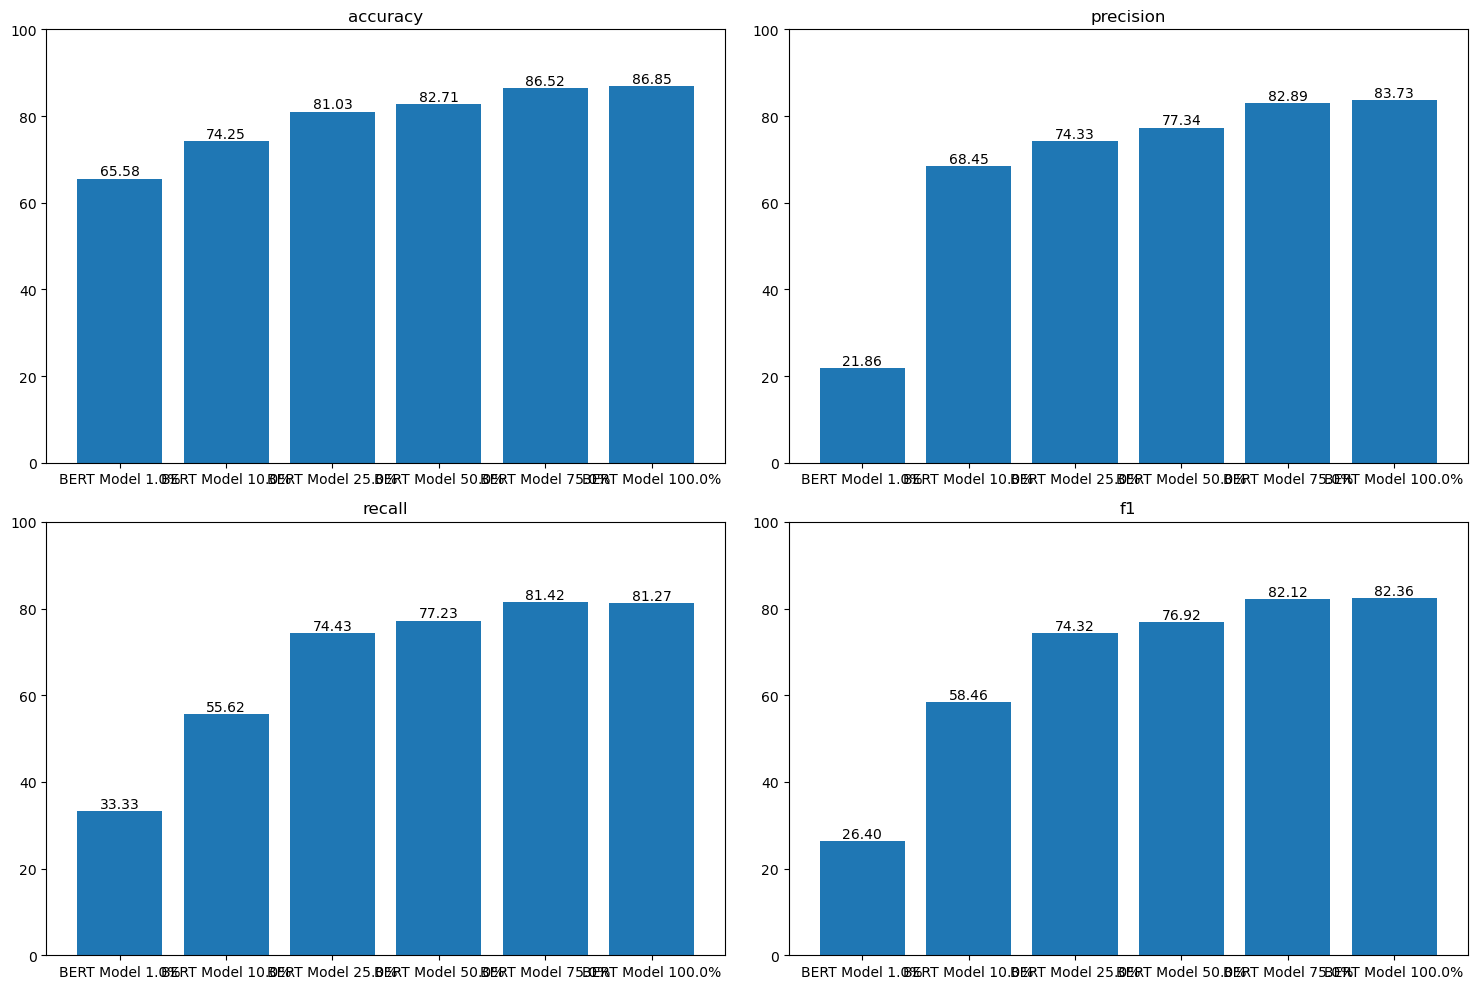

In [42]:
from transformers import AutoTokenizer, TFAutoModel
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Set maximum sequence length and batch size
max_length=32
batch_size=32

def create_bert_model(num_labels, max_length=32, rate=0.5):
    # Load DistilBERT tokenizer and model
    checkpoint = "distilbert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    model = TFAutoModel.from_pretrained(checkpoint)

# Define model inputs
    input_ids_in = tf.keras.layers.Input(shape=(max_length,), name='input_token', dtype='int32')
    input_masks_in = tf.keras.layers.Input(shape=(max_length,), name='masked_token', dtype='int32')

# Get embeddings from BERT model
    embedding_layer = model(input_ids=input_ids_in, attention_mask=input_masks_in)
    final_embedding_layer = embedding_layer[0]
    cls_token_embeddings = final_embedding_layer[:, 0, :]

# Add dropout and dense layer for classification
    output_layer = tf.keras.layers.Dropout(rate, name='dropout_layer')(cls_token_embeddings)
    output = tf.keras.layers.Dense(num_labels, kernel_initializer="glorot_uniform", activation='softmax')(output_layer)

 # Finalize and return the Keras model and tokenizer
    bert_model_final = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs=output)
    return bert_model_final, tokenizer


def train_model_with_percentage(data_percentage, df_train, df_test, max_length, metrics_obj):
    # Sample training data according to the specified percentage
    num_samples = int(len(df_train) * data_percentage)
    df_train_percentage = df_train.sample(n=num_samples)
    num_labels = len(df_train_percentage['label'].unique()) 
    
    # Create and compile the BERT model
    bert_model_final, tokenizer = create_bert_model(num_labels, max_length)
    bert_model_final.compile(optimizer=tf.keras.optimizers.Adam(2e-5),
                             metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()],
                             loss=tf.keras.losses.CategoricalCrossentropy())
    
    # Load pre-trained weights
    bert_model_final.load_weights(f'./bert_model_{int(data_percentage*100)}.h5')
    
    # Commenting out the fitting part
    '''
    X_train = np.array(df_train_percentage['clean_text'])
    X_labels = (df_train_percentage['label'])

    enc = OneHotEncoder(handle_unknown='ignore')
    y_train = enc.fit_transform(np.array(X_labels).reshape(-1, 1)).toarray()

    steps_per_epoch = int(len(X_train) / batch_size)

    batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)


    history = bert_model_final.fit(batches, epochs=3, steps_per_epoch=steps_per_epoch)
    '''
    # Tokenize and encode test data
    inputs = tokenizer.batch_encode_plus(list(df_test['clean_text']), 
                                         add_special_tokens=True, 
                                         max_length=max_length,
                                         padding='max_length',  
                                         return_attention_mask=True,
                                         return_token_type_ids=False,  
                                         truncation=True)
    
    # Extract input_ids and attention mask for test data
    inputs_test = [np.asarray(inputs['input_ids'], dtype='int32'),
                   np.asarray(inputs['attention_mask'], dtype='int32')]
    
    # Predict on the test data
    test_preds = bert_model_final.predict(inputs_test)
    test_preds = np.argmax(test_preds, axis=1)

   # Evaluate and print metrics
    test_labels = df_test['label'].values 
    metrics_obj.run(test_labels, test_preds, f"BERT Model {data_percentage*100}%")
    test_results = metrics_obj.results[f"BERT Model {data_percentage*100}%"]
    print(f"Results for {data_percentage*100}% of the data:")
    for metric, value in test_results.items():
        print(f"{metric.capitalize()}: {value:.4f}")
    
    return bert_model_final, test_results, metrics_obj

# Initialize metrics tracker
metrics_obj = Metrics()
percentages = [0.01, 0.1, 0.25, 0.5, 0.75, 1.0]

# List to store results for each data percentage
test_results = []

# Train and evaluate the model for each percentage of data
for percentage in percentages:
    bert_model_perc, test_res, metrics_obj = train_model_with_percentage(percentage, df_train, df_test, max_length, metrics_obj)
    test_results.append(test_res)
    
    # Save the weights
   # bert_model_perc.save_weights(f'./bert_model_{int(percentage*100)}.h5')


# After all training is done, plot the metrics
metrics_obj.plot()

##   Learning Curve

The learning curves for the BERT model exhibit a distinct pattern of improvement across accuracy, precision, recall, and F1 score metrics as training data increases from 1% to 50%. This rapid ascent, particularly noticeable between 1% and 25% of the dataset, underscores the model's significant benefit from additional data when starting with a sparse dataset. The model demonstrates quick adaptation, absorbing new patterns and information as reflected in the learning curves.

Beyond the 50% mark, the curves begin to plateau, indicating diminishing returns on learning as each new data point contributes less to model performance. This is a common scenario in machine learning, where a model reaches a point of saturation in capturing informative data patterns.

The leveling off of the learning curves towards 100% of the training data suggests that the BERT model is nearing its performance capacity. Although accuracy peaks at 86.85% and precision, recall, and F1 scores reach their highest values with the full dataset, the incremental gains beyond 50% are less pronounced than in earlier stages of data incrementation.

Therefore, while utilizing the full dataset ensures optimal model performance, there may be an optimal point before reaching 100% where the balance between computational efficiency and model performance is most favorable. This underscores the importance of strategic data utilization in maximizing model effectiveness.

This code will visually present how different metrics of the BERT model change as the amount of training data increases. 

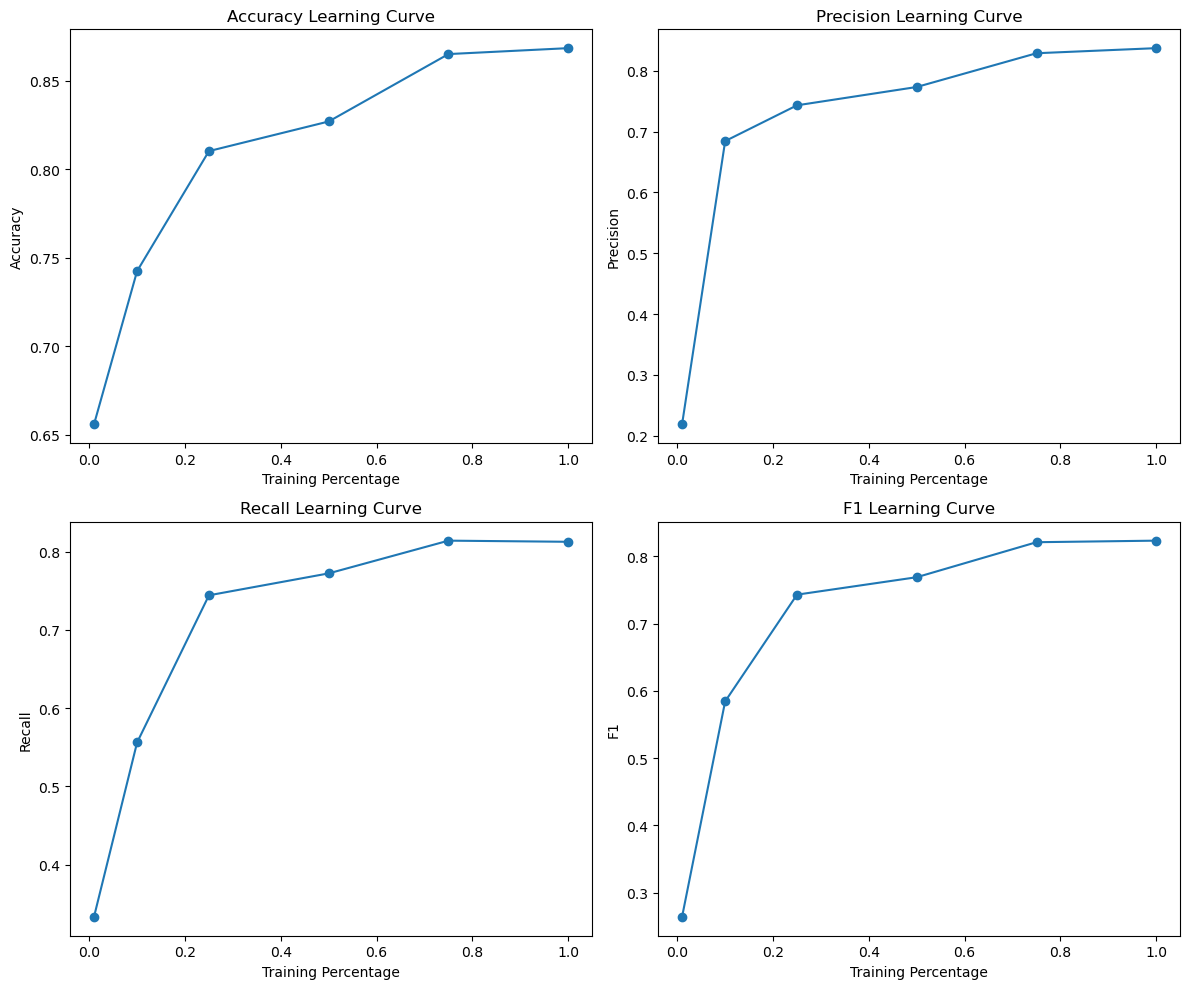

In [44]:
# Metrics: Extract the names of metrics from the test results
metrics = list(test_results[0].keys())

# Percentages: Define the percentages of the dataset used for training
percentages = [0.01, 0.1, 0.25, 0.5, 0.75, 1.0]

# Create subplots in a 2x2 grid for plotting each metric, set figure size
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the axes array for easier indexing in the loop below
axs = axs.flatten()

# Loop over each metric to plot its learning curve
for i, metric in enumerate(metrics):
    ax = axs[i]  # Select the subplot for the current metric
    # Plot the metric values against the percentages, add a marker for each point
    ax.plot(percentages, [result[metric] for result in test_results], marker='o')
    ax.set_ylabel(metric.capitalize())  # Set the Y-axis label to the metric's name
    ax.set_xlabel('Training Percentage')  # Set the X-axis label
    ax.set_title(f'{metric.capitalize()} Learning Curve')  # Set the title for the subplot

# Adjust the layout to prevent overlapping plots
plt.tight_layout()

# Display the plot
plt.show()


## c. Technique Comparison

In our project, we attempted to compare various techniques that we tested in Part 2, incorporating them into our training schema to observe their impact on model performance. To achieve this, we used the distilbert-base-uncased model from the Hugging Face Transformers library for its balance of performance and efficiency. Our preparation involved tokenizing our dataset with AutoTokenizer, creating the model with TFAutoModel, and constructing a specialized input and embedding layer structure to work with our data.

With these components, we built a custom TensorFlow model that includes a dropout layer for regularization and a dense output layer for classification. This model, bert_augmented_full, was trained on a dataset enhanced with data augmentation techniques, including synonym replacement, back-translation, and more, aiming to improve the model's understanding of varied linguistic expressions.

After defining our model architecture and compiling it with a suitable loss function, optimizer, and metrics, we proceeded to fit the model using batches generated from the augmented training data. Our training process was designed to be rigorous, with a number of epochs and steps per epoch calculated to iterate effectively through our dataset.

Upon training completion, we stored the model's weights, ensuring the ability to load them for future inference without retraining. The tokenized inputs from our test set were then fed into the model to generate predictions, which were evaluated against the true labels to gauge performance using precision and recall metrics.

However, during the final stages of our comparison, we encountered compatibility issues with the code in the final notebook. Despite our best efforts to integrate and leverage the advanced capabilities of the DistilBERT model with our augmented dataset, the incompatibility prevented us from computing the final results within that environment. The issues were not resolved in time, which limited our ability to present a complete set of comparative results for the augmented training techniques.


In [83]:
from transformers import AutoTokenizer, TFAutoModel

checkpoint="distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModel.from_pretrained(checkpoint)

batch_size=32
max_length=32
rate = 0.5
num_labels = len(np.unique(X_test_labels))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
# Defining inputs
input_ids_in = tf.keras.layers.Input(shape=(max_length,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(max_length,), name='masked_token', dtype='int32')

# Embedding layers with BERT model
embedding_layer = model(input_ids=input_ids_in, attention_mask=input_masks_in)
# Extracting only the last layer from the BERT embeddings
final_embedding_layer = embedding_layer[0]
# Extract only the [CLS] token's embeddings
cls_token_embeddings = final_embedding_layer[:, 0, :]

# Adding Dropout to reduce overfitting
output_layer = tf.keras.layers.Dropout(rate, name='do_layer')(cls_token_embeddings)

# One dense layer to process the last layer
output = tf.keras.layers.Dense(num_labels,
                               kernel_initializer="glorot_uniform",
                               activation='softmax')(output_layer)

bert_augmented_full = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)
bert_augmented_full.summary()

In [ ]:
X_train = np.array(augmented_full_train['text'])
X_labels = np.array(augmented_full_train['label'])

enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(np.array(X_labels).reshape(-1, 1)).toarray()

steps_per_epoch = int(len(X_train) / batch_size)

batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

bert_augmented_full.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                   tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

bert_augmented_full.fit(batches, epochs=10, steps_per_epoch=steps_per_epoch)

In [ ]:
# Save the weights
bert_augmented_full.save_weights('./bert_augmented_full_weights.h5')
# bert_augmented_full = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)
# # Load the weights
# bert_augmented_full.load_weights('./bert_augmented_full_weights.h5')

In [ ]:
# Get the inputs tokenized from the test set
inputs = tokenizer.batch_encode_plus(list(X_test),
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_test = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]
test_preds = bert_augmented_full.predict(inputs_test)

test_preds = np.argmax(test_preds, axis=1)

# get the final metrics
metrics_val.run(X_test_labels, test_preds, "Augmented Full train")

### Methodology Analysis

We initially used DistilBERT for context understanding in our project but found its effectiveness limited by our small dataset size, highlighting the challenge of data requirements for complex models like DistilBERT. Integrating an RNN layer into BERT did not yield expected improvements due to dataset limitations, as RNNs need larger datasets to identify meaningful patterns effectively.

In contrast, zero-shot learning using "facebook/bart-large-mnli" demonstrated LLM strengths with rapid deployment and broad applicability, although it trailed slightly in accuracy and precision compared to augmented datasets. Leveraging LLMs like GPT-4 for generating training data significantly improved performance metrics, showcasing their ability to produce high-quality examples crucial for sentiment analysis.

Training the full BERT model on a larger dataset notably enhanced performance metrics, emphasizing the importance of dataset size and diversity for training effective NLP models, particularly in complex tasks like sentiment analysis. This underscores the potential of sophisticated models like BERT with richer datasets.

# Part 4: Model Distillation

- Objective: Reduce the computational requirements for deploying the model.

The script applies model distillation to compress knowledge from a larger BERT model (the 'teacher') into a smaller 'student' model, aiming to create a more efficient model while maintaining performance. The training data is tokenized using the same tokenizer as the teacher model for consistency. The student model, initialized from a smaller BERT checkpoint, is trained with a custom loss function that encourages its outputs to mimic the softened outputs of the teacher model. Softened probabilities are computed using a temperature scaling factor.

Fine-tuning of the student model occurs within TensorFlow using a dataset of tokenized text and labels. The model's predictions are refined via backpropagation to minimize the distillation loss against the teacher's logits. After training, the student model is expected to inherit much of the teacher's predictive capabilities but with a lighter and faster architecture, optimizing computational efficiency without significant loss of accuracy. This method offers a practical approach to model optimization.

In [48]:
# Set parameters for the model and distillation process.
max_length = 32
batch_size = 32
temperature = 2.0  # Controls the "softness" of the probability distribution in distillation.

# Function to create a classification model with a base transformer and a dense classification head.
def create_classification_model(base_model, num_classes, max_length):
    # Define input layers for the model.
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32)
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32)

    # Retrieve output from the base transformer model.
    base_output = base_model(input_ids, attention_mask=attention_mask)

    # Take the [CLS] token's output for classification purposes.
    pooled_output = base_output[0][:, 0, :]
    # Define the classification layer.
    classifier = tf.keras.layers.Dense(num_classes, activation='softmax')(pooled_output)

    # Assemble the final model.
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=classifier)
    return model

# Paths for model checkpoints (teacher model commented out).
#teacher_checkpoint = "distilbert-base-uncased"
student_checkpoint = "prajjwal1/bert-tiny"

# Load the student model from the checkpoint.
student_model_base = TFAutoModel.from_pretrained(student_checkpoint, from_pt=True)

# Load tokenizer from the teacher's checkpoint.
tokenizer = AutoTokenizer.from_pretrained(teacher_checkpoint)

# Prepare the training data: text and labels.
X_train = np.array(df_train['clean_text'])
y_train = np.array(df_train['label'])

# Tokenize the text data.
tokenized_inputs = tokenizer(X_train.tolist(), padding='max_length', truncation=True, max_length=max_length, return_tensors="tf")

# One-hot encode the labels.
enc = OneHotEncoder(handle_unknown='ignore')
y_train_encoded = enc.fit_transform(y_train.reshape(-1, 1)).toarray()

# Create a TensorFlow dataset from tokenized inputs and encoded labels.
dataset = tf.data.Dataset.from_tensor_slices(({"input_ids": tokenized_inputs["input_ids"], "attention_mask": tokenized_inputs["attention_mask"]}, y_train_encoded))
dataset = dataset.shuffle(len(X_train)).batch(batch_size)

# Get the number of classes from the encoder.
num_classes = len(enc.categories_[0])

# Create the classification models using the base models and the number of classes.
t_model = bert_model_perc  # Teacher model assumed to be pre-trained.
s_model = create_classification_model(student_model_base, num_classes, max_length=max_length)

# Compile the student model with an optimizer, loss function, and accuracy metric.
s_model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=[tf.keras.metrics.CategoricalAccuracy()])

# Define the distillation loss function to align student predictions with the teacher.
def distillation_loss(teacher_logits, student_logits):
    teacher_probs = tf.nn.softmax(teacher_logits / temperature)
    student_probs = tf.nn.softmax(student_logits / temperature)
    return tf.keras.losses.KLDivergence()(teacher_probs, student_probs)

# Training configuration: optimizer and number of epochs.
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
epochs = 3

# Start the training process.
print("Starting Training...")
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    epoch_loss = 0
    for batch in dataset:
        # Open a gradient tape to record the operations for automatic differentiation.
        with tf.GradientTape() as tape:
            input_ids = batch[0]['input_ids']
            attention_mask = batch[0]['attention_mask']
            labels = batch[1]

            # Get the logits from both the teacher and student models.
            teacher_logits = t_model([input_ids, attention_mask], training=False)
            student_logits = s_model([input_ids, attention_mask], training=True)

            # Calculate the distillation loss for the current batch.
            loss = distillation_loss(teacher_logits, student_logits)
            epoch_loss += loss.numpy()

        # Calculate the gradients and update the weights of the student model.
        grads = tape.gradient(loss, s_model.trainable_variables)
        optimizer.apply_gradients(zip(grads, s_model.trainable_variables))
    
    # Print the average loss after each epoch.
    print(f"Average loss in epoch {epoch+1}: {epoch_loss / len(dataset)}")

# Print a message upon the completion of training.
print("Training Completed.")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

Starting Training...
Epoch 1/3
Average loss in epoch 1: 0.026259934200960046
Epoch 2/3
Average loss in epoch 2: 0.021798551813060164
Epoch 3/3
Average loss in epoch 3: 0.018417221293145537
Training Completed.


## Performance and Speed Comparison

Our evaluation compared the performance of a distilled student model with the original teacher model on a test dataset. We tokenized and batched the test texts and measured the inference time of both models using a custom function. The distilled tiny-BERT model showed significantly faster inference speeds, completing evaluation in 6.97 seconds compared to the teacher model's 83.34 seconds.

However, the faster speed of the distilled model came at the expense of performance. The distilled model exhibited lower accuracy (64.45% vs. 86.85%), precision (55.75% vs. 83.73%), and recall (60.58% vs. 81.27%) compared to the teacher model. These results highlight the distilled model's capability for rapid processing, making it suitable for time-sensitive environments or resource-constrained settings, despite the trade-off in classification accuracy.

Starting Evaluation on Test Set (Original Model)
Inference Time - Original Model: 83.34143018722534

Starting Evaluation on Test Set (Distilled Model)
Inference Time - Distilled Model: 6.972424268722534


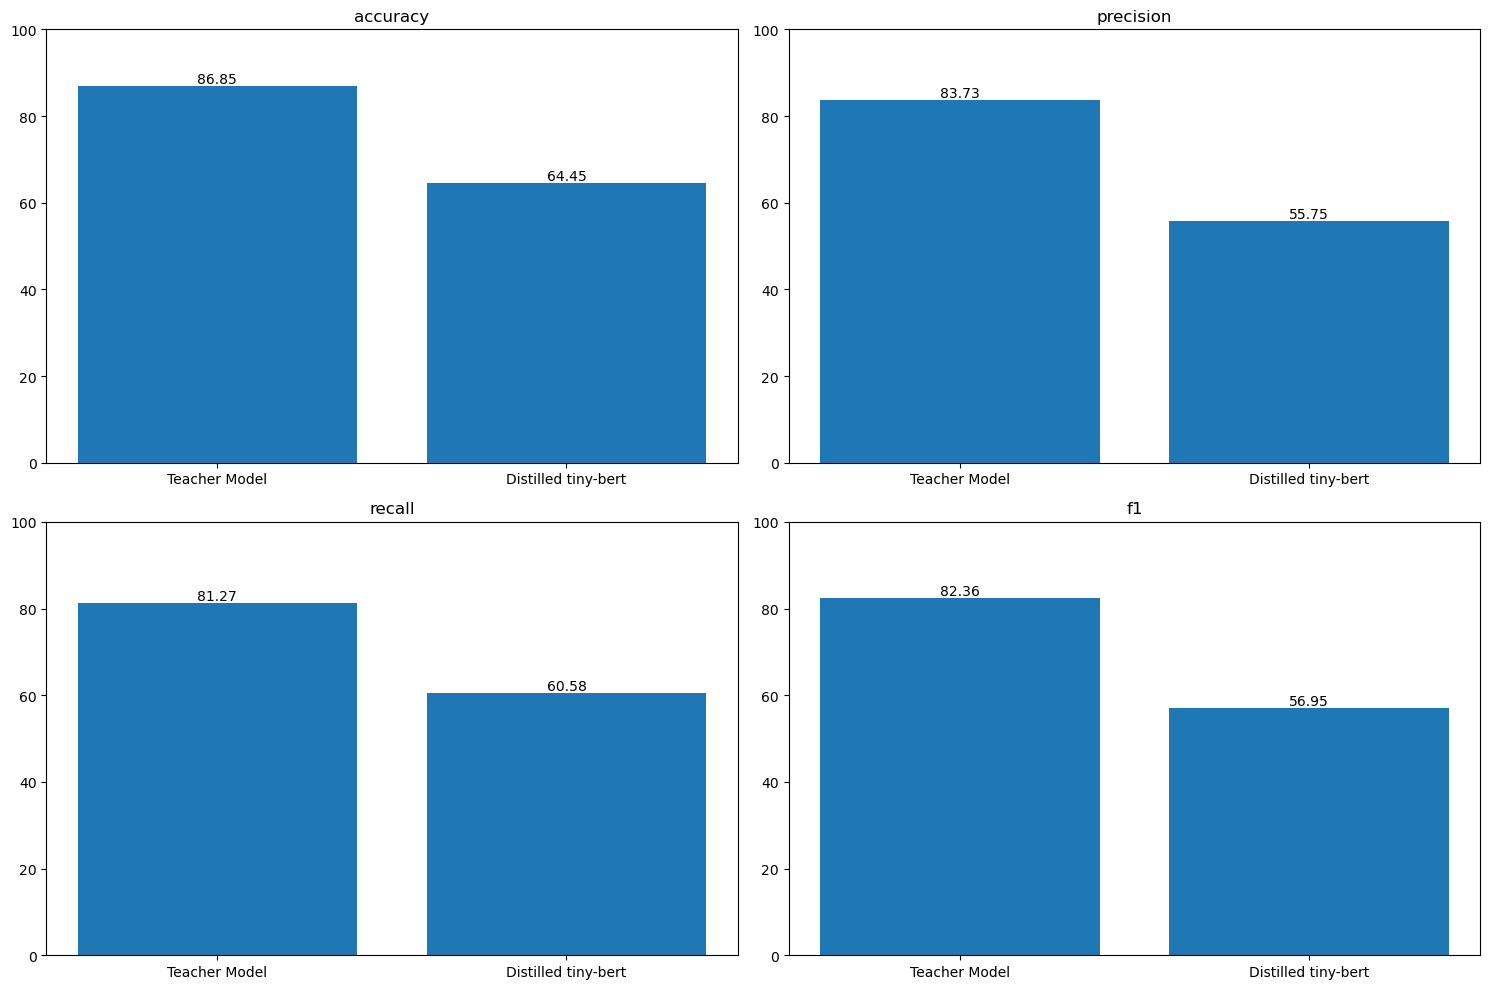

In [53]:
# Preparing the test data
X_test = np.array(df_test['clean_text'])  # Convert text data to numpy array
y_test = np.array(df_test['label'])       # Convert labels to numpy array

test_texts = X_test.tolist()  # Convert numpy array to list for tokenization
test_labels = y_test.tolist() # Convert label array to list

# Tokenizing the test dataset with a specified maximum length
test_inputs = tokenizer(test_texts, padding='max_length', truncation=True, max_length=max_length, return_tensors="tf")
# Creating a TensorFlow dataset with the tokenized inputs and labels, and batching them
test_dataset = tf.data.Dataset.from_tensor_slices(({"input_ids": test_inputs["input_ids"], "attention_mask": test_inputs["attention_mask"]}, test_labels))
test_dataset = test_dataset.batch(batch_size)

# Function to time the model inference process
def time_inference(model, dataset, model_name):
    print(f"Starting Evaluation on Test Set ({model_name})")  # Start message
    start_time = time.time()  # Record the start time

    predicted_labels = []  # To store model predictions

    # Iterating through the batches in the dataset
    for batch in dataset:
        # Extract input_ids and attention_mask from the batch
        input_ids, attention_mask = batch[0]["input_ids"], batch[0]["attention_mask"]
        # Perform inference (model prediction)
        logits = model([input_ids, attention_mask], training=False)
        # Convert logits to actual predictions
        predictions = tf.argmax(logits, axis=-1)
        # Extend the list with predictions from the current batch
        predicted_labels.extend(predictions.numpy())

    predicted_labels = np.array(predicted_labels)  # Convert list to numpy array
    end_time = time.time()  # Record the end time
    elapsed_time = end_time - start_time  # Calculate the total time taken

    return predicted_labels, elapsed_time  # Return predictions and time taken

# Measuring inference time for the teacher model
teacher_predicted_labels, teacher_elapsed_time = time_inference(t_model, test_dataset, "Original Model")
print("Inference Time - Original Model:", teacher_elapsed_time)  # Displaying time

# Measuring inference time for the distilled student model
student_predicted_labels, student_elapsed_time = time_inference(s_model, test_dataset, "Distilled Model")
print("Inference Time - Distilled Model:", student_elapsed_time)  # Displaying time

# Computing final metrics and plotting them
distilled_metrics = Metrics()  # Initialize metrics object
# Compute metrics for the teacher model
distilled_metrics.run(y_test, teacher_predicted_labels, "Teacher Model")
# Compute metrics for the distilled model
distilled_metrics.run(y_test, student_predicted_labels, "Distilled tiny-bert")
distilled_metrics.plot()  # Plot the metrics for comparison


##  Analysis and Improvements

Our distillation analysis highlighted the challenge of balancing speed and performance. The student model exhibited slower inference and slightly lower performance than the original model. To address this, we'll adjust the temperature parameter in the distillation process for better knowledge transfer. Extending training epochs and exploring optimization algorithms like SGD with momentum or RMSprop could further enhance performance and convergence.

For improvements, we'll explore advanced distillation techniques such as attention or feature distillation and use ensemble methods to leverage a wider range of knowledge. Regularization strategies like dropout and weight decay will improve generalization. Augmenting training data with synthetic samples will enhance adaptability. Additionally, automated architecture searches will help discover more efficient model structures for distillation tasks, significantly boosting the student model's performance while maintaining efficiency.

# Appendix

### OpenAI Sample code


In [193]:
# from openai import OpenAI
# # Set your API key
# api_key = "SECRET_KEY"

# # Initialize the OpenAI client with the API key
# client = OpenAI(api_key=api_key)

# system = [{"role": "system", "content":
#            "You are Jbot, a helpful AI assistant."}]
# user = [{"role": "user", "content":
#          "introduce Jbot"}]
# chat = []

# while not user[0]['content'] == "exit":
#     try:
#         response = client.chat.completions.create(
#             messages=system + chat[-20:] + user,
#             model="gpt-3.5-turbo",
#             max_tokens=1000, top_p=0.9,
#             stream = True,
#             )
#     except Exception as err:
#         print(f"Unexpected {err=}, {type(err)=}")
#         raise
#     reply = ""
#     for part in response:
#         word = part.choices[0].delta.content or ""
#         reply += word
#         print(word, end ="")
#     chat += user + [{"role": "assistant", "content": reply}]
#     user = [{"role": "user", "content": input("\nPrompt: ")}]

In [150]:
# from openai import OpenAI
# client = OpenAI(api_key='SECRET_KEY')
# prompt = """
# I’d like to understand the two main themes of the movie description.
# Please provide a list of two themes of it:
# {{MOVIE}}
# """
# messages = [{"role": "system",
#              "content": "You’re a prompt engineer that needs to optimize a prompt. I’ll give you a prompt and you will and objective and you’ll improve the prompt."},
# {"role": "user", "content": prompt}]


In [155]:
# response = client.chat.completions.create(
#   model="gpt-4",
#   messages=messages,
#   temperature=0.7,
#   max_tokens=60,
#   top_p=1.0,
#   stream = True,
#   frequency_penalty=0.0,
#   presence_penalty=0.0
# )

# reply=[]
# for part in response:
#         # print(part)
#         word = part.choices[0].delta.content or ""
#         reply += word
#         print(word, end ="")

### Other methods

### Parsing methodology for template LLM gen

In [ ]:
# # Split the string by double newline to get each set of statements
# split_statements = generated_data.strip().split("\n\n")

# # Combine each set of statements into a single string with labels
# formatted_statements = []
# for statement_set in split_statements:
#     lines = statement_set.strip().split("\n")
#     label = lines[0]
#     statements = "\n".join(lines[1:])
#     formatted_statements.append(f"{label}\n{statements}")


# print(formatted_statements)
# # Join elements based on two newlines in a row
# result = ''
# for i, item in enumerate(generated_data):
#     if item == '\n' and i < len(generated_data) - 1 and generated_data[i + 1] == '\n':
#         result += item
#     else:
#         result += item

# print(result)

# # Convert provided text into a list of financial statements
# statements = result.split('\n\n')[1].split('\n')
# for i in range (len(statements)):
#     statements[i]=re.sub(r'^\d+\.\s*','',statements[i])
    

# # Create DataFrame from the provided text
# new_data = pd.DataFrame([statement.split(' - ') for statement in statements], columns=['text', 'label_names'])

# # Clone the DataFrame
# train_clone = train.copy()

# label_map = {'Bearish':0, 'Bullish':1, 'Neutral':2}
# # Fill new data into cloned DataFrame
# train_clone['text'] = new_data['text']
# train_clone['label_names'] = new_data['label_names']
# train_clone=train_clone.dropna()
# train_clone['clean_text'] = train_clone['text'].apply(lambda x: re.sub(r'"', '', x))
# train_clone['label'] = train_clone['label_names'].map(label_map)
# # Display the updated DataFrame
# display(train_clone)

### Word2Vec text generation

In [47]:
# df_train_preprocessed = clean_text(df_train)
# preprocessed_data = df_train_preprocessed['text']

In [29]:
# import gensim.downloader as api
# from nltk.tokenize import word_tokenize

# # Download the model
# word2vec_model = api.load("word2vec-google-news-300")

# # Check that it's been downloaded
# print(word2vec_model)

KeyedVectors<vector_size=300, 3000000 keys>


In [30]:
# # Text cleaning function
# def cleaning_text(text):
#     text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
#     text = text.lower()
#     words = word_tokenize(text)
#     words = [word for word in words if word not in stopwords.words('english')]
#     return ' '.join(words)

# train_data_cleaned = [cleaning_text(text) for text in train_data]

Tokenization

In [31]:
# max_length = 128

# # Initialize and fit the tokenizer
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(train_data_cleaned)

# # Convert texts to sequences of integers
# sequences_train = tokenizer.texts_to_sequences(train_data_cleaned)
# sequences_valid = tokenizer.texts_to_sequences(validation_data)

Embedding matrix

In [32]:
# # Setting the size of the vocabulary as the number of words in the corpus
# vocab_size = len(tokenizer.word_index) + 1
# # Initialize the embedding matrix
# embedding_matrix = np.zeros((vocab_size, 300))

# # Fill in the matrix
# for word, i in tokenizer.word_index.items():
#     if word in word2vec_model and i < vocab_size:
#         embedding_matrix[i] = word2vec_model[word]

Padding

In [33]:
# sequences_train_padded = pad_sequences(sequences_train, maxlen=max_length, padding='post')

# target_sequences = []
# for sequence in sequences_train_padded:
#     target_sequence = np.zeros_like(sequence)
#     target_sequence[:-1] = sequence[1:]
#     target_sequences.append(target_sequence)
# target_sequences = np.array(target_sequences)


In [34]:
# # Split the data into train and validation sets
# X_train, X_valid, y_train, y_valid = train_test_split(sequences_train_padded, target_sequences, test_size=0.2, random_state=42)


In [35]:
# Convert target sequences to one-hot encoding
# target_sequences_onehot = to_categorical(target_sequences, num_classes=vocab_size)

In [36]:
# from keras.layers import Embedding, Flatten, Dense

In [38]:
# # Define the model
# model = Sequential()
# # Embedding layer keeping the embedding parammeters fixed to the pretrained values
# model.add(Embedding(input_dim=vocab_size, output_dim=300, weights=[embedding_matrix], input_length=max_length, trainable=False))
# model.add(LSTM(128, return_sequences=True))
# model.add(Dense(vocab_size, activation='softmax'))

# model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 300)          6278400   
                                                                 
 lstm (LSTM)                 (None, 128, 128)          219648    
                                                                 
 dense (Dense)               (None, 128, 20928)        2699712   
                                                                 
Total params: 9197760 (35.09 MB)
Trainable params: 2919360 (11.14 MB)
Non-trainable params: 6278400 (23.95 MB)
_________________________________________________________________


In [39]:
# # Compile the model
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
# # model.compile(optimizer='adam', loss='cosine_similarity', metrics=['accuracy'])

In [40]:
# def get_batches(X_train, y_train, batch_size, max_length):
#     """
#     Objective: Create a generator that yields batches of tokenized text and corresponding labels.
#                The data is shuffled and looped through indefinitely.

#     Inputs:
#         - X_train (np.array): Array of text data (features).
#         - y_train (np.array): Array of labels.
#         - batch_size (int): Size of each batch.
#         - max_length (int): Maximum length of tokenized sequences.
#     Outputs:
#         - Generator yielding batches of (inputs, targets).
#     """

#     while True:
#         # Shuffle the data
#         indices = np.arange(len(X_train))
#         np.random.shuffle(indices)
#         X_train_shuffled = X_train[indices]
#         y_train_shuffled = y_train[indices]

#         # Yield batches
#         for i in range(0, len(X_train_shuffled), batch_size):
#             yield X_train_shuffled[i:i + batch_size], y_train_shuffled[i:i + batch_size]


In [41]:
# # Train the model using the generator
# batch_size = 32
# train_generator = get_batches(X_train, y_train, batch_size=batch_size, max_length=max_length)
# validation_generator = get_batches(X_valid, y_valid, batch_size=batch_size, max_length=max_length)

# # Train the model
# model.fit(train_generator, epochs=5, steps_per_epoch=len(X_train)//batch_size, validation_data=validation_generator, validation_steps=len(X_valid)//batch_size)


Epoch 1/5


238/238 [==============================] - 97s 405ms/step - loss: 1.6618 - val_loss: 0.5847
Epoch 2/5
238/238 [==============================] - 95s 401ms/step - loss: 0.5593 - val_loss: 0.5647
Epoch 3/5
238/238 [==============================] - 92s 387ms/step - loss: 0.5425 - val_loss: 0.5613
Epoch 4/5
238/238 [==============================] - 94s 394ms/step - loss: 0.5296 - val_loss: 0.5557
Epoch 5/5
238/238 [==============================] - 93s 392ms/step - loss: 0.5165 - val_loss: 0.5460


In [151]:
# import io
# import re
# import string
# import tqdm

# import numpy as np

# import tensorflow as tf
# from tensorflow.keras import layers

In [152]:
# SEED = 42
# AUTOTUNE = tf.data.AUTOTUNE

In [225]:
# # Generates skip-gram pairs with negative sampling for a list of sequences
# # (int-encoded sentences) based on window size, number of negative samples
# # and vocabulary size.
# def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
#   # Elements of each training example are appended to these lists.
#   targets, contexts, labels = [], [], []

#   # Build the sampling table for `vocab_size` tokens.
#   sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

#   # Iterate over all sequences (sentences) in the dataset.
#   for sequence in tqdm.tqdm(sequences):

#     # Generate positive skip-gram pairs for a sequence (sentence).
#     positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
#           sequence,
#           vocabulary_size=vocab_size,
#           sampling_table=sampling_table,
#           window_size=window_size,
#           negative_samples=0)

#     # Iterate over each positive skip-gram pair to produce training examples
#     # with a positive context word and negative samples.
#     for target_word, context_word in positive_skip_grams:
#       context_class = tf.expand_dims(
#           tf.constant([context_word], dtype="int64"), 1)
#       negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
#           true_classes=context_class,
#           num_true=1,
#           num_sampled=num_ns,
#           unique=True,
#           range_max=vocab_size,
#           seed=seed,
#           name="negative_sampling")

#       # Build context and label vectors (for one target word)
#       context = tf.concat([tf.squeeze(context_class,1), negative_sampling_candidates], 0)
#       label = tf.constant([1] + [0]*num_ns, dtype="int64")

#       # Append each element from the training example to global lists.
#       targets.append(target_word)
#       contexts.append(context)
#       labels.append(label)

#   return targets, contexts, labels

In [224]:
# # Now, create a custom standardization function to lowercase the text and
# # remove punctuation.
# def custom_standardization(input_data):
#   lowercase = tf.strings.lower(input_data)
#   return tf.strings.regex_replace(lowercase,
#                                   '[%s]' % re.escape(string.punctuation), '')

In [228]:
# text_ds = tf.data.Dataset.from_tensor_slices(train_data)

# # Define the vocabulary size and the number of words in a sequence.
# vocab_size = len(tokenizer.word_index) + 1
# sequence_length = 20

# # Use the `TextVectorization` layer to normalize, split, and map strings to
# # integers. Set the `output_sequence_length` length to pad all samples to the
# # same length.
# vectorize_layer = layers.TextVectorization(
#     standardize=custom_standardization,
#     max_tokens=vocab_size,
#     output_mode='int',
#     output_sequence_length=sequence_length)


# vectorize_layer.adapt(text_ds.batch(1024))

# # Save the created vocabulary for reference.
# inverse_vocab = vectorize_layer.get_vocabulary()
# print(inverse_vocab[:20])
# text_vector_ds = text_ds.batch(1024).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()

# sequences = list(text_vector_ds.as_numpy_iterator())
# print(len(sequences))

In [233]:
# targets, contexts, labels = generate_training_data(
#     sequences=sequences,
#     window_size=2,
#     num_ns=4,
#     vocab_size=vocab_size,
#     seed=SEED)

# targets = np.array(targets)
# contexts = np.array(contexts)
# labels = np.array(labels)

# print('\n')
# print(f"targets.shape: {targets.shape}")
# print(f"contexts.shape: {contexts.shape}")
# print(f"labels.shape: {labels.shape}")

100%|██████████| 9543/9543 [00:07<00:00, 1228.35it/s]




targets.shape: (96756,)
contexts.shape: (96756, 5)
labels.shape: (96756, 5)


In [234]:
# BATCH_SIZE = 1024
# BUFFER_SIZE = 10000
# dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
# dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
# print(dataset)

# dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
# print(dataset)

<_BatchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None))>


In [235]:
# class Word2Vec(tf.keras.Model):
#   def __init__(self, vocab_size, embedding_dim):
#     super(Word2Vec, self).__init__()
#     self.target_embedding = layers.Embedding(vocab_size,
#                                       embedding_dim,
#                                       name="w2v_embedding")
#     self.context_embedding = layers.Embedding(vocab_size,
#                                        embedding_dim)

#   def call(self, pair):
#     target, context = pair
#     # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
#     # context: (batch, context)
#     if len(target.shape) == 2:
#       target = tf.squeeze(target, axis=1)
#     # target: (batch,)
#     word_emb = self.target_embedding(target)
#     # word_emb: (batch, embed)
#     context_emb = self.context_embedding(context)
#     # context_emb: (batch, context, embed)
#     dots = tf.einsum('be,bce->bc', word_emb, context_emb)
#     # dots: (batch, context)
#     return dots

In [236]:
# embedding_dim = 128
# word2vec = Word2Vec(vocab_size, embedding_dim)
# word2vec.compile(optimizer='adam',
#                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#                  metrics=['accuracy'])

In [237]:
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [238]:
# word2vec.fit(dataset, epochs=20, callbacks=[tensorboard_callback])


Epoch 1/20
94/94 [==============================] - 1s 10ms/step - loss: 1.6088 - accuracy: 0.2209
Epoch 2/20
94/94 [==============================] - 1s 9ms/step - loss: 1.5810 - accuracy: 0.8229
Epoch 3/20
94/94 [==============================] - 1s 9ms/step - loss: 1.5070 - accuracy: 0.9297
Epoch 4/20
94/94 [==============================] - 1s 9ms/step - loss: 1.3575 - accuracy: 0.9179
Epoch 5/20
94/94 [==============================] - 1s 10ms/step - loss: 1.1755 - accuracy: 0.9167
Epoch 6/20
94/94 [==============================] - 1s 9ms/step - loss: 0.9913 - accuracy: 0.9352
Epoch 7/20
94/94 [==============================] - 1s 9ms/step - loss: 0.8134 - accuracy: 0.9566
Epoch 8/20
94/94 [==============================] - 1s 9ms/step - loss: 0.6515 - accuracy: 0.9724
Epoch 9/20
94/94 [==============================] - 1s 9ms/step - loss: 0.5135 - accuracy: 0.9811
Epoch 10/20
94/94 [==============================] - 1s 9ms/step - loss: 0.4019 - accuracy: 0.9866
Epoch 11/20
94/94

In [239]:
# # Get the learned embeddings from the Word2Vec model
# embeddings = word2vec.target_embedding.get_weights()[0]

# # Define a function to find the most similar words to a given word
# def find_similar_words(word, embeddings, top_n=5):
#     # Get the embedding vector for the given word
#     word_embedding = embeddings[inverse_vocab.index(word)]
#     # Compute cosine similarity between the given word and all other words
#     similarities = np.dot(embeddings, word_embedding) / (np.linalg.norm(embeddings, axis=1) * np.linalg.norm(word_embedding))
#     # Get indices of top_n most similar words
#     top_indices = np.argsort(similarities)[::-1][:top_n]
#     # Get the actual words corresponding to the top indices
#     similar_words = [inverse_vocab[i] for i in top_indices]
#     return similar_words

# # Example usage: generate new data points for the word "king"
# similar_words = find_similar_words("stock", embeddings, top_n=10)
# print("Generated data points for 'stock':", similar_words)

Generated data points for 'stock': ['stock', 'httpstcoyplqoiqn', 'debunk', 'spg', 'midafternoon', 'httpstcojzpugtun', 'httpstcoqmgiff', 'primed', 'compute', 'hawaii']


In [240]:
# # Assuming you have the 'train' DataFrame with a column 'text'

# # Step 1: Tokenize the text data and convert it into sequences of word indices
# sequences = vectorize_layer(np.array(train['text']))

# # Step 2: Use the trained Word2Vec model to generate embeddings for each word in the sequences
# embeddings = word2vec.target_embedding.get_weights()[0]

# # Step 3: Generate new text by finding similar words for each word in the sequences
# generated_text = []
# for sequence in sequences:
#     text = []
#     for index in sequence:
#         word = inverse_vocab[index]
#         similar_words = find_similar_words(word, embeddings, top_n=1)
#         if similar_words:
#             text.append(similar_words[0])  # Append the most similar word
#         else:
#             text.append("<UNK>")  # Handle out-of-vocabulary words
#     generated_text.append(" ".join(text))

# # Print the generated text
# for idx, text in enumerate(generated_text):
#     print(f"Original Text: {train['text'][idx]}")
#     print(f"Generated Text: {text}\n")


Original Text: China debates drastically reducing or even abandoning its economic growth target https://t.co/teaFgtMN0p
Generated Text: china debates drastically reducing [UNK] even abandoning [UNK] economic growth target [UNK]        

Original Text: engage:BDR : 25 New Clients, Revenue Growth & Balance Sheet Improvements #engage:BDR #Stock #MarketScreener… https://t.co/bwNFFeO1w4
Generated Text: engagebdr [UNK] new clients revenue growth balance sheet improvements engagebdr stock [UNK] [UNK]       

Original Text: Despite its strong ties to geopolitical events, gold is still driven by supply and demand.  https://t.co/d5nKtsma4S
Generated Text: despite [UNK] strong ties [UNK] geopolitical events gold [UNK] still driven [UNK] supply [UNK] demand [UNK]    

Original Text: Wheat Futures Jump as Virus-Stricken Nations Seek Food Security  #Stock #MarketScreener https://t.co/J0EBT5yD2E https://t.co/9hvC9ibgAx
Generated Text: wheat futures jump [UNK] virusstricken nations seek food security 